### Cournot Duopoly

- There are two firms that interact in repeated Cournot duopoly game.
- Costs: c1,c2
- Demand: P = 1-Q

#### Cases:
- No discounting, no state
- Discounting and no state
- Discoutning and state

### Import Packages

In [4]:
from itertools import count
import torch
import math
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import namedtuple, deque
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams['font.size']=20

### Game 

In [18]:
def P(Q):
    return max(1-Q,0)
    
class firm:
    def __init__(self, c):
        self.c = c
    
    def profit(self,p,q):
        return (p-self.c)*q
    
    def bestresponse(self, q_other):
        return (1-q_other-self.c)/2 
    
def profit(q1,q2):
    return (P(q1+q2)-c1)*q1,(P(q1+q2)-c2)*q2

def competition(c1,c2):
    q1c = (1+c2-2*c1)/3
    q2c = (1+c1-2*c2)/3
    Qc = q1c + q2c
    Pc = P(Qc)
    return q1c, q2c, Pc, Qc

def monopoly(c1,c2):
    if c1<c2:
        Qm = (1-c1)/2
        Pm = (1+c1)/2
    if c1<=c2:
        Qm = (1-c2)/2
        Pm = (1+c2)/2
    return Qm,Pm

def gameReward(q1,q2):
    Q = q1 + q2
    p = P(Q)
    π1 = firm1.profit(p,q1)
    π2 = firm2.profit(p,q2)
    return (π1,π2)

def generateGame(c1, c2):
    firm1 = firm(c1)
    firm2 = firm(c2)
    q1c, q2c, Pc, Qc = competition(c1,c2)
    print('Competition', Qc, Pc)
    Qm,Pm = monopoly(c1,c2)
    print('Monopoly', Qm, Pm)
    return q1c, q2c, Pc, Qc, Qm, Qc

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

### Helper Functions

In [19]:
Transition = namedtuple('Transition',('state','next_state','action','reward'))

class ReplayMemory(object):
    # Holds transitions from experience and gives a random batch of transitions for training
    def __init__(self,capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self,*args):
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [20]:
class DQN(nn.Module):
    # Takes in a vector of states and gives out valuations for each action
    def __init__(self, n_obs, n_actions):
        super(DQN,self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)  

In [21]:
class Agent:
    def __init__(self, N_STATES, N_ACTIONS, N_MEMORY=10000, BATCH_SIZE=512, GAMMA=0, EPS_START = 0.9, EPS_END = 0.05, EPS_DECAY = 1000, TAU = 0.0001, LR = 1e-5, BETA = 5, ANNEAL = 0.999):
        self.N_STATES = N_STATES
        self.N_ACTIONS = N_ACTIONS
        self.BATCH_SIZE = BATCH_SIZE
        self.GAMMA = GAMMA
        self.EPS_START = EPS_START
        self.EPS_END = EPS_END
        self.EPS_DECAY = EPS_DECAY
        self.LR = LR
        self.TAU = TAU
        self.BETA0 = BETA
        self.BETA = BETA
        self.ANNEAL = ANNEAL
        self.policy_net = DQN(N_STATES,N_ACTIONS)
        self.target_net = DQN(N_STATES,N_ACTIONS)
        self.state = torch.zeros(1,N_STATES)
        self.actions = torch.tensor(np.arange(N_ACTIONS))
        self.memory = ReplayMemory(N_MEMORY)
        self.steps_done = 0
        self.optimizer = optim.AdamW(self.policy_net.parameters(),lr=LR,amsgrad=True)
        self.action_history = []
        self.loss = torch.tensor(1000)
        
agent1 = Agent(4,2)
agent1.actions

tensor([0, 1])

In [22]:
def select_action(agent):
    # Given state selects action either from the DQN or randomly. 
    global steps_done1, steps_done2
    sample = random.random()
    eps_threshold = agent.EPS_END + (agent.EPS_START-agent.EPS_END)*math.exp(-1.*agent.steps_done/agent.EPS_DECAY)
    agent.BETA = agent.BETA0 * agent.ANNEAL ** agent.steps_done
    agent.steps_done += 1

    if sample>eps_threshold:
        with torch.no_grad():
            probs = torch.exp(agent.policy_net(agent.state)/agent.BETA)/torch.sum(torch.exp(agent.policy_net(agent.state)/agent.BETA))
            try:
                index = probs.multinomial(num_samples=1, replacement=True)
                choice = agent.actions[index]
                return torch.tensor([[choice]],dtype=torch.long)
            except: 
                randchoice = random.choice(np.arange(agent.N_ACTIONS))
                return torch.tensor([[randchoice]],dtype=torch.long)
    else:
        randchoice = random.choice(np.arange(agent.N_ACTIONS))
        return torch.tensor([[randchoice]],dtype=torch.long)
    
select_action(agent1)

tensor([[1]])

In [23]:
def update_target_net(agent):
    target_net_state_dict = agent.target_net.state_dict()
    policy_net_state_dict = agent.policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*agent.TAU+target_net_state_dict[key]*(1-agent.TAU)
    agent.target_net.load_state_dict(target_net_state_dict)

update_target_net(agent1)

In [24]:
def optimize_model(agent):
    if len(agent.memory)<agent.BATCH_SIZE:
        return
    
    # Load data
    transitions = agent.memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_batch = torch.cat(batch.state)
    
    # final state is after simulation is done
    # these are the "s(t+1)" from the transitions
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # For these batch states we compute optimal policy according to our policy-network
    # Compute Q(s,a) and get actions - these are the actions that would have been taken for each batch state 
    state_action_values = agent.policy_net(state_batch).gather(1,action_batch)
    
    # Compute V(s_t+1)
    next_state_values = torch.zeros(agent.BATCH_SIZE)
    with torch.no_grad():
        # Use the "old" target_net to obtain value (Expected Return) on optimal actions from sampled s(t+1)
        # This is Q_old(s',a')
        next_state_values[non_final_mask] = agent.target_net(non_final_next_states).max(1)[0]
        
    # Here we have add r + max Q_old(s',a')
    expected_state_action_values = (next_state_values*agent.GAMMA)+reward_batch

    # Compute the loss
    # Q_new(s,a) - r + max Q_old(s',a'): is the error
    # Huber loss function
    criterion = nn.SmoothL1Loss()
    agent.loss = criterion(state_action_values,expected_state_action_values.unsqueeze(1))
    agent.optimizer.zero_grad()
    agent.loss.backward()
    torch.nn.utils.clip_grad_value_(agent.policy_net.parameters(),100)
    agent.optimizer.step()   
    

In [25]:
agent1.state.dtype

torch.float32

### HyperParameters and Initializations

In [28]:
BATCH_SIZE = 512 # number of transitions sampled from replay buffer
GAMMA = 0.999 # Discount factor
EPS_START = 0.999 # Initial value of Epsilon
EPS_END = 0.05 # End value of Epsilon
EPS_DECAY = 1000 # controls decay rate of Epsilon
TAU = 0.0001 # update rate of target network
LR = 1e-5 # Learning rate of Adam
BETA = 5 # temperature of the greedy-exploratory policy
ANNEAL = 0.9999 # temperature of the greedy-exploratory policy
N_MEMORY = 10000
N_STATES = 10
N_ACTIONS = 10

c1, c2 = 0.1,0.1
firm1 = firm(c1)
firm2 = firm(c2)
q1c, q2c, Pc, Qc, Qm, Qc = generateGame(c1, c2)
Qgrid = np.linspace(c1, q1c+0.05, N_ACTIONS)

agent1 = Agent(N_STATES, N_ACTIONS, N_MEMORY, BATCH_SIZE, GAMMA,
                    EPS_START, EPS_END, EPS_DECAY, TAU, 
                    LR, BETA, ANNEAL)
agent2 = Agent(N_STATES, N_ACTIONS, N_MEMORY, BATCH_SIZE, GAMMA,
                    EPS_START, EPS_END, EPS_DECAY, TAU, 
                    LR, BETA, ANNEAL)

Competition 0.6000000000000001 0.3999999999999999
Monopoly 0.45 0.55


In [37]:
epochs = 20000
for t in range(epochs):
    print('\n Iteration:',t)

    # Take action
    a1 = select_action(agent1)
    a2 = select_action(agent2)
    q1 = Qgrid[a1]
    q2 = Qgrid[a2]
    
    # Obtain Reward
    r1, r2 = gameReward(q1,q2)
    r1 = torch.tensor([r1])
    r2 = torch.tensor([r2])
    
    # Compute next state
    next_state1 = torch.cat([torch.cat([agent1.state[:,0:int(N_STATES/2)], a2],dim=1), torch.cat([agent1.state[:,int(N_STATES/2)+1:-1], a1],dim=1)], dim=1)
    next_state2 = torch.cat([torch.cat([agent2.state[:,0:int(N_STATES/2)], a1],dim=1), torch.cat([agent2.state[:,int(N_STATES/2)+1:-1], a2],dim=1)], dim=1)
    
    # store memory in transition
    agent1.memory.push(agent1.state, next_state1, a1, r1)
    agent2.memory.push(agent1.state, next_state2, a2, r2)

    # move to next state
    agent1.state = next_state1
    agent2.state = next_state2
    
    # optimize
    optimize_model(agent1)
    optimize_model(agent2)

    # soft update target_net
    update_target_net(agent1)
    update_target_net(agent2)
    
    # record actions
    agent1.action_history.append(a1.item())
    agent2.action_history.append(a2.item())
    
    # print loss
    print('Loss Agent 1:', agent1.loss.item())
    print('Loss Agent 2:', agent2.loss.item())



 Iteration: 0
Loss Agent 1: 8.5661416530056e-05
Loss Agent 2: 0.0001453040139081779

 Iteration: 1
Loss Agent 1: 9.162675471919676e-05
Loss Agent 2: 0.00012833269632589093

 Iteration: 2
Loss Agent 1: 8.567185105541085e-05
Loss Agent 2: 0.00013250722653220266

 Iteration: 3
Loss Agent 1: 8.767688158126268e-05
Loss Agent 2: 0.00015671965296615615

 Iteration: 4
Loss Agent 1: 9.413314258702358e-05
Loss Agent 2: 0.00015786904245276503

 Iteration: 5
Loss Agent 1: 9.85920503635474e-05
Loss Agent 2: 0.00013921362401779337

 Iteration: 6
Loss Agent 1: 7.917149555439117e-05
Loss Agent 2: 0.00013132070556721854

 Iteration: 7
Loss Agent 1: 8.805581490717963e-05
Loss Agent 2: 0.00012539539668202695

 Iteration: 8
Loss Agent 1: 0.00010216328009784831
Loss Agent 2: 0.00014339495271014458

 Iteration: 9
Loss Agent 1: 8.725976620409264e-05
Loss Agent 2: 0.00014311866731286295

 Iteration: 10
Loss Agent 1: 0.00010152159925735639
Loss Agent 2: 0.00012094929389968245

 Iteration: 11
Loss Agent 1: 9.9

Loss Agent 1: 8.12174248596355e-05
Loss Agent 2: 0.00011653371139289003

 Iteration: 96
Loss Agent 1: 0.00010159182963165176
Loss Agent 2: 0.00013156014168933013

 Iteration: 97
Loss Agent 1: 7.886719208365003e-05
Loss Agent 2: 0.00013826402717763412

 Iteration: 98
Loss Agent 1: 9.11189135951822e-05
Loss Agent 2: 0.0001228013795774499

 Iteration: 99
Loss Agent 1: 9.6535766317294e-05
Loss Agent 2: 0.00012074512884707618

 Iteration: 100
Loss Agent 1: 8.115192018136543e-05
Loss Agent 2: 0.00014410966402262742

 Iteration: 101
Loss Agent 1: 9.723651695283838e-05
Loss Agent 2: 0.00016134967981566823

 Iteration: 102
Loss Agent 1: 9.732774399752317e-05
Loss Agent 2: 0.0001425766818554191

 Iteration: 103
Loss Agent 1: 8.559743325998014e-05
Loss Agent 2: 0.00012932947553503634

 Iteration: 104
Loss Agent 1: 9.701897632392492e-05
Loss Agent 2: 0.00016042548460987746

 Iteration: 105
Loss Agent 1: 8.926967534566618e-05
Loss Agent 2: 0.00013855235418636636

 Iteration: 106
Loss Agent 1: 8.604

Loss Agent 1: 8.584684220199294e-05
Loss Agent 2: 0.0001229331986956162

 Iteration: 196
Loss Agent 1: 8.545601600836114e-05
Loss Agent 2: 0.00013644670796507857

 Iteration: 197
Loss Agent 1: 8.094126456290837e-05
Loss Agent 2: 0.00013802335726114913

 Iteration: 198
Loss Agent 1: 0.00010072294108435971
Loss Agent 2: 0.00012746423594862103

 Iteration: 199
Loss Agent 1: 8.83502613887251e-05
Loss Agent 2: 0.00013089838221692275

 Iteration: 200
Loss Agent 1: 9.721816385048069e-05
Loss Agent 2: 0.00012785771140365432

 Iteration: 201
Loss Agent 1: 0.00010276599738220482
Loss Agent 2: 0.0001200900860914577

 Iteration: 202
Loss Agent 1: 9.326823419243831e-05
Loss Agent 2: 0.00013605502206253376

 Iteration: 203
Loss Agent 1: 8.331911115405e-05
Loss Agent 2: 0.00013448802717850347

 Iteration: 204
Loss Agent 1: 0.00011567741062915218
Loss Agent 2: 0.00015310812268375822

 Iteration: 205
Loss Agent 1: 9.517693451953876e-05
Loss Agent 2: 0.000121761121739152

 Iteration: 206
Loss Agent 1: 9

Loss Agent 1: 8.414760042285832e-05
Loss Agent 2: 0.0001419750119433199

 Iteration: 296
Loss Agent 1: 9.21447430179332e-05
Loss Agent 2: 0.00014437540417286222

 Iteration: 297
Loss Agent 1: 0.00010615975479040074
Loss Agent 2: 0.00015267563495061206

 Iteration: 298
Loss Agent 1: 9.043338373243136e-05
Loss Agent 2: 0.00011200916750107963

 Iteration: 299
Loss Agent 1: 9.352879397664103e-05
Loss Agent 2: 0.00014459513529212887

 Iteration: 300
Loss Agent 1: 9.537004324694517e-05
Loss Agent 2: 0.00012543830683256875

 Iteration: 301
Loss Agent 1: 9.515830119599062e-05
Loss Agent 2: 0.00013223675230440043

 Iteration: 302
Loss Agent 1: 9.432119608648642e-05
Loss Agent 2: 0.00013853266122778335

 Iteration: 303
Loss Agent 1: 9.803339586066765e-05
Loss Agent 2: 0.00013915978199919045

 Iteration: 304
Loss Agent 1: 8.586559950795888e-05
Loss Agent 2: 0.0001284645419279237

 Iteration: 305
Loss Agent 1: 9.948510542191633e-05
Loss Agent 2: 0.00011709093727147901

 Iteration: 306
Loss Agent 1

Loss Agent 1: 0.00010467926305113546
Loss Agent 2: 0.00013564273627285394

 Iteration: 395
Loss Agent 1: 8.108530923598738e-05
Loss Agent 2: 0.00012797655328519218

 Iteration: 396
Loss Agent 1: 9.266452565725907e-05
Loss Agent 2: 0.00013425715748669446

 Iteration: 397
Loss Agent 1: 9.641088982976069e-05
Loss Agent 2: 0.00013057923929871656

 Iteration: 398
Loss Agent 1: 0.0001065584377022226
Loss Agent 2: 0.0001321726097933804

 Iteration: 399
Loss Agent 1: 0.00010477466080265223
Loss Agent 2: 0.00013366229769994333

 Iteration: 400
Loss Agent 1: 9.617033962729104e-05
Loss Agent 2: 0.0001264506292654841

 Iteration: 401
Loss Agent 1: 9.169109309629448e-05
Loss Agent 2: 0.0001383777356138776

 Iteration: 402
Loss Agent 1: 0.00010263028794259392
Loss Agent 2: 0.00012892660167593633

 Iteration: 403
Loss Agent 1: 9.132588735308269e-05
Loss Agent 2: 0.00011880987861680891

 Iteration: 404
Loss Agent 1: 9.004364862925738e-05
Loss Agent 2: 0.00012204055824764656

 Iteration: 405
Loss Agent

Loss Agent 1: 9.201504772370709e-05
Loss Agent 2: 0.00013096950607435737

 Iteration: 490
Loss Agent 1: 9.696671206680589e-05
Loss Agent 2: 0.0001399103861663453

 Iteration: 491
Loss Agent 1: 8.917102998191623e-05
Loss Agent 2: 0.00014382281906658316

 Iteration: 492
Loss Agent 1: 9.860733767165546e-05
Loss Agent 2: 0.00016393971106806157

 Iteration: 493
Loss Agent 1: 9.089936760487633e-05
Loss Agent 2: 0.00015042514650528467

 Iteration: 494
Loss Agent 1: 8.86070093068312e-05
Loss Agent 2: 0.00014553690764506827

 Iteration: 495
Loss Agent 1: 9.308098306354356e-05
Loss Agent 2: 0.0001404654746593866

 Iteration: 496
Loss Agent 1: 9.419728069105192e-05
Loss Agent 2: 0.0001251677859044573

 Iteration: 497
Loss Agent 1: 9.795295823084108e-05
Loss Agent 2: 0.0001478328792117836

 Iteration: 498
Loss Agent 1: 0.00010225553873522021
Loss Agent 2: 0.00014878038590018306

 Iteration: 499
Loss Agent 1: 0.00010072512947493468
Loss Agent 2: 0.00014054058082936435

 Iteration: 500
Loss Agent 1:

Loss Agent 1: 9.217515600571199e-05
Loss Agent 2: 0.00012131058551184234

 Iteration: 596
Loss Agent 1: 0.00010321931656829515
Loss Agent 2: 0.000125377384708892

 Iteration: 597
Loss Agent 1: 8.913723738994642e-05
Loss Agent 2: 0.00014569838457202986

 Iteration: 598
Loss Agent 1: 8.456681582641183e-05
Loss Agent 2: 0.00013354097242654236

 Iteration: 599
Loss Agent 1: 8.814550348547075e-05
Loss Agent 2: 0.00011845198126600748

 Iteration: 600
Loss Agent 1: 7.995459368447319e-05
Loss Agent 2: 0.00012716337382285723

 Iteration: 601
Loss Agent 1: 8.757359875825169e-05
Loss Agent 2: 0.00013425502699505737

 Iteration: 602
Loss Agent 1: 9.753639190357056e-05
Loss Agent 2: 0.00013483248009723143

 Iteration: 603
Loss Agent 1: 9.671854441367024e-05
Loss Agent 2: 0.00015345136780861658

 Iteration: 604
Loss Agent 1: 9.588240983772226e-05
Loss Agent 2: 0.00010706494346255745

 Iteration: 605
Loss Agent 1: 8.825628569021978e-05
Loss Agent 2: 0.0001295638955225846

 Iteration: 606
Loss Agent 1

Loss Agent 1: 9.698251626180132e-05
Loss Agent 2: 0.00013809873739642974

 Iteration: 696
Loss Agent 1: 9.477478662976038e-05
Loss Agent 2: 0.00014929510139591928

 Iteration: 697
Loss Agent 1: 8.02606050924728e-05
Loss Agent 2: 0.00014375657807901154

 Iteration: 698
Loss Agent 1: 7.08463101871022e-05
Loss Agent 2: 0.0001250804495020464

 Iteration: 699
Loss Agent 1: 8.995900005356785e-05
Loss Agent 2: 0.00013599711978119658

 Iteration: 700
Loss Agent 1: 8.118477471018442e-05
Loss Agent 2: 0.00011878704544768511

 Iteration: 701
Loss Agent 1: 9.004679887310773e-05
Loss Agent 2: 0.0001417821297870155

 Iteration: 702
Loss Agent 1: 8.748004976067641e-05
Loss Agent 2: 0.00013494235298333455

 Iteration: 703
Loss Agent 1: 0.00010424874159697663
Loss Agent 2: 0.00014570973119811524

 Iteration: 704
Loss Agent 1: 0.00010266445034846168
Loss Agent 2: 0.00013850381414253355

 Iteration: 705
Loss Agent 1: 8.218839788557868e-05
Loss Agent 2: 0.0001360814914157145

 Iteration: 706
Loss Agent 1:

Loss Agent 1: 9.728350587151929e-05
Loss Agent 2: 0.00015471268025452127

 Iteration: 793
Loss Agent 1: 9.17454814918647e-05
Loss Agent 2: 0.00012984276538967684

 Iteration: 794
Loss Agent 1: 8.921714456787873e-05
Loss Agent 2: 0.00014461040437131073

 Iteration: 795
Loss Agent 1: 9.354730564638378e-05
Loss Agent 2: 0.00014135217285097515

 Iteration: 796
Loss Agent 1: 8.794854972833527e-05
Loss Agent 2: 0.00013149037141387175

 Iteration: 797
Loss Agent 1: 9.223806943394098e-05
Loss Agent 2: 0.00012504317917548692

 Iteration: 798
Loss Agent 1: 9.770723199229974e-05
Loss Agent 2: 0.00015028484141772238

 Iteration: 799
Loss Agent 1: 0.00011321739669966742
Loss Agent 2: 0.00014748877081415852

 Iteration: 800
Loss Agent 1: 9.57060262754371e-05
Loss Agent 2: 0.0001561684723487707

 Iteration: 801
Loss Agent 1: 8.19802221767247e-05
Loss Agent 2: 0.00013521047684261268

 Iteration: 802
Loss Agent 1: 9.763971225723239e-05
Loss Agent 2: 0.00014393758148599853

 Iteration: 803
Loss Agent 1:

Loss Agent 1: 8.507436717551325e-05
Loss Agent 2: 0.00015408772138554545

 Iteration: 888
Loss Agent 1: 8.519646212443548e-05
Loss Agent 2: 0.000131775457051262

 Iteration: 889
Loss Agent 1: 8.741234711697027e-05
Loss Agent 2: 0.00015714487196126354

 Iteration: 890
Loss Agent 1: 9.17238197051996e-05
Loss Agent 2: 0.00013060027941542567

 Iteration: 891
Loss Agent 1: 8.30938230033396e-05
Loss Agent 2: 0.00015512360119916588

 Iteration: 892
Loss Agent 1: 9.411085789882268e-05
Loss Agent 2: 0.0001537327740041519

 Iteration: 893
Loss Agent 1: 8.94135642375546e-05
Loss Agent 2: 0.00012688635445932218

 Iteration: 894
Loss Agent 1: 8.339594622085405e-05
Loss Agent 2: 0.00014671846456418375

 Iteration: 895
Loss Agent 1: 9.366508532951328e-05
Loss Agent 2: 0.0001363830186993752

 Iteration: 896
Loss Agent 1: 0.00010077304419647568
Loss Agent 2: 0.00013457258133012202

 Iteration: 897
Loss Agent 1: 0.00010790090809999602
Loss Agent 2: 0.00014125208020617595

 Iteration: 898
Loss Agent 1: 9

Loss Agent 1: 7.999634084433074e-05
Loss Agent 2: 0.00013918013208337853

 Iteration: 985
Loss Agent 1: 8.783363460805556e-05
Loss Agent 2: 0.00015591811135224883

 Iteration: 986
Loss Agent 1: 0.00010290247200399783
Loss Agent 2: 0.0001448574794123414

 Iteration: 987
Loss Agent 1: 0.00010538566499170737
Loss Agent 2: 0.00014359371485803322

 Iteration: 988
Loss Agent 1: 9.689197884373716e-05
Loss Agent 2: 0.00015455532215864632

 Iteration: 989
Loss Agent 1: 0.00010001711914367227
Loss Agent 2: 0.00013346945746017905

 Iteration: 990
Loss Agent 1: 0.00010456223168392456
Loss Agent 2: 0.00014189069200405376

 Iteration: 991
Loss Agent 1: 9.435559208361483e-05
Loss Agent 2: 0.0001365313720739657

 Iteration: 992
Loss Agent 1: 9.821804223155635e-05
Loss Agent 2: 0.00010915478632849175

 Iteration: 993
Loss Agent 1: 9.42404772814745e-05
Loss Agent 2: 0.00013504184523356461

 Iteration: 994
Loss Agent 1: 9.164303046582369e-05
Loss Agent 2: 0.00014600251384451498

 Iteration: 995
Loss Agen

Loss Agent 1: 9.554455832528845e-05
Loss Agent 2: 0.00013061362423008707

 Iteration: 1088
Loss Agent 1: 9.5453160602201e-05
Loss Agent 2: 0.00011937407519455025

 Iteration: 1089
Loss Agent 1: 8.736824447126571e-05
Loss Agent 2: 0.00014220186014007104

 Iteration: 1090
Loss Agent 1: 9.767860098557314e-05
Loss Agent 2: 0.000134974063347268

 Iteration: 1091
Loss Agent 1: 8.464889391672616e-05
Loss Agent 2: 0.00013254448327859941

 Iteration: 1092
Loss Agent 1: 0.00010048821655240215
Loss Agent 2: 0.0001296690551369864

 Iteration: 1093
Loss Agent 1: 9.238749064261515e-05
Loss Agent 2: 0.00014634168208544452

 Iteration: 1094
Loss Agent 1: 9.353077692070853e-05
Loss Agent 2: 0.00013933559069206414

 Iteration: 1095
Loss Agent 1: 0.0001021487503721731
Loss Agent 2: 0.0001257526071887192

 Iteration: 1096
Loss Agent 1: 9.191182293082366e-05
Loss Agent 2: 0.00014163894280446788

 Iteration: 1097
Loss Agent 1: 0.000118379445744779
Loss Agent 2: 0.0001424956453415557

 Iteration: 1098
Loss A

Loss Agent 1: 0.00010326353747696931
Loss Agent 2: 0.00014384019097233599

 Iteration: 1197
Loss Agent 1: 0.0001048492412707651
Loss Agent 2: 0.0001522574080430562

 Iteration: 1198
Loss Agent 1: 0.00010435068716489861
Loss Agent 2: 0.0001487121466683387

 Iteration: 1199
Loss Agent 1: 9.630238281823025e-05
Loss Agent 2: 0.00014691407122429537

 Iteration: 1200
Loss Agent 1: 8.691293991898292e-05
Loss Agent 2: 0.0001351739778646664

 Iteration: 1201
Loss Agent 1: 8.617697828021553e-05
Loss Agent 2: 0.00013768765071333768

 Iteration: 1202
Loss Agent 1: 8.979936400673606e-05
Loss Agent 2: 0.00014351961893435358

 Iteration: 1203
Loss Agent 1: 8.239531306142552e-05
Loss Agent 2: 0.0001319283538673649

 Iteration: 1204
Loss Agent 1: 8.420360601423312e-05
Loss Agent 2: 0.0001573626071152765

 Iteration: 1205
Loss Agent 1: 8.615975909761258e-05
Loss Agent 2: 0.00013442519133468608

 Iteration: 1206
Loss Agent 1: 9.764649935534972e-05
Loss Agent 2: 0.00014391132495339447

 Iteration: 1207
Lo

Loss Agent 1: 8.31395401602219e-05
Loss Agent 2: 0.00012308930660559356

 Iteration: 1294
Loss Agent 1: 8.953994107305284e-05
Loss Agent 2: 0.00013824296114881926

 Iteration: 1295
Loss Agent 1: 0.00010102117407193644
Loss Agent 2: 0.00014330925511916662

 Iteration: 1296
Loss Agent 1: 9.626261572069257e-05
Loss Agent 2: 0.00014268003972518872

 Iteration: 1297
Loss Agent 1: 9.323933963351011e-05
Loss Agent 2: 0.00015146761016812769

 Iteration: 1298
Loss Agent 1: 8.926562936067563e-05
Loss Agent 2: 0.0001324664178298363

 Iteration: 1299
Loss Agent 1: 0.00010778043314148701
Loss Agent 2: 0.00014363465431429845

 Iteration: 1300
Loss Agent 1: 9.661617691786214e-05
Loss Agent 2: 0.00013478816739578153

 Iteration: 1301
Loss Agent 1: 7.980583504502488e-05
Loss Agent 2: 0.00014157175570195197

 Iteration: 1302
Loss Agent 1: 0.00011107833353224492
Loss Agent 2: 0.00015332058310458797

 Iteration: 1303
Loss Agent 1: 0.00010890846162040155
Loss Agent 2: 0.00013323072290431057

 Iteration: 13

Loss Agent 1: 7.499767546959627e-05
Loss Agent 2: 0.00013361864731315485

 Iteration: 1396
Loss Agent 1: 0.00010891444793756277
Loss Agent 2: 0.00013753473990150492

 Iteration: 1397
Loss Agent 1: 9.494335324548788e-05
Loss Agent 2: 0.00012997460998567784

 Iteration: 1398
Loss Agent 1: 0.00010444612479565166
Loss Agent 2: 0.00013426485940185343

 Iteration: 1399
Loss Agent 1: 9.905113536142857e-05
Loss Agent 2: 0.00013707893471280946

 Iteration: 1400
Loss Agent 1: 9.877690823763385e-05
Loss Agent 2: 0.000143836090701352

 Iteration: 1401
Loss Agent 1: 8.567150097999077e-05
Loss Agent 2: 0.0001522565436349188

 Iteration: 1402
Loss Agent 1: 0.00010511649897476655
Loss Agent 2: 0.00014936039740667936

 Iteration: 1403
Loss Agent 1: 0.00010121872550400758
Loss Agent 2: 0.00013416133740307157

 Iteration: 1404
Loss Agent 1: 9.418756345359702e-05
Loss Agent 2: 0.00011984261403191136

 Iteration: 1405
Loss Agent 1: 0.00011269683459715946
Loss Agent 2: 0.00013265171305108236

 Iteration: 14

Loss Agent 1: 8.294755820262978e-05
Loss Agent 2: 0.00013886952330871696

 Iteration: 1500
Loss Agent 1: 9.399042796488205e-05
Loss Agent 2: 0.00014145884380468732

 Iteration: 1501
Loss Agent 1: 9.432158902169193e-05
Loss Agent 2: 0.0001420989124807021

 Iteration: 1502
Loss Agent 1: 9.964999398426152e-05
Loss Agent 2: 0.00016167761027651004

 Iteration: 1503
Loss Agent 1: 9.220759164612542e-05
Loss Agent 2: 0.00013789072732864582

 Iteration: 1504
Loss Agent 1: 8.992287081922357e-05
Loss Agent 2: 0.0001528720904127169

 Iteration: 1505
Loss Agent 1: 0.00011720753961837134
Loss Agent 2: 0.00016017933980974554

 Iteration: 1506
Loss Agent 1: 9.547036698749864e-05
Loss Agent 2: 0.00016233689449050327

 Iteration: 1507
Loss Agent 1: 9.054572983014807e-05
Loss Agent 2: 0.00013975806981692446

 Iteration: 1508
Loss Agent 1: 9.803827958435213e-05
Loss Agent 2: 0.00015217488018592603

 Iteration: 1509
Loss Agent 1: 9.881959108491615e-05
Loss Agent 2: 0.0001291723340581602

 Iteration: 1510
L

Loss Agent 1: 8.399076922544648e-05
Loss Agent 2: 0.0001562048874159018

 Iteration: 1601
Loss Agent 1: 0.00010317798847294158
Loss Agent 2: 0.00014190068369905316

 Iteration: 1602
Loss Agent 1: 0.00010745130010107329
Loss Agent 2: 0.00014598830570342554

 Iteration: 1603
Loss Agent 1: 9.93800761915268e-05
Loss Agent 2: 0.00014285054084978683

 Iteration: 1604
Loss Agent 1: 0.00010077350806822041
Loss Agent 2: 0.0001502301893055045

 Iteration: 1605
Loss Agent 1: 0.0001120433584878132
Loss Agent 2: 0.00015641104686408771

 Iteration: 1606
Loss Agent 1: 9.583180777925128e-05
Loss Agent 2: 0.00015387633449349958

 Iteration: 1607
Loss Agent 1: 0.00010077233475546861
Loss Agent 2: 0.00014684505586337528

 Iteration: 1608
Loss Agent 1: 0.00010155716328420493
Loss Agent 2: 0.00015250100254049875

 Iteration: 1609
Loss Agent 1: 0.00010255362128511537
Loss Agent 2: 0.0001603059717529737

 Iteration: 1610
Loss Agent 1: 8.939064630915302e-05
Loss Agent 2: 0.00015072250387131267

 Iteration: 16

Loss Agent 1: 0.00010673128712540553
Loss Agent 2: 0.00012314991507046054

 Iteration: 1703
Loss Agent 1: 9.83193839273731e-05
Loss Agent 2: 0.00015255890891865278

 Iteration: 1704
Loss Agent 1: 8.862688070954501e-05
Loss Agent 2: 0.00012679687539288037

 Iteration: 1705
Loss Agent 1: 8.421439521751821e-05
Loss Agent 2: 0.00015730781478187736

 Iteration: 1706
Loss Agent 1: 8.816646032255528e-05
Loss Agent 2: 0.00014744629359016533

 Iteration: 1707
Loss Agent 1: 0.00010671718117529272
Loss Agent 2: 0.00016061931144501138

 Iteration: 1708
Loss Agent 1: 9.706355066764254e-05
Loss Agent 2: 0.00016422673043888904

 Iteration: 1709
Loss Agent 1: 7.556673628848292e-05
Loss Agent 2: 0.00013364975263924862

 Iteration: 1710
Loss Agent 1: 9.99417512616276e-05
Loss Agent 2: 0.00015029421685309438

 Iteration: 1711
Loss Agent 1: 0.00010400148739200736
Loss Agent 2: 0.0001423821590062455

 Iteration: 1712
Loss Agent 1: 0.00010499085816445232
Loss Agent 2: 0.00013790585165219404

 Iteration: 171

Loss Agent 1: 9.84080393775095e-05
Loss Agent 2: 0.00013896072920889776

 Iteration: 1813
Loss Agent 1: 8.31767268608853e-05
Loss Agent 2: 0.00016036916519667036

 Iteration: 1814
Loss Agent 1: 9.924092788976741e-05
Loss Agent 2: 0.00014789963696563256

 Iteration: 1815
Loss Agent 1: 7.524926285209165e-05
Loss Agent 2: 0.00013317240485501597

 Iteration: 1816
Loss Agent 1: 0.0001025111862025669
Loss Agent 2: 0.00015558839322555185

 Iteration: 1817
Loss Agent 1: 7.096339155817818e-05
Loss Agent 2: 0.00013499846246413326

 Iteration: 1818
Loss Agent 1: 9.757893229026024e-05
Loss Agent 2: 0.00012928426590523627

 Iteration: 1819
Loss Agent 1: 9.512937485519414e-05
Loss Agent 2: 0.00014554850048173853

 Iteration: 1820
Loss Agent 1: 9.894396016360133e-05
Loss Agent 2: 0.00013295518688600925

 Iteration: 1821
Loss Agent 1: 9.340570933291919e-05
Loss Agent 2: 0.00015448760049242532

 Iteration: 1822
Loss Agent 1: 8.455221421535945e-05
Loss Agent 2: 0.00015002206866326066

 Iteration: 1823
L

Loss Agent 1: 0.00010363039122364691
Loss Agent 2: 0.0001354697652494345

 Iteration: 1924
Loss Agent 1: 9.378542300365994e-05
Loss Agent 2: 0.000151435415613244

 Iteration: 1925
Loss Agent 1: 9.366765957360118e-05
Loss Agent 2: 0.0001577334306136204

 Iteration: 1926
Loss Agent 1: 9.249269009660587e-05
Loss Agent 2: 0.00013739781155576694

 Iteration: 1927
Loss Agent 1: 9.76668480721104e-05
Loss Agent 2: 0.00013941774829465093

 Iteration: 1928
Loss Agent 1: 9.836182013674467e-05
Loss Agent 2: 0.0001353013752593434

 Iteration: 1929
Loss Agent 1: 9.23750873311237e-05
Loss Agent 2: 0.0001528361176068263

 Iteration: 1930
Loss Agent 1: 8.700979952215319e-05
Loss Agent 2: 0.00012823398424262501

 Iteration: 1931
Loss Agent 1: 0.00010743894180282293
Loss Agent 2: 0.00013395643009249785

 Iteration: 1932
Loss Agent 1: 9.623343391560122e-05
Loss Agent 2: 0.00015359604582483843

 Iteration: 1933
Loss Agent 1: 0.00010554236033323187
Loss Agent 2: 0.00012120908005347874

 Iteration: 1934
Loss

Loss Agent 1: 9.236824016021541e-05
Loss Agent 2: 0.00014475688031108396

 Iteration: 2032
Loss Agent 1: 9.351234715813532e-05
Loss Agent 2: 0.00015224266508033103

 Iteration: 2033
Loss Agent 1: 0.00010411430045823781
Loss Agent 2: 0.0001499103232984464

 Iteration: 2034
Loss Agent 1: 9.623272824261081e-05
Loss Agent 2: 0.00014092466218778213

 Iteration: 2035
Loss Agent 1: 0.0001027538569063799
Loss Agent 2: 0.00013845243606693235

 Iteration: 2036
Loss Agent 1: 0.00010031236231089726
Loss Agent 2: 0.0001633549607122323

 Iteration: 2037
Loss Agent 1: 9.182667417660145e-05
Loss Agent 2: 0.00013732379955145818

 Iteration: 2038
Loss Agent 1: 0.00010707495210636068
Loss Agent 2: 0.00015505015729182868

 Iteration: 2039
Loss Agent 1: 0.00010999067166526392
Loss Agent 2: 0.00014480931009632403

 Iteration: 2040
Loss Agent 1: 9.916613577984646e-05
Loss Agent 2: 0.00013653590069214694

 Iteration: 2041
Loss Agent 1: 9.022121643800362e-05
Loss Agent 2: 0.00012564489592381076

 Iteration: 20

Loss Agent 1: 9.902010503963023e-05
Loss Agent 2: 0.00012173954273796351

 Iteration: 2139
Loss Agent 1: 9.555083094494343e-05
Loss Agent 2: 0.00014426035957432017

 Iteration: 2140
Loss Agent 1: 8.604955371148819e-05
Loss Agent 2: 0.00014129718852998798

 Iteration: 2141
Loss Agent 1: 0.00010044933734651071
Loss Agent 2: 0.00014816761387327528

 Iteration: 2142
Loss Agent 1: 8.908966526721319e-05
Loss Agent 2: 0.0001476951350414638

 Iteration: 2143
Loss Agent 1: 9.927544619292605e-05
Loss Agent 2: 0.00014671747930192466

 Iteration: 2144
Loss Agent 1: 9.530398776377388e-05
Loss Agent 2: 0.00015236964402665722

 Iteration: 2145
Loss Agent 1: 8.139905987480359e-05
Loss Agent 2: 0.00014585528739006912

 Iteration: 2146
Loss Agent 1: 9.980833332566331e-05
Loss Agent 2: 0.0001479357328713427

 Iteration: 2147
Loss Agent 1: 9.786266238937641e-05
Loss Agent 2: 0.00013825714269516114

 Iteration: 2148
Loss Agent 1: 9.579276332130748e-05
Loss Agent 2: 0.00012281644725145222

 Iteration: 2149


Loss Agent 1: 9.472898675076801e-05
Loss Agent 2: 0.0001544316276928754

 Iteration: 2246
Loss Agent 1: 0.0001109248374683488
Loss Agent 2: 0.0001342944950889574

 Iteration: 2247
Loss Agent 1: 0.00010418096234054271
Loss Agent 2: 0.00015518846068915843

 Iteration: 2248
Loss Agent 1: 9.098913134318774e-05
Loss Agent 2: 0.00014808874474314893

 Iteration: 2249
Loss Agent 1: 9.928726964828513e-05
Loss Agent 2: 0.0001291784921909388

 Iteration: 2250
Loss Agent 1: 9.87352766695993e-05
Loss Agent 2: 0.00014023965591914597

 Iteration: 2251
Loss Agent 1: 9.113751614006932e-05
Loss Agent 2: 0.0001359401378986282

 Iteration: 2252
Loss Agent 1: 9.636321683930831e-05
Loss Agent 2: 0.00016632025827412845

 Iteration: 2253
Loss Agent 1: 0.00011021659956035017
Loss Agent 2: 0.00014990645635885267

 Iteration: 2254
Loss Agent 1: 8.512617524861041e-05
Loss Agent 2: 0.00017285148432209612

 Iteration: 2255
Loss Agent 1: 8.386325544005146e-05
Loss Agent 2: 0.0001589982828137256

 Iteration: 2256
Los

Loss Agent 1: 0.00011180332932512385
Loss Agent 2: 0.00015665558701311722

 Iteration: 2341
Loss Agent 1: 9.573305534715415e-05
Loss Agent 2: 0.0001529594082519023

 Iteration: 2342
Loss Agent 1: 9.610394981590201e-05
Loss Agent 2: 0.00015266114693311006

 Iteration: 2343
Loss Agent 1: 0.00011208870616072785
Loss Agent 2: 0.00014913723911509134

 Iteration: 2344
Loss Agent 1: 9.50096275903411e-05
Loss Agent 2: 0.00012400499465560976

 Iteration: 2345
Loss Agent 1: 0.00010341020535530374
Loss Agent 2: 0.00016082905279048314

 Iteration: 2346
Loss Agent 1: 9.632793720140596e-05
Loss Agent 2: 0.00015854777762104133

 Iteration: 2347
Loss Agent 1: 9.843491878815233e-05
Loss Agent 2: 0.00016535038157498706

 Iteration: 2348
Loss Agent 1: 0.00010121571953128533
Loss Agent 2: 0.00013519369123448366

 Iteration: 2349
Loss Agent 1: 0.00011134630859278369
Loss Agent 2: 0.0001474886695322371

 Iteration: 2350
Loss Agent 1: 0.00010558352458855219
Loss Agent 2: 0.00015744795248170685

 Iteration: 2

Loss Agent 1: 9.485366693290828e-05
Loss Agent 2: 0.0001458495705522043

 Iteration: 2440
Loss Agent 1: 0.00010036452997954506
Loss Agent 2: 0.0001467373811413204

 Iteration: 2441
Loss Agent 1: 0.00010356347984227922
Loss Agent 2: 0.00016363909028542444

 Iteration: 2442
Loss Agent 1: 9.938355210065555e-05
Loss Agent 2: 0.00015223514110917013

 Iteration: 2443
Loss Agent 1: 9.987093882063921e-05
Loss Agent 2: 0.00013597384001259587

 Iteration: 2444
Loss Agent 1: 9.420570005828967e-05
Loss Agent 2: 0.00015517887180037805

 Iteration: 2445
Loss Agent 1: 0.00010418622875204286
Loss Agent 2: 0.0001470856634193509

 Iteration: 2446
Loss Agent 1: 8.690839263691022e-05
Loss Agent 2: 0.00013237837791177376

 Iteration: 2447
Loss Agent 1: 9.923143453487426e-05
Loss Agent 2: 0.00014704438292954765

 Iteration: 2448
Loss Agent 1: 9.629233000483698e-05
Loss Agent 2: 0.0001357195625775282

 Iteration: 2449
Loss Agent 1: 9.27385998757322e-05
Loss Agent 2: 0.00015562918492632313

 Iteration: 2450
L

Loss Agent 1: 8.986178836735371e-05
Loss Agent 2: 0.00016415384124445346

 Iteration: 2531
Loss Agent 1: 9.764119854181935e-05
Loss Agent 2: 0.00015635843815060791

 Iteration: 2532
Loss Agent 1: 0.00010055479256529638
Loss Agent 2: 0.00015759631597690529

 Iteration: 2533
Loss Agent 1: 0.0001104193831346527
Loss Agent 2: 0.00016437687435831203

 Iteration: 2534
Loss Agent 1: 9.743842235061487e-05
Loss Agent 2: 0.00014300445465216746

 Iteration: 2535
Loss Agent 1: 9.82553022338283e-05
Loss Agent 2: 0.00013902757746630653

 Iteration: 2536
Loss Agent 1: 8.456477690302439e-05
Loss Agent 2: 0.0001389147139736933

 Iteration: 2537
Loss Agent 1: 0.00010407101550721234
Loss Agent 2: 0.00015069661870700227

 Iteration: 2538
Loss Agent 1: 0.00010978552158641145
Loss Agent 2: 0.00015134504230106792

 Iteration: 2539
Loss Agent 1: 9.959334138120636e-05
Loss Agent 2: 0.00014650564141531394

 Iteration: 2540
Loss Agent 1: 9.569731460311518e-05
Loss Agent 2: 0.00015456631041627244

 Iteration: 254

Loss Agent 1: 0.00011335503175054425
Loss Agent 2: 0.00015955741071485086

 Iteration: 2631
Loss Agent 1: 0.0001004140103211245
Loss Agent 2: 0.0001722892596173154

 Iteration: 2632
Loss Agent 1: 8.712339408892858e-05
Loss Agent 2: 0.00016749728989552188

 Iteration: 2633
Loss Agent 1: 0.0001079911238906728
Loss Agent 2: 0.00013121215191368938

 Iteration: 2634
Loss Agent 1: 8.920956118649753e-05
Loss Agent 2: 0.00014392095180765777

 Iteration: 2635
Loss Agent 1: 9.892754951810348e-05
Loss Agent 2: 0.00015230958847077796

 Iteration: 2636
Loss Agent 1: 0.00010132776357419518
Loss Agent 2: 0.0001509718412147351

 Iteration: 2637
Loss Agent 1: 0.00010837449603407487
Loss Agent 2: 0.0001434417245473777

 Iteration: 2638
Loss Agent 1: 9.26588391978748e-05
Loss Agent 2: 0.00014113953202641484

 Iteration: 2639
Loss Agent 1: 9.813550319690746e-05
Loss Agent 2: 0.00015794756342003466

 Iteration: 2640
Loss Agent 1: 9.44270287291156e-05
Loss Agent 2: 0.0001477253835727081

 Iteration: 2641
Lo

Loss Agent 1: 9.984228728718175e-05
Loss Agent 2: 0.00015435051310164013

 Iteration: 2728
Loss Agent 1: 9.029045147017783e-05
Loss Agent 2: 0.0001487835843881712

 Iteration: 2729
Loss Agent 1: 9.695247532261997e-05
Loss Agent 2: 0.00017421965322262555

 Iteration: 2730
Loss Agent 1: 0.00010455693026367369
Loss Agent 2: 0.00017161228227649663

 Iteration: 2731
Loss Agent 1: 9.369900340126072e-05
Loss Agent 2: 0.0001317402162541081

 Iteration: 2732
Loss Agent 1: 9.673015627338441e-05
Loss Agent 2: 0.00014460047867832576

 Iteration: 2733
Loss Agent 1: 0.00010225967693460044
Loss Agent 2: 0.0001425754993453224

 Iteration: 2734
Loss Agent 1: 8.892668488290738e-05
Loss Agent 2: 0.0001215415573845075

 Iteration: 2735
Loss Agent 1: 8.876039993695275e-05
Loss Agent 2: 0.0001463951754853053

 Iteration: 2736
Loss Agent 1: 9.680361878152685e-05
Loss Agent 2: 0.00014953951637413328

 Iteration: 2737
Loss Agent 1: 0.0001162830093131467
Loss Agent 2: 0.00013156668141993237

 Iteration: 2738
Lo

Loss Agent 1: 9.668753319229761e-05
Loss Agent 2: 0.00014545904571807797

 Iteration: 2829
Loss Agent 1: 9.59931249234993e-05
Loss Agent 2: 0.00014190943077093147

 Iteration: 2830
Loss Agent 1: 0.00010954391487024088
Loss Agent 2: 0.0001647809516726844

 Iteration: 2831
Loss Agent 1: 0.0001007550396977816
Loss Agent 2: 0.00015692653368282094

 Iteration: 2832
Loss Agent 1: 9.384233026634852e-05
Loss Agent 2: 0.0001696305689977111

 Iteration: 2833
Loss Agent 1: 0.00011291173731716359
Loss Agent 2: 0.0001526029170388858

 Iteration: 2834
Loss Agent 1: 9.200753999484459e-05
Loss Agent 2: 0.00013776262532499173

 Iteration: 2835
Loss Agent 1: 0.0001081133477718749
Loss Agent 2: 0.00015946838656414475

 Iteration: 2836
Loss Agent 1: 8.855341776514431e-05
Loss Agent 2: 0.00016091284431648373

 Iteration: 2837
Loss Agent 1: 9.98096354687728e-05
Loss Agent 2: 0.00014088345097231056

 Iteration: 2838
Loss Agent 1: 8.405926039433774e-05
Loss Agent 2: 0.000154192397680538

 Iteration: 2839
Loss

Loss Agent 1: 0.00010745359114051482
Loss Agent 2: 0.00016563055869216412

 Iteration: 2931
Loss Agent 1: 9.456309250241798e-05
Loss Agent 2: 0.0001525380174784322

 Iteration: 2932
Loss Agent 1: 0.00010229627437725582
Loss Agent 2: 0.00014330614689590494

 Iteration: 2933
Loss Agent 1: 9.74721316416321e-05
Loss Agent 2: 0.0001486120830028433

 Iteration: 2934
Loss Agent 1: 0.00010455413828346513
Loss Agent 2: 0.00016230104406075776

 Iteration: 2935
Loss Agent 1: 9.864096755943367e-05
Loss Agent 2: 0.0001541081059434402

 Iteration: 2936
Loss Agent 1: 0.00010202894503106441
Loss Agent 2: 0.00014736876109326143

 Iteration: 2937
Loss Agent 1: 0.00011736087627083778
Loss Agent 2: 0.00016126031639175048

 Iteration: 2938
Loss Agent 1: 9.596896452132393e-05
Loss Agent 2: 0.00015402806419537296

 Iteration: 2939
Loss Agent 1: 0.00010529422141572744
Loss Agent 2: 0.0001635833043827067

 Iteration: 2940
Loss Agent 1: 0.00011387471312235864
Loss Agent 2: 0.00015372858112342873

 Iteration: 29

Loss Agent 1: 0.00010448971638903544
Loss Agent 2: 0.00014671969715476481

 Iteration: 3024
Loss Agent 1: 8.314570113375155e-05
Loss Agent 2: 0.00015875851571653767

 Iteration: 3025
Loss Agent 1: 9.652532337384993e-05
Loss Agent 2: 0.00015470711701532126

 Iteration: 3026
Loss Agent 1: 8.838129314406334e-05
Loss Agent 2: 0.00016664263911325212

 Iteration: 3027
Loss Agent 1: 0.00010052180563193677
Loss Agent 2: 0.00013143491060589257

 Iteration: 3028
Loss Agent 1: 0.00010086277151002183
Loss Agent 2: 0.000137744741962466

 Iteration: 3029
Loss Agent 1: 0.0001066671924201575
Loss Agent 2: 0.00015336352814616152

 Iteration: 3030
Loss Agent 1: 9.950006564262925e-05
Loss Agent 2: 0.0001496592095710936

 Iteration: 3031
Loss Agent 1: 9.975095204650257e-05
Loss Agent 2: 0.0001638146219177451

 Iteration: 3032
Loss Agent 1: 8.663064608989166e-05
Loss Agent 2: 0.0001520264226397562

 Iteration: 3033
Loss Agent 1: 0.00010994894819934723
Loss Agent 2: 0.00016375210737808166

 Iteration: 3034


Loss Agent 1: 0.00010772159004507823
Loss Agent 2: 0.00012400936563874482

 Iteration: 3130
Loss Agent 1: 0.00010899817824023053
Loss Agent 2: 0.00015591771378627037

 Iteration: 3131
Loss Agent 1: 9.250908908771825e-05
Loss Agent 2: 0.00013782679736630522

 Iteration: 3132
Loss Agent 1: 0.00010059442971921914
Loss Agent 2: 0.0001448807362563514

 Iteration: 3133
Loss Agent 1: 0.00010316751066987429
Loss Agent 2: 0.00014129952898244184

 Iteration: 3134
Loss Agent 1: 9.471530181659958e-05
Loss Agent 2: 0.00014116272443468535

 Iteration: 3135
Loss Agent 1: 0.0001136011216509028
Loss Agent 2: 0.0001492548159968963

 Iteration: 3136
Loss Agent 1: 0.00010255504210202832
Loss Agent 2: 0.0001338014590964823

 Iteration: 3137
Loss Agent 1: 9.948076330554127e-05
Loss Agent 2: 0.0001599895552862012

 Iteration: 3138
Loss Agent 1: 0.00010099804130957245
Loss Agent 2: 0.0001588918286304199

 Iteration: 3139
Loss Agent 1: 9.56043779192897e-05
Loss Agent 2: 0.000139678501053482

 Iteration: 3140
L

Loss Agent 1: 9.144751455955795e-05
Loss Agent 2: 0.00015088325673649823

 Iteration: 3221
Loss Agent 1: 0.00010534999083855535
Loss Agent 2: 0.0001566244869988813

 Iteration: 3222
Loss Agent 1: 9.62618174927739e-05
Loss Agent 2: 0.00014025539686996988

 Iteration: 3223
Loss Agent 1: 8.998879407828112e-05
Loss Agent 2: 0.00016914475644002475

 Iteration: 3224
Loss Agent 1: 9.821885533817198e-05
Loss Agent 2: 0.00013593595954038967

 Iteration: 3225
Loss Agent 1: 0.00010933385332723825
Loss Agent 2: 0.00015629784975516617

 Iteration: 3226
Loss Agent 1: 9.778450872326624e-05
Loss Agent 2: 0.00014267944996526556

 Iteration: 3227
Loss Agent 1: 0.00010593883951478617
Loss Agent 2: 0.00016543741060139134

 Iteration: 3228
Loss Agent 1: 0.00010432028951036936
Loss Agent 2: 0.00012943751908467307

 Iteration: 3229
Loss Agent 1: 9.220527841296677e-05
Loss Agent 2: 0.00016492634158054095

 Iteration: 3230
Loss Agent 1: 0.00010448027962022329
Loss Agent 2: 0.0001514877050476794

 Iteration: 32

Loss Agent 1: 9.909875346050137e-05
Loss Agent 2: 0.000160155641889687

 Iteration: 3314
Loss Agent 1: 9.894359950001256e-05
Loss Agent 2: 0.0001569492020967611

 Iteration: 3315
Loss Agent 1: 0.000112632998033844
Loss Agent 2: 0.0001509009473346411

 Iteration: 3316
Loss Agent 1: 9.69309971304021e-05
Loss Agent 2: 0.00017255603075314575

 Iteration: 3317
Loss Agent 1: 0.00011211520113219329
Loss Agent 2: 0.00015496461010031977

 Iteration: 3318
Loss Agent 1: 0.00010359780924506479
Loss Agent 2: 0.00015563609576623865

 Iteration: 3319
Loss Agent 1: 0.00010904064519123427
Loss Agent 2: 0.00014093517880162467

 Iteration: 3320
Loss Agent 1: 9.62701256152018e-05
Loss Agent 2: 0.00017446048638421674

 Iteration: 3321
Loss Agent 1: 0.00011190542496470257
Loss Agent 2: 0.00016191931692224534

 Iteration: 3322
Loss Agent 1: 8.930618672130589e-05
Loss Agent 2: 0.00015153375332395733

 Iteration: 3323
Loss Agent 1: 9.567543999413616e-05
Loss Agent 2: 0.00015061600269262033

 Iteration: 3324
Lo

Loss Agent 1: 9.815595719267305e-05
Loss Agent 2: 0.0001356811438224164

 Iteration: 3417
Loss Agent 1: 0.00011078530103819915
Loss Agent 2: 0.00013966180782966017

 Iteration: 3418
Loss Agent 1: 9.182138818124798e-05
Loss Agent 2: 0.0001415765711341077

 Iteration: 3419
Loss Agent 1: 9.793782055211044e-05
Loss Agent 2: 0.00013493325521519943

 Iteration: 3420
Loss Agent 1: 9.849540656863149e-05
Loss Agent 2: 0.00015893825035031385

 Iteration: 3421
Loss Agent 1: 0.00011391620874577496
Loss Agent 2: 0.0001305049294905684

 Iteration: 3422
Loss Agent 1: 9.917324584651205e-05
Loss Agent 2: 0.00014362721082303252

 Iteration: 3423
Loss Agent 1: 0.00010161033337486192
Loss Agent 2: 0.00015501542549857525

 Iteration: 3424
Loss Agent 1: 9.790124435364254e-05
Loss Agent 2: 0.00014493739180132504

 Iteration: 3425
Loss Agent 1: 0.00011547793559215891
Loss Agent 2: 0.00013997287093507415

 Iteration: 3426
Loss Agent 1: 9.81629920847679e-05
Loss Agent 2: 0.0001563377801183071

 Iteration: 3427


Loss Agent 1: 0.00010539183115942084
Loss Agent 2: 0.00014588783451253973

 Iteration: 3521
Loss Agent 1: 9.181303805276246e-05
Loss Agent 2: 0.0001570561226438726

 Iteration: 3522
Loss Agent 1: 0.00011223421068852738
Loss Agent 2: 0.0001475536340649417

 Iteration: 3523
Loss Agent 1: 0.00010606927594366067
Loss Agent 2: 0.0001745524592847044

 Iteration: 3524
Loss Agent 1: 0.0001060101314357725
Loss Agent 2: 0.0001498065484266734

 Iteration: 3525
Loss Agent 1: 0.0001070546583910858
Loss Agent 2: 0.00014468178762051242

 Iteration: 3526
Loss Agent 1: 0.00010593370231545921
Loss Agent 2: 0.00015169214899647936

 Iteration: 3527
Loss Agent 1: 8.116611420619705e-05
Loss Agent 2: 0.000157058221555761

 Iteration: 3528
Loss Agent 1: 9.433735165098676e-05
Loss Agent 2: 0.00014920969819257255

 Iteration: 3529
Loss Agent 1: 0.00011797982564787939
Loss Agent 2: 0.0001423578017817145

 Iteration: 3530
Loss Agent 1: 0.00010104072604329852
Loss Agent 2: 0.00015268907890715518

 Iteration: 3531


Loss Agent 1: 0.00010668104557962265
Loss Agent 2: 0.00014208916523510013

 Iteration: 3615
Loss Agent 1: 9.478819834984032e-05
Loss Agent 2: 0.00015578983578198353

 Iteration: 3616
Loss Agent 1: 9.98685248560265e-05
Loss Agent 2: 0.0001501215514468055

 Iteration: 3617
Loss Agent 1: 0.00010329136456472223
Loss Agent 2: 0.0001439018853654282

 Iteration: 3618
Loss Agent 1: 9.593594908954645e-05
Loss Agent 2: 0.00014726217828654438

 Iteration: 3619
Loss Agent 1: 0.00010571487297839199
Loss Agent 2: 0.00014685481976171847

 Iteration: 3620
Loss Agent 1: 0.00011512525803028561
Loss Agent 2: 0.0001509896412897483

 Iteration: 3621
Loss Agent 1: 0.00010512146553953667
Loss Agent 2: 0.00014686881980331267

 Iteration: 3622
Loss Agent 1: 0.00010616566085518282
Loss Agent 2: 0.000143264825186603

 Iteration: 3623
Loss Agent 1: 0.00010322522461774232
Loss Agent 2: 0.00016986495184736022

 Iteration: 3624
Loss Agent 1: 9.761710902617598e-05
Loss Agent 2: 0.00015460681949275236

 Iteration: 362

Loss Agent 1: 0.00010056819880226186
Loss Agent 2: 0.00013295789567367418

 Iteration: 3705
Loss Agent 1: 0.00010806030185171145
Loss Agent 2: 0.000141189369026368

 Iteration: 3706
Loss Agent 1: 0.00010704691122072885
Loss Agent 2: 0.00014323630396237655

 Iteration: 3707
Loss Agent 1: 9.990688170267675e-05
Loss Agent 2: 0.00014242087136335607

 Iteration: 3708
Loss Agent 1: 0.00010015591260254455
Loss Agent 2: 0.00016153823366449918

 Iteration: 3709
Loss Agent 1: 8.838924189312715e-05
Loss Agent 2: 0.000147441929106434

 Iteration: 3710
Loss Agent 1: 0.00011163541520889381
Loss Agent 2: 0.0001662263846560957

 Iteration: 3711
Loss Agent 1: 0.00010455682637832286
Loss Agent 2: 0.0001546054673042256

 Iteration: 3712
Loss Agent 1: 9.273825113638147e-05
Loss Agent 2: 0.00015598714299203343

 Iteration: 3713
Loss Agent 1: 9.079713293340154e-05
Loss Agent 2: 0.00016839765415640204

 Iteration: 3714
Loss Agent 1: 0.00010393170377454758
Loss Agent 2: 0.00015512779734244898

 Iteration: 371

Loss Agent 1: 9.943169622856328e-05
Loss Agent 2: 0.00015077188828007846

 Iteration: 3807
Loss Agent 1: 0.00010328149378102444
Loss Agent 2: 0.0001578416061166276

 Iteration: 3808
Loss Agent 1: 0.00010785457373633562
Loss Agent 2: 0.00015673930054678346

 Iteration: 3809
Loss Agent 1: 0.00011688769335325203
Loss Agent 2: 0.00015906354610255953

 Iteration: 3810
Loss Agent 1: 9.787650674479184e-05
Loss Agent 2: 0.0001731813415345744

 Iteration: 3811
Loss Agent 1: 9.65927407151802e-05
Loss Agent 2: 0.00013878588554434087

 Iteration: 3812
Loss Agent 1: 0.00010331613108858246
Loss Agent 2: 0.00016336794292921958

 Iteration: 3813
Loss Agent 1: 0.00010574348468364563
Loss Agent 2: 0.00015038324320211746

 Iteration: 3814
Loss Agent 1: 0.00010502191955926329
Loss Agent 2: 0.00014857802670193785

 Iteration: 3815
Loss Agent 1: 0.00010494153280041045
Loss Agent 2: 0.000143534866909414

 Iteration: 3816
Loss Agent 1: 0.00010802866499028322
Loss Agent 2: 0.00017608781236415713

 Iteration: 3

Loss Agent 1: 9.851666295762539e-05
Loss Agent 2: 0.00014831901463641009

 Iteration: 3908
Loss Agent 1: 0.0001040150146384493
Loss Agent 2: 0.00015174935751271975

 Iteration: 3909
Loss Agent 1: 9.65968957833625e-05
Loss Agent 2: 0.0001471244046482751

 Iteration: 3910
Loss Agent 1: 9.394370080067168e-05
Loss Agent 2: 0.00015073800112978158

 Iteration: 3911
Loss Agent 1: 0.0001094948799194488
Loss Agent 2: 0.00015979998157893778

 Iteration: 3912
Loss Agent 1: 9.928296167765137e-05
Loss Agent 2: 0.00014462780003420862

 Iteration: 3913
Loss Agent 1: 9.49016687546299e-05
Loss Agent 2: 0.00015091176687392964

 Iteration: 3914
Loss Agent 1: 0.00010471672346439025
Loss Agent 2: 0.00013375953137681983

 Iteration: 3915
Loss Agent 1: 9.56495482114087e-05
Loss Agent 2: 0.00014741843285419207

 Iteration: 3916
Loss Agent 1: 0.00010629698592819439
Loss Agent 2: 0.0001633941391133116

 Iteration: 3917
Loss Agent 1: 0.0001068281004763207
Loss Agent 2: 0.00013919752182191787

 Iteration: 3918
Lo

Loss Agent 1: 0.00010397631601119624
Loss Agent 2: 0.0001462052073516832

 Iteration: 4002
Loss Agent 1: 0.0001023527754488585
Loss Agent 2: 0.00013559022512275583

 Iteration: 4003
Loss Agent 1: 0.00011155848737847638
Loss Agent 2: 0.00015764861310984916

 Iteration: 4004
Loss Agent 1: 0.0001012883453945769
Loss Agent 2: 0.00014808042622139979

 Iteration: 4005
Loss Agent 1: 0.00010657337556891333
Loss Agent 2: 0.00015681298457256257

 Iteration: 4006
Loss Agent 1: 0.00010620006544752107
Loss Agent 2: 0.00016063593913662923

 Iteration: 4007
Loss Agent 1: 0.0001107623499478033
Loss Agent 2: 0.00015373784820806087

 Iteration: 4008
Loss Agent 1: 0.0001017164886560816
Loss Agent 2: 0.0001421382005864438

 Iteration: 4009
Loss Agent 1: 0.00010500285647229416
Loss Agent 2: 0.0001614156668591474

 Iteration: 4010
Loss Agent 1: 0.00010635431755599043
Loss Agent 2: 0.00014571950544548906

 Iteration: 4011
Loss Agent 1: 0.00010055230691806644
Loss Agent 2: 0.000155718868310218

 Iteration: 40

Loss Agent 1: 0.00011405313685650909
Loss Agent 2: 0.00014602494457143392

 Iteration: 4098
Loss Agent 1: 0.00011013261960285886
Loss Agent 2: 0.0001699894096920949

 Iteration: 4099
Loss Agent 1: 9.785944167553688e-05
Loss Agent 2: 0.00015527791189909695

 Iteration: 4100
Loss Agent 1: 0.00011380963210357006
Loss Agent 2: 0.00015174573096112757

 Iteration: 4101
Loss Agent 1: 0.0001074734961680407
Loss Agent 2: 0.00014017176253355596

 Iteration: 4102
Loss Agent 1: 0.00010619028313443641
Loss Agent 2: 0.00014731053362123528

 Iteration: 4103
Loss Agent 1: 0.00010946932025332415
Loss Agent 2: 0.0001502131253765993

 Iteration: 4104
Loss Agent 1: 9.55983722668921e-05
Loss Agent 2: 0.00016420613474778912

 Iteration: 4105
Loss Agent 1: 0.0001075643671196481
Loss Agent 2: 0.00015630130763497833

 Iteration: 4106
Loss Agent 1: 9.87786432828066e-05
Loss Agent 2: 0.00014344114105216155

 Iteration: 4107
Loss Agent 1: 0.00011381076683347463
Loss Agent 2: 0.00016238466796103174

 Iteration: 41

Loss Agent 1: 0.00011038094816113456
Loss Agent 2: 0.00015808842234368977

 Iteration: 4198
Loss Agent 1: 0.00010433857575531058
Loss Agent 2: 0.00014981791426832235

 Iteration: 4199
Loss Agent 1: 0.00010117345468421677
Loss Agent 2: 0.0001699892425682584

 Iteration: 4200
Loss Agent 1: 0.00010329698208880116
Loss Agent 2: 0.00013839385474402046

 Iteration: 4201
Loss Agent 1: 0.00010065301108626324
Loss Agent 2: 0.0001676369189637666

 Iteration: 4202
Loss Agent 1: 9.962953809107677e-05
Loss Agent 2: 0.00016508162141324283

 Iteration: 4203
Loss Agent 1: 0.00011250389181426757
Loss Agent 2: 0.0001604144925204648

 Iteration: 4204
Loss Agent 1: 0.00011929613978508645
Loss Agent 2: 0.00015270172320432202

 Iteration: 4205
Loss Agent 1: 0.00010758477320173539
Loss Agent 2: 0.0001545232910631617

 Iteration: 4206
Loss Agent 1: 0.00010215470622006719
Loss Agent 2: 0.00016003000236620177

 Iteration: 4207
Loss Agent 1: 9.575166478233057e-05
Loss Agent 2: 0.00014140111927426482

 Iteration:

Loss Agent 1: 0.00011294281286569361
Loss Agent 2: 0.00015468690694276412

 Iteration: 4292
Loss Agent 1: 0.00011109227549033204
Loss Agent 2: 0.00012916752278318503

 Iteration: 4293
Loss Agent 1: 0.00010206339005327657
Loss Agent 2: 0.0001456727864359671

 Iteration: 4294
Loss Agent 1: 0.00010565586484415434
Loss Agent 2: 0.00015122021521564948

 Iteration: 4295
Loss Agent 1: 9.597532527239215e-05
Loss Agent 2: 0.00015949955904206835

 Iteration: 4296
Loss Agent 1: 0.00012542871049012633
Loss Agent 2: 0.00015824035533852876

 Iteration: 4297
Loss Agent 1: 0.00010265324310682155
Loss Agent 2: 0.00014994850493484844

 Iteration: 4298
Loss Agent 1: 0.00010593879705415331
Loss Agent 2: 0.00016775328965427087

 Iteration: 4299
Loss Agent 1: 0.00011232440332902493
Loss Agent 2: 0.0001672614222635497

 Iteration: 4300
Loss Agent 1: 9.620620210729159e-05
Loss Agent 2: 0.00016532228099461075

 Iteration: 4301
Loss Agent 1: 9.107618582074558e-05
Loss Agent 2: 0.0001521040555954277

 Iteration:

Loss Agent 1: 0.00010746577265970217
Loss Agent 2: 0.00015290342799138845

 Iteration: 4393
Loss Agent 1: 9.599987876896997e-05
Loss Agent 2: 0.00015834047520128764

 Iteration: 4394
Loss Agent 1: 0.00010525949111937508
Loss Agent 2: 0.0001394035672301412

 Iteration: 4395
Loss Agent 1: 0.00011270048647939925
Loss Agent 2: 0.000139700403394435

 Iteration: 4396
Loss Agent 1: 0.00010618364526381776
Loss Agent 2: 0.00014886140384257247

 Iteration: 4397
Loss Agent 1: 0.00010117382567178409
Loss Agent 2: 0.00016217598758151545

 Iteration: 4398
Loss Agent 1: 0.0001123434036295016
Loss Agent 2: 0.00014002479949633428

 Iteration: 4399
Loss Agent 1: 9.93169647987869e-05
Loss Agent 2: 0.0001578207759620446

 Iteration: 4400
Loss Agent 1: 0.00011008240678834477
Loss Agent 2: 0.00015813268110366572

 Iteration: 4401
Loss Agent 1: 9.998184050929348e-05
Loss Agent 2: 0.0001521292002459558

 Iteration: 4402
Loss Agent 1: 0.00010511696748364695
Loss Agent 2: 0.00014402704396596192

 Iteration: 440

Loss Agent 1: 0.00010530872251906696
Loss Agent 2: 0.0001583113104509276

 Iteration: 4491
Loss Agent 1: 9.882388235843759e-05
Loss Agent 2: 0.0001291641804439488

 Iteration: 4492
Loss Agent 1: 0.00010819319414152016
Loss Agent 2: 0.00014474284701949865

 Iteration: 4493
Loss Agent 1: 0.00010849627877587937
Loss Agent 2: 0.00016544431915328575

 Iteration: 4494
Loss Agent 1: 0.00010354884491466444
Loss Agent 2: 0.0001392217941050498

 Iteration: 4495
Loss Agent 1: 0.00010625868581716205
Loss Agent 2: 0.0001524003972218881

 Iteration: 4496
Loss Agent 1: 0.0001011695353821498
Loss Agent 2: 0.00016317556715426991

 Iteration: 4497
Loss Agent 1: 9.668614749227533e-05
Loss Agent 2: 0.00016808023510648363

 Iteration: 4498
Loss Agent 1: 0.0001185304752676263
Loss Agent 2: 0.00014478758193139902

 Iteration: 4499
Loss Agent 1: 0.00010776319561732725
Loss Agent 2: 0.0001413342913881796

 Iteration: 4500
Loss Agent 1: 0.00011604340781105229
Loss Agent 2: 0.00015836003710903142

 Iteration: 45

Loss Agent 1: 0.00011638782365008503
Loss Agent 2: 0.00014186768984792865

 Iteration: 4586
Loss Agent 1: 0.00010701721966517767
Loss Agent 2: 0.00014341326364166894

 Iteration: 4587
Loss Agent 1: 9.787973644816241e-05
Loss Agent 2: 0.00014897158265136373

 Iteration: 4588
Loss Agent 1: 0.00010429298013529053
Loss Agent 2: 0.00013959050769753436

 Iteration: 4589
Loss Agent 1: 9.486975841199253e-05
Loss Agent 2: 0.00014361810039898053

 Iteration: 4590
Loss Agent 1: 0.00010003507533614989
Loss Agent 2: 0.00017267164604111817

 Iteration: 4591
Loss Agent 1: 0.00012142153392427781
Loss Agent 2: 0.0001481561520237589

 Iteration: 4592
Loss Agent 1: 0.00011401722223703756
Loss Agent 2: 0.00015127406353147656

 Iteration: 4593
Loss Agent 1: 0.00011582253570324482
Loss Agent 2: 0.00015920486841373418

 Iteration: 4594
Loss Agent 1: 0.00011020422465177338
Loss Agent 2: 0.0001519022622758255

 Iteration: 4595
Loss Agent 1: 0.0001072784221597871
Loss Agent 2: 0.0001542351094518875

 Iteration:

Loss Agent 1: 0.00010871658345181042
Loss Agent 2: 0.00014862958250028938

 Iteration: 4677
Loss Agent 1: 9.89853254657439e-05
Loss Agent 2: 0.0001471465727825418

 Iteration: 4678
Loss Agent 1: 0.00010438879417152365
Loss Agent 2: 0.00015739346994783705

 Iteration: 4679
Loss Agent 1: 0.00011716494047325448
Loss Agent 2: 0.00013228983209706945

 Iteration: 4680
Loss Agent 1: 0.00010213013263569287
Loss Agent 2: 0.00015041523388731253

 Iteration: 4681
Loss Agent 1: 0.00010289983520130279
Loss Agent 2: 0.0001672438284673405

 Iteration: 4682
Loss Agent 1: 0.00010973273612479321
Loss Agent 2: 0.00014799740980619728

 Iteration: 4683
Loss Agent 1: 0.00010275547164257314
Loss Agent 2: 0.0001524499343320527

 Iteration: 4684
Loss Agent 1: 0.0001062136296766393
Loss Agent 2: 0.00015367035382154315

 Iteration: 4685
Loss Agent 1: 0.00010420542231459021
Loss Agent 2: 0.00015424721307767496

 Iteration: 4686
Loss Agent 1: 0.0001288793608005975
Loss Agent 2: 0.00014950478226571012

 Iteration: 

Loss Agent 1: 0.00010577303517864668
Loss Agent 2: 0.0001527304541913351

 Iteration: 4768
Loss Agent 1: 0.00010362691593116524
Loss Agent 2: 0.00014792475838362892

 Iteration: 4769
Loss Agent 1: 0.00011109852904642466
Loss Agent 2: 0.00015638320029620544

 Iteration: 4770
Loss Agent 1: 9.671195606601488e-05
Loss Agent 2: 0.00017943330430664122

 Iteration: 4771
Loss Agent 1: 0.00011177916646282509
Loss Agent 2: 0.00014079613960485036

 Iteration: 4772
Loss Agent 1: 0.00010815363566871868
Loss Agent 2: 0.00016143819487948757

 Iteration: 4773
Loss Agent 1: 0.00010447736950479258
Loss Agent 2: 0.00013125017658849152

 Iteration: 4774
Loss Agent 1: 0.00012691351496416366
Loss Agent 2: 0.00015555099649540373

 Iteration: 4775
Loss Agent 1: 9.895720070895545e-05
Loss Agent 2: 0.00016372639703422532

 Iteration: 4776
Loss Agent 1: 0.00011665316940702519
Loss Agent 2: 0.00017718296928997425

 Iteration: 4777
Loss Agent 1: 0.00011210148418861537
Loss Agent 2: 0.00014642390341243098

 Iterati

Loss Agent 1: 0.0001106451785358378
Loss Agent 2: 0.00015434908610998006

 Iteration: 4867
Loss Agent 1: 0.00010869335221997229
Loss Agent 2: 0.00015645481091089729

 Iteration: 4868
Loss Agent 1: 0.00011079821542170251
Loss Agent 2: 0.00015715902529636283

 Iteration: 4869
Loss Agent 1: 0.00011663180492731306
Loss Agent 2: 0.0001501324629685582

 Iteration: 4870
Loss Agent 1: 0.00010349358532796345
Loss Agent 2: 0.00015557882399557934

 Iteration: 4871
Loss Agent 1: 0.00010351261684551222
Loss Agent 2: 0.00016310236268891857

 Iteration: 4872
Loss Agent 1: 0.00010529105936038163
Loss Agent 2: 0.0001487704827210817

 Iteration: 4873
Loss Agent 1: 0.00011649663907871798
Loss Agent 2: 0.00016015408677154115

 Iteration: 4874
Loss Agent 1: 0.00011088363759226204
Loss Agent 2: 0.00015123798729241194

 Iteration: 4875
Loss Agent 1: 0.00011590804216709415
Loss Agent 2: 0.00015258966673704615

 Iteration: 4876
Loss Agent 1: 0.00010223157466626369
Loss Agent 2: 0.00016600607444529092

 Iterati

Loss Agent 1: 8.505667411140491e-05
Loss Agent 2: 0.00015934865738920884

 Iteration: 4959
Loss Agent 1: 0.00011264276451090515
Loss Agent 2: 0.00014833677769115816

 Iteration: 4960
Loss Agent 1: 0.000115179523111646
Loss Agent 2: 0.00014878787689080343

 Iteration: 4961
Loss Agent 1: 0.00010577111723643417
Loss Agent 2: 0.00015199603513057353

 Iteration: 4962
Loss Agent 1: 0.00011681184579756266
Loss Agent 2: 0.00013863138062121115

 Iteration: 4963
Loss Agent 1: 0.00010168772277246261
Loss Agent 2: 0.00015595783164027048

 Iteration: 4964
Loss Agent 1: 0.00010453281738676115
Loss Agent 2: 0.00015485580505029435

 Iteration: 4965
Loss Agent 1: 0.0001247289116223865
Loss Agent 2: 0.00016491624366828225

 Iteration: 4966
Loss Agent 1: 0.00011009603625147731
Loss Agent 2: 0.00016965766625500362

 Iteration: 4967
Loss Agent 1: 0.00010062195611436841
Loss Agent 2: 0.00015574927169974346

 Iteration: 4968
Loss Agent 1: 0.00011158592300475713
Loss Agent 2: 0.00015437914070580433

 Iteratio

Loss Agent 1: 0.00011568776523372058
Loss Agent 2: 0.00016106915570297987

 Iteration: 5065
Loss Agent 1: 0.00011574836757022587
Loss Agent 2: 0.00014266512738971332

 Iteration: 5066
Loss Agent 1: 0.00010617595310491649
Loss Agent 2: 0.00016336282949551523

 Iteration: 5067
Loss Agent 1: 9.932310099859158e-05
Loss Agent 2: 0.00014798241382293562

 Iteration: 5068
Loss Agent 1: 0.00011310600509521112
Loss Agent 2: 0.00015638502537130452

 Iteration: 5069
Loss Agent 1: 0.00010620132403013383
Loss Agent 2: 0.00015333442329352215

 Iteration: 5070
Loss Agent 1: 9.989793261649576e-05
Loss Agent 2: 0.0001485026968065751

 Iteration: 5071
Loss Agent 1: 0.00011113318189258892
Loss Agent 2: 0.00016492059152516526

 Iteration: 5072
Loss Agent 1: 0.00010424959141718448
Loss Agent 2: 0.00015631030807820357

 Iteration: 5073
Loss Agent 1: 0.00011569740343722457
Loss Agent 2: 0.0001655679954877855

 Iteration: 5074
Loss Agent 1: 0.00011071534138145178
Loss Agent 2: 0.00015521913120121258

 Iteratio

Loss Agent 1: 0.00011936017478472849
Loss Agent 2: 0.0001321898799188427

 Iteration: 5168
Loss Agent 1: 0.00010653070366995246
Loss Agent 2: 0.0001682835855197454

 Iteration: 5169
Loss Agent 1: 0.00010444453444234946
Loss Agent 2: 0.00013767653681814705

 Iteration: 5170
Loss Agent 1: 9.921551889665628e-05
Loss Agent 2: 0.00015984946959040676

 Iteration: 5171
Loss Agent 1: 0.00011880867948255942
Loss Agent 2: 0.00015184590240902097

 Iteration: 5172
Loss Agent 1: 0.00011802880046151711
Loss Agent 2: 0.00013773563887901699

 Iteration: 5173
Loss Agent 1: 0.00011057826717097746
Loss Agent 2: 0.00017396956558496314

 Iteration: 5174
Loss Agent 1: 0.0001189534137683542
Loss Agent 2: 0.00014369535018742615

 Iteration: 5175
Loss Agent 1: 0.00010815895918259551
Loss Agent 2: 0.00013952947745029368

 Iteration: 5176
Loss Agent 1: 0.00010404910328986777
Loss Agent 2: 0.00016849966690440997

 Iteration: 5177
Loss Agent 1: 0.00010841797145287653
Loss Agent 2: 0.00015747167611371825

 Iteratio

Loss Agent 1: 0.00011220798290905926
Loss Agent 2: 0.00015582845025293113

 Iteration: 5258
Loss Agent 1: 0.00010128407720880694
Loss Agent 2: 0.00016866815230973803

 Iteration: 5259
Loss Agent 1: 0.00010754184358357976
Loss Agent 2: 0.00015307722785458736

 Iteration: 5260
Loss Agent 1: 0.00010231440763842881
Loss Agent 2: 0.0001625930641275964

 Iteration: 5261
Loss Agent 1: 0.00011707603974670551
Loss Agent 2: 0.00014774019642847406

 Iteration: 5262
Loss Agent 1: 0.00010618958686887532
Loss Agent 2: 0.00015660529680442287

 Iteration: 5263
Loss Agent 1: 0.00010655467063771943
Loss Agent 2: 0.00015968364665286367

 Iteration: 5264
Loss Agent 1: 0.00011070758857923858
Loss Agent 2: 0.00014585861093704516

 Iteration: 5265
Loss Agent 1: 0.00011349542146671892
Loss Agent 2: 0.00017939991186309155

 Iteration: 5266
Loss Agent 1: 0.00011547860057360714
Loss Agent 2: 0.00015095938097705165

 Iteration: 5267
Loss Agent 1: 0.00012294247890889425
Loss Agent 2: 0.00017501661341038272

 Itera

Loss Agent 1: 0.00011102542452187124
Loss Agent 2: 0.00013248458411410993

 Iteration: 5362
Loss Agent 1: 0.00010382988249057668
Loss Agent 2: 0.00015820155331598094

 Iteration: 5363
Loss Agent 1: 0.00011332618640228501
Loss Agent 2: 0.00015120080961826874

 Iteration: 5364
Loss Agent 1: 0.00012209117470447214
Loss Agent 2: 0.00017340098919743226

 Iteration: 5365
Loss Agent 1: 0.00010970263915446491
Loss Agent 2: 0.00014785848381230102

 Iteration: 5366
Loss Agent 1: 0.00011217715211842716
Loss Agent 2: 0.00016484837694530466

 Iteration: 5367
Loss Agent 1: 0.00011010867781161785
Loss Agent 2: 0.00013951231937541658

 Iteration: 5368
Loss Agent 1: 0.00011612732078381425
Loss Agent 2: 0.00013185401204413884

 Iteration: 5369
Loss Agent 1: 0.00010749208300611619
Loss Agent 2: 0.00015283213811442118

 Iteration: 5370
Loss Agent 1: 0.000116796635422257
Loss Agent 2: 0.0001764383103864296

 Iteration: 5371
Loss Agent 1: 9.603627027832392e-05
Loss Agent 2: 0.0001701352529217094

 Iteration

Loss Agent 1: 0.00010407576146564074
Loss Agent 2: 0.00015237063992089425

 Iteration: 5452
Loss Agent 1: 0.00011165533022113847
Loss Agent 2: 0.00015560555320128736

 Iteration: 5453
Loss Agent 1: 0.00011035960093432498
Loss Agent 2: 0.00015697223177888026

 Iteration: 5454
Loss Agent 1: 0.00010712365655724036
Loss Agent 2: 0.00015251670866290267

 Iteration: 5455
Loss Agent 1: 0.0001085090160019516
Loss Agent 2: 0.00014380730773919424

 Iteration: 5456
Loss Agent 1: 0.00010453855768082233
Loss Agent 2: 0.00016693671741326596

 Iteration: 5457
Loss Agent 1: 0.00012424819430573912
Loss Agent 2: 0.00015662544076807338

 Iteration: 5458
Loss Agent 1: 0.00011169457848943975
Loss Agent 2: 0.00016903991500530168

 Iteration: 5459
Loss Agent 1: 0.0001133387151784166
Loss Agent 2: 0.00014728972687112318

 Iteration: 5460
Loss Agent 1: 0.00010489235223573449
Loss Agent 2: 0.00016447504747643416

 Iteration: 5461
Loss Agent 1: 0.00012116224126878254
Loss Agent 2: 0.00015950472806927022

 Iterat

Loss Agent 1: 0.00011797152556452625
Loss Agent 2: 0.0001649799708463951

 Iteration: 5547
Loss Agent 1: 0.0001156104051092032
Loss Agent 2: 0.00015257034278988457

 Iteration: 5548
Loss Agent 1: 0.0001167294853890746
Loss Agent 2: 0.0001641462693734923

 Iteration: 5549
Loss Agent 1: 9.856443751206037e-05
Loss Agent 2: 0.0001495975645270236

 Iteration: 5550
Loss Agent 1: 0.00012112637735827635
Loss Agent 2: 0.0001617888874053932

 Iteration: 5551
Loss Agent 1: 0.00010656392234538055
Loss Agent 2: 0.0001559312931781496

 Iteration: 5552
Loss Agent 1: 0.00011277645292463373
Loss Agent 2: 0.00015027886287277296

 Iteration: 5553
Loss Agent 1: 0.00011070465490293886
Loss Agent 2: 0.00016500955825927264

 Iteration: 5554
Loss Agent 1: 0.00010400271949718767
Loss Agent 2: 0.0001762129653132406

 Iteration: 5555
Loss Agent 1: 0.00010876043749782933
Loss Agent 2: 0.00016188216713052325

 Iteration: 5556
Loss Agent 1: 0.00011582822386173598
Loss Agent 2: 0.0001524693220377628

 Iteration: 555

Loss Agent 1: 0.0001105064588386683
Loss Agent 2: 0.0001527629559338116

 Iteration: 5650
Loss Agent 1: 0.00011015821666773781
Loss Agent 2: 0.00015257353885322723

 Iteration: 5651
Loss Agent 1: 0.00011382506639330119
Loss Agent 2: 0.0001624354794578274

 Iteration: 5652
Loss Agent 1: 0.00012286315870029728
Loss Agent 2: 0.00016475069056026497

 Iteration: 5653
Loss Agent 1: 0.00010066240440437784
Loss Agent 2: 0.0001566829407824438

 Iteration: 5654
Loss Agent 1: 9.60636531495482e-05
Loss Agent 2: 0.00014672229627381699

 Iteration: 5655
Loss Agent 1: 0.00011063730248800699
Loss Agent 2: 0.0001548858303924087

 Iteration: 5656
Loss Agent 1: 0.00011986151135405397
Loss Agent 2: 0.0001432504105318324

 Iteration: 5657
Loss Agent 1: 0.0001134525520319313
Loss Agent 2: 0.00015840956304875913

 Iteration: 5658
Loss Agent 1: 0.00011585520711453344
Loss Agent 2: 0.00015746216308395246

 Iteration: 5659
Loss Agent 1: 0.00011554266490176471
Loss Agent 2: 0.00014966270386622713

 Iteration: 56

Loss Agent 1: 0.00010834331414572906
Loss Agent 2: 0.0001768757947240151

 Iteration: 5750
Loss Agent 1: 0.00010942647573491208
Loss Agent 2: 0.00014793618632023755

 Iteration: 5751
Loss Agent 1: 0.000119992301543412
Loss Agent 2: 0.00015086205279891295

 Iteration: 5752
Loss Agent 1: 0.00011229372110211448
Loss Agent 2: 0.00015661772326266561

 Iteration: 5753
Loss Agent 1: 0.0001004388873902835
Loss Agent 2: 0.00015257551968478163

 Iteration: 5754
Loss Agent 1: 0.0001034609861148681
Loss Agent 2: 0.0001671979416646912

 Iteration: 5755
Loss Agent 1: 0.00010307753461407816
Loss Agent 2: 0.00016042251453936098

 Iteration: 5756
Loss Agent 1: 0.0001142071146744368
Loss Agent 2: 0.00016544787110969077

 Iteration: 5757
Loss Agent 1: 0.00011234764225691383
Loss Agent 2: 0.00016806753687793446

 Iteration: 5758
Loss Agent 1: 0.0001070915887946458
Loss Agent 2: 0.0001600925055180065

 Iteration: 5759
Loss Agent 1: 0.00011029032280886143
Loss Agent 2: 0.0001622649823787381

 Iteration: 576

Loss Agent 1: 0.00010747855438797469
Loss Agent 2: 0.00017992845704150034

 Iteration: 5852
Loss Agent 1: 0.00010969295076348353
Loss Agent 2: 0.0001631387893327165

 Iteration: 5853
Loss Agent 1: 0.00011391360641527985
Loss Agent 2: 0.00016230340941113955

 Iteration: 5854
Loss Agent 1: 0.00011364949573727634
Loss Agent 2: 0.00016874498732015767

 Iteration: 5855
Loss Agent 1: 0.00012198824416826505
Loss Agent 2: 0.00015158419204425497

 Iteration: 5856
Loss Agent 1: 0.00010877465739416287
Loss Agent 2: 0.00016328357705048917

 Iteration: 5857
Loss Agent 1: 0.00010385314818084857
Loss Agent 2: 0.0001624678920115759

 Iteration: 5858
Loss Agent 1: 0.00010316309469204938
Loss Agent 2: 0.0001657548652830186

 Iteration: 5859
Loss Agent 1: 0.0001085389578786574
Loss Agent 2: 0.00015615814051806742

 Iteration: 5860
Loss Agent 1: 0.00011245392596263815
Loss Agent 2: 0.00016364168556097782

 Iteration: 5861
Loss Agent 1: 0.00012138490750703026
Loss Agent 2: 0.00015826624440502983

 Iteratio

Loss Agent 1: 0.00011424816604261334
Loss Agent 2: 0.00015910584289052231

 Iteration: 5943
Loss Agent 1: 0.00011792353287172545
Loss Agent 2: 0.0001768908550049112

 Iteration: 5944
Loss Agent 1: 0.00010657777991151741
Loss Agent 2: 0.00015041811940312756

 Iteration: 5945
Loss Agent 1: 0.0001075660582839338
Loss Agent 2: 0.0001545681350917682

 Iteration: 5946
Loss Agent 1: 0.00010299683646156494
Loss Agent 2: 0.00015877099616927223

 Iteration: 5947
Loss Agent 1: 0.00010334808144151151
Loss Agent 2: 0.00018290401602853007

 Iteration: 5948
Loss Agent 1: 0.00010397766385316973
Loss Agent 2: 0.00015485558295905925

 Iteration: 5949
Loss Agent 1: 0.00011083607227366623
Loss Agent 2: 0.00016595772404855375

 Iteration: 5950
Loss Agent 1: 0.00010244515803674713
Loss Agent 2: 0.00015038907251082524

 Iteration: 5951
Loss Agent 1: 0.00010411255187384863
Loss Agent 2: 0.0001808800111123303

 Iteration: 5952
Loss Agent 1: 0.00010904996651614384
Loss Agent 2: 0.00017020681673199058

 Iteratio

Loss Agent 1: 0.00011658902106705788
Loss Agent 2: 0.00016262806431135458

 Iteration: 6046
Loss Agent 1: 0.00011375164790195244
Loss Agent 2: 0.00015525425801762218

 Iteration: 6047
Loss Agent 1: 0.00010939485617025865
Loss Agent 2: 0.0001550883127463875

 Iteration: 6048
Loss Agent 1: 0.00010229399469026453
Loss Agent 2: 0.00015050824139756423

 Iteration: 6049
Loss Agent 1: 0.00011599093702657297
Loss Agent 2: 0.00015245315950216686

 Iteration: 6050
Loss Agent 1: 0.00012523062219500861
Loss Agent 2: 0.00015868111726991343

 Iteration: 6051
Loss Agent 1: 0.00010382644987503634
Loss Agent 2: 0.0001593192600166158

 Iteration: 6052
Loss Agent 1: 0.00010508438547777147
Loss Agent 2: 0.00016551312080466087

 Iteration: 6053
Loss Agent 1: 0.00012915491096492391
Loss Agent 2: 0.00015628238247293347

 Iteration: 6054
Loss Agent 1: 0.00010959484505203401
Loss Agent 2: 0.00015665572188944276

 Iteration: 6055
Loss Agent 1: 0.00011610361977669616
Loss Agent 2: 0.00015804482882812216

 Iterat

Loss Agent 1: 0.00011528523922852844
Loss Agent 2: 0.00014846314228302373

 Iteration: 6151
Loss Agent 1: 0.00011936296619629636
Loss Agent 2: 0.00016562896206660414

 Iteration: 6152
Loss Agent 1: 0.00011061333510946526
Loss Agent 2: 0.00017194168484080765

 Iteration: 6153
Loss Agent 1: 0.00011675389844740181
Loss Agent 2: 0.0001686028988745658

 Iteration: 6154
Loss Agent 1: 0.00011280678463069233
Loss Agent 2: 0.00016010773851918994

 Iteration: 6155
Loss Agent 1: 0.00010261751648624418
Loss Agent 2: 0.00016062487429218398

 Iteration: 6156
Loss Agent 1: 0.00011921010832517513
Loss Agent 2: 0.00015480161264885898

 Iteration: 6157
Loss Agent 1: 0.00012158420275706276
Loss Agent 2: 0.00016072925271266283

 Iteration: 6158
Loss Agent 1: 0.00010454095358442998
Loss Agent 2: 0.00015522286757876374

 Iteration: 6159
Loss Agent 1: 0.00012559234682787946
Loss Agent 2: 0.00017496876004174968

 Iteration: 6160
Loss Agent 1: 0.00011942322992607987
Loss Agent 2: 0.00015460905320704852

 Itera

Loss Agent 1: 9.788144645884584e-05
Loss Agent 2: 0.000154836165618517

 Iteration: 6244
Loss Agent 1: 0.0001143710801000119
Loss Agent 2: 0.00014796033380961402

 Iteration: 6245
Loss Agent 1: 0.00011764624386255228
Loss Agent 2: 0.0001583370623900909

 Iteration: 6246
Loss Agent 1: 0.00011852881995579132
Loss Agent 2: 0.0001412942265209862

 Iteration: 6247
Loss Agent 1: 0.00010612387877806921
Loss Agent 2: 0.0001790417129957734

 Iteration: 6248
Loss Agent 1: 0.00011776670532423167
Loss Agent 2: 0.0001520570057411196

 Iteration: 6249
Loss Agent 1: 0.00011635651483090444
Loss Agent 2: 0.00015248931697347477

 Iteration: 6250
Loss Agent 1: 0.00011220989779658937
Loss Agent 2: 0.00016641108935878566

 Iteration: 6251
Loss Agent 1: 0.00011996911791463359
Loss Agent 2: 0.00016395959004211798

 Iteration: 6252
Loss Agent 1: 0.00012867839103059074
Loss Agent 2: 0.00016634885306811712

 Iteration: 6253
Loss Agent 1: 0.00011594926076275561
Loss Agent 2: 0.00014427707412932472

 Iteration: 6

Loss Agent 1: 0.00012258413854548624
Loss Agent 2: 0.0001511394775453444

 Iteration: 6351
Loss Agent 1: 0.0001162168956734052
Loss Agent 2: 0.0001490543581932617

 Iteration: 6352
Loss Agent 1: 0.00010345217760312871
Loss Agent 2: 0.00014526680217215828

 Iteration: 6353
Loss Agent 1: 0.00010258390417244845
Loss Agent 2: 0.00017062782274405595

 Iteration: 6354
Loss Agent 1: 0.00010755134931345024
Loss Agent 2: 0.00017126797364126235

 Iteration: 6355
Loss Agent 1: 0.00011408115464344885
Loss Agent 2: 0.00016469415231364028

 Iteration: 6356
Loss Agent 1: 0.0001113169804109777
Loss Agent 2: 0.0001699524564464926

 Iteration: 6357
Loss Agent 1: 0.00010773279829393808
Loss Agent 2: 0.00016324306938062997

 Iteration: 6358
Loss Agent 1: 0.00011526273145743852
Loss Agent 2: 0.00016969340869819562

 Iteration: 6359
Loss Agent 1: 0.00010965461758604333
Loss Agent 2: 0.0001501487669712972

 Iteration: 6360
Loss Agent 1: 0.00010731727685138192
Loss Agent 2: 0.00016578068659636944

 Iteration:

Loss Agent 1: 0.00011623205933174299
Loss Agent 2: 0.00015662419158916677

 Iteration: 6459
Loss Agent 1: 0.00011285962112113411
Loss Agent 2: 0.0001596220278997444

 Iteration: 6460
Loss Agent 1: 0.00011181189811654305
Loss Agent 2: 0.00017125051642463322

 Iteration: 6461
Loss Agent 1: 0.00010780510880123418
Loss Agent 2: 0.00018475558068044466

 Iteration: 6462
Loss Agent 1: 0.0001182483602128233
Loss Agent 2: 0.00016598840387175

 Iteration: 6463
Loss Agent 1: 0.00012862633748620723
Loss Agent 2: 0.00016125459103472417

 Iteration: 6464
Loss Agent 1: 0.00010383912096896615
Loss Agent 2: 0.0001524898042930872

 Iteration: 6465
Loss Agent 1: 0.00010908900277007272
Loss Agent 2: 0.00017557475495690096

 Iteration: 6466
Loss Agent 1: 0.00010387307398297835
Loss Agent 2: 0.00015980667841125252

 Iteration: 6467
Loss Agent 1: 0.00010786205400893713
Loss Agent 2: 0.0001600703078646718

 Iteration: 6468
Loss Agent 1: 0.00011602624288707667
Loss Agent 2: 0.00016095114617464986

 Iteration: 

Loss Agent 1: 0.0001054219488571745
Loss Agent 2: 0.0001768407467181675

 Iteration: 6564
Loss Agent 1: 0.00010958680755987049
Loss Agent 2: 0.00016881688137431545

 Iteration: 6565
Loss Agent 1: 0.00011247565843269766
Loss Agent 2: 0.00016908263792107917

 Iteration: 6566
Loss Agent 1: 0.0001058090941188009
Loss Agent 2: 0.00016202012943455134

 Iteration: 6567
Loss Agent 1: 0.00011007193175810075
Loss Agent 2: 0.0001719540872761138

 Iteration: 6568
Loss Agent 1: 0.00010078743954915709
Loss Agent 2: 0.00014790423041345882

 Iteration: 6569
Loss Agent 1: 0.00012125277178476061
Loss Agent 2: 0.0001752017160810721

 Iteration: 6570
Loss Agent 1: 0.00010166481331290088
Loss Agent 2: 0.00015299664822636947

 Iteration: 6571
Loss Agent 1: 0.00010790888093829075
Loss Agent 2: 0.000138571016583615

 Iteration: 6572
Loss Agent 1: 0.00011107868354106603
Loss Agent 2: 0.00017250609264899097

 Iteration: 6573
Loss Agent 1: 0.0001164302862255705
Loss Agent 2: 0.00017917018358162699

 Iteration: 6

Loss Agent 1: 0.0001114644356183112
Loss Agent 2: 0.00015921124205312904

 Iteration: 6666
Loss Agent 1: 0.00010861120049001301
Loss Agent 2: 0.0001593145553776628

 Iteration: 6667
Loss Agent 1: 0.00011287346905017827
Loss Agent 2: 0.00015275780749435085

 Iteration: 6668
Loss Agent 1: 0.00010294973450330298
Loss Agent 2: 0.00018498084243746552

 Iteration: 6669
Loss Agent 1: 0.0001188144345329349
Loss Agent 2: 0.00016302669179739385

 Iteration: 6670
Loss Agent 1: 0.00011856824086262063
Loss Agent 2: 0.0001648264284491619

 Iteration: 6671
Loss Agent 1: 0.00011925559749370932
Loss Agent 2: 0.0001694655374134307

 Iteration: 6672
Loss Agent 1: 0.00010790070301205901
Loss Agent 2: 0.00017193432512048438

 Iteration: 6673
Loss Agent 1: 0.00010791256393944264
Loss Agent 2: 0.00014880204876540883

 Iteration: 6674
Loss Agent 1: 0.00011553019261633701
Loss Agent 2: 0.00015418706815520928

 Iteration: 6675
Loss Agent 1: 0.00012423455370853045
Loss Agent 2: 0.00012931069260784078

 Iteration

Loss Agent 1: 0.00012211907240866363
Loss Agent 2: 0.00017416376221589497

 Iteration: 6767
Loss Agent 1: 0.00010188130763094671
Loss Agent 2: 0.0001580593278891732

 Iteration: 6768
Loss Agent 1: 0.0001251010835081883
Loss Agent 2: 0.0001575320662151453

 Iteration: 6769
Loss Agent 1: 0.00012796458445291992
Loss Agent 2: 0.0001562978567935781

 Iteration: 6770
Loss Agent 1: 0.00011965998281215773
Loss Agent 2: 0.00017107372576251318

 Iteration: 6771
Loss Agent 1: 0.00011682549645030377
Loss Agent 2: 0.0001627977995906192

 Iteration: 6772
Loss Agent 1: 0.00010791243593039895
Loss Agent 2: 0.00014717996212759398

 Iteration: 6773
Loss Agent 1: 0.00010884734776187967
Loss Agent 2: 0.0001779572743100023

 Iteration: 6774
Loss Agent 1: 0.0001068201553401614
Loss Agent 2: 0.0001708130651991446

 Iteration: 6775
Loss Agent 1: 0.00011786387164343436
Loss Agent 2: 0.0001599730489202804

 Iteration: 6776
Loss Agent 1: 0.00010882971454883456
Loss Agent 2: 0.0001648453729920377

 Iteration: 677

Loss Agent 1: 0.0001252667961577733
Loss Agent 2: 0.00015834036792302948

 Iteration: 6858
Loss Agent 1: 0.00013634355730797058
Loss Agent 2: 0.00017002229644753807

 Iteration: 6859
Loss Agent 1: 0.00011526909849644894
Loss Agent 2: 0.00016115703462728603

 Iteration: 6860
Loss Agent 1: 0.00011371925433647946
Loss Agent 2: 0.00017836027345863342

 Iteration: 6861
Loss Agent 1: 0.0001152794918790714
Loss Agent 2: 0.00017258724825307072

 Iteration: 6862
Loss Agent 1: 0.00010933347038210872
Loss Agent 2: 0.00015018479375177176

 Iteration: 6863
Loss Agent 1: 0.00010700618623009042
Loss Agent 2: 0.0001581579839376834

 Iteration: 6864
Loss Agent 1: 0.00011771531178187523
Loss Agent 2: 0.00016396926495826982

 Iteration: 6865
Loss Agent 1: 0.00010704055754642887
Loss Agent 2: 0.00016922421539327965

 Iteration: 6866
Loss Agent 1: 0.0001241515714376181
Loss Agent 2: 0.00015832793222329497

 Iteration: 6867
Loss Agent 1: 0.00011518882690014708
Loss Agent 2: 0.0001774385746598112

 Iteration

Loss Agent 1: 0.00012070240116970044
Loss Agent 2: 0.00016340793925255948

 Iteration: 6950
Loss Agent 1: 0.00012054175262168487
Loss Agent 2: 0.00015642715087717897

 Iteration: 6951
Loss Agent 1: 0.00012036872913093234
Loss Agent 2: 0.0001629153515343051

 Iteration: 6952
Loss Agent 1: 0.00011826958902183286
Loss Agent 2: 0.000166019239911175

 Iteration: 6953
Loss Agent 1: 0.00010558767741280402
Loss Agent 2: 0.00016959187693460867

 Iteration: 6954
Loss Agent 1: 0.00011845089051855536
Loss Agent 2: 0.0001666875968056564

 Iteration: 6955
Loss Agent 1: 0.00010983034948887501
Loss Agent 2: 0.00015809365058513236

 Iteration: 6956
Loss Agent 1: 0.00011920073212020015
Loss Agent 2: 0.0001711143032243101

 Iteration: 6957
Loss Agent 1: 0.00010918373614944739
Loss Agent 2: 0.00015519719278467726

 Iteration: 6958
Loss Agent 1: 0.00010370888762068753
Loss Agent 2: 0.0001775751521635545

 Iteration: 6959
Loss Agent 1: 0.00011137976041219657
Loss Agent 2: 0.00016426869105520852

 Iteration:

Loss Agent 1: 0.00011289627037960836
Loss Agent 2: 0.00017561041357338513

 Iteration: 7050
Loss Agent 1: 0.00011469689648076176
Loss Agent 2: 0.00016367294802181604

 Iteration: 7051
Loss Agent 1: 0.0001232023704368556
Loss Agent 2: 0.00015289274508451783

 Iteration: 7052
Loss Agent 1: 0.00013209660574336438
Loss Agent 2: 0.00015698927222515841

 Iteration: 7053
Loss Agent 1: 0.00012405264122805596
Loss Agent 2: 0.00016169411473830684

 Iteration: 7054
Loss Agent 1: 0.00010344285481794934
Loss Agent 2: 0.0001704590685856996

 Iteration: 7055
Loss Agent 1: 0.00011845213292590899
Loss Agent 2: 0.00016209141381606597

 Iteration: 7056
Loss Agent 1: 0.00011097902295390382
Loss Agent 2: 0.0001827227620365693

 Iteration: 7057
Loss Agent 1: 0.00010218274241134901
Loss Agent 2: 0.0001734820788087536

 Iteration: 7058
Loss Agent 1: 0.0001073833702272356
Loss Agent 2: 0.00017180984858318143

 Iteration: 7059
Loss Agent 1: 0.000127724562015252
Loss Agent 2: 0.00016484440024171825

 Iteration: 

Loss Agent 1: 0.00010964976350718265
Loss Agent 2: 0.00016315936210025295

 Iteration: 7148
Loss Agent 1: 0.00013850279216282618
Loss Agent 2: 0.00015511590949923774

 Iteration: 7149
Loss Agent 1: 0.00010877160312689629
Loss Agent 2: 0.00017151862742731538

 Iteration: 7150
Loss Agent 1: 0.00013252410104883626
Loss Agent 2: 0.00015263906950561422

 Iteration: 7151
Loss Agent 1: 0.0001187841966382598
Loss Agent 2: 0.0001741542081198971

 Iteration: 7152
Loss Agent 1: 0.00011235123550750164
Loss Agent 2: 0.00017917336729230988

 Iteration: 7153
Loss Agent 1: 0.00012845229550004174
Loss Agent 2: 0.00016530534395117297

 Iteration: 7154
Loss Agent 1: 0.0001079611954433904
Loss Agent 2: 0.00015889742650657514

 Iteration: 7155
Loss Agent 1: 0.00012081374139266618
Loss Agent 2: 0.00017740755666142247

 Iteration: 7156
Loss Agent 1: 0.0001108108479978705
Loss Agent 2: 0.0001715650123441205

 Iteration: 7157
Loss Agent 1: 0.00011903137704737957
Loss Agent 2: 0.0001518334626350076

 Iteration:

Loss Agent 1: 0.00010487179818324439
Loss Agent 2: 0.00018627663353610037

 Iteration: 7239
Loss Agent 1: 0.00012685547893698495
Loss Agent 2: 0.0002000777479264036

 Iteration: 7240
Loss Agent 1: 0.00010840829034087487
Loss Agent 2: 0.00015856080420567514

 Iteration: 7241
Loss Agent 1: 0.00011812091810460023
Loss Agent 2: 0.00017557462473363362

 Iteration: 7242
Loss Agent 1: 0.00011972206961323848
Loss Agent 2: 0.0001793678377547152

 Iteration: 7243
Loss Agent 1: 9.74023632751714e-05
Loss Agent 2: 0.00016452592398301624

 Iteration: 7244
Loss Agent 1: 0.00012033314969992712
Loss Agent 2: 0.00016647494088569195

 Iteration: 7245
Loss Agent 1: 0.00010760822012169971
Loss Agent 2: 0.0001634691878654152

 Iteration: 7246
Loss Agent 1: 0.0001075443513687721
Loss Agent 2: 0.000155856242819917

 Iteration: 7247
Loss Agent 1: 0.00012547273937337018
Loss Agent 2: 0.00016811667357550494

 Iteration: 7248
Loss Agent 1: 0.00011762486730383784
Loss Agent 2: 0.0001614188822846025

 Iteration: 72

Loss Agent 1: 0.00012153106443585143
Loss Agent 2: 0.00017200845990709287

 Iteration: 7339
Loss Agent 1: 0.00012094371310786816
Loss Agent 2: 0.0001643053463213546

 Iteration: 7340
Loss Agent 1: 0.00011616313031282934
Loss Agent 2: 0.00017543697213787758

 Iteration: 7341
Loss Agent 1: 0.00011630314146363573
Loss Agent 2: 0.00017417127445007536

 Iteration: 7342
Loss Agent 1: 0.0001339019001508724
Loss Agent 2: 0.00018282368238140256

 Iteration: 7343
Loss Agent 1: 0.00011742236071413524
Loss Agent 2: 0.00016644553223779695

 Iteration: 7344
Loss Agent 1: 0.00011163492594224128
Loss Agent 2: 0.00016619664356241052

 Iteration: 7345
Loss Agent 1: 0.00010745612274146277
Loss Agent 2: 0.00017458104047496576

 Iteration: 7346
Loss Agent 1: 0.00010934185043965904
Loss Agent 2: 0.00015856057499035868

 Iteration: 7347
Loss Agent 1: 0.00012342664822561017
Loss Agent 2: 0.00016590130757927518

 Iteration: 7348
Loss Agent 1: 0.00011734049381949965
Loss Agent 2: 0.0001741828058252765

 Iterati

Loss Agent 1: 0.00011705947440265597
Loss Agent 2: 0.0001637972551454118

 Iteration: 7436
Loss Agent 1: 0.0001118677944781761
Loss Agent 2: 0.00018095743382687637

 Iteration: 7437
Loss Agent 1: 0.00011618250412586006
Loss Agent 2: 0.00017193488584708492

 Iteration: 7438
Loss Agent 1: 0.00010777544557477017
Loss Agent 2: 0.00018014133722028046

 Iteration: 7439
Loss Agent 1: 0.00011207150717112152
Loss Agent 2: 0.00016271376238680471

 Iteration: 7440
Loss Agent 1: 0.00013001744579565683
Loss Agent 2: 0.00017927824608561667

 Iteration: 7441
Loss Agent 1: 0.00012741747102436445
Loss Agent 2: 0.00016343186366223866

 Iteration: 7442
Loss Agent 1: 0.00011825789988752168
Loss Agent 2: 0.00016592048843336587

 Iteration: 7443
Loss Agent 1: 0.00010771632733972265
Loss Agent 2: 0.00017998400944135696

 Iteration: 7444
Loss Agent 1: 0.0001087508454301551
Loss Agent 2: 0.00017579259428041367

 Iteration: 7445
Loss Agent 1: 0.00012156600824303875
Loss Agent 2: 0.0001594018893411592

 Iteratio

Loss Agent 1: 0.00012297568100160422
Loss Agent 2: 0.00016579173114352128

 Iteration: 7536
Loss Agent 1: 0.00011616363842706575
Loss Agent 2: 0.00014601948490627835

 Iteration: 7537
Loss Agent 1: 0.00012747872199033762
Loss Agent 2: 0.0001573330495730419

 Iteration: 7538
Loss Agent 1: 0.00010759990648979287
Loss Agent 2: 0.00017474724246649968

 Iteration: 7539
Loss Agent 1: 0.00010615176295411649
Loss Agent 2: 0.00015546434734639363

 Iteration: 7540
Loss Agent 1: 0.00012072422770491453
Loss Agent 2: 0.00016447336043566877

 Iteration: 7541
Loss Agent 1: 0.00012514314347707796
Loss Agent 2: 0.0001874229907283314

 Iteration: 7542
Loss Agent 1: 0.00012767759232888516
Loss Agent 2: 0.00017945525909865052

 Iteration: 7543
Loss Agent 1: 0.00011875985940490769
Loss Agent 2: 0.0001671240931186413

 Iteration: 7544
Loss Agent 1: 0.00012570646889985114
Loss Agent 2: 0.00017870614262305095

 Iteration: 7545
Loss Agent 1: 0.00010915547452231838
Loss Agent 2: 0.0001685399851155589

 Iteratio

Loss Agent 1: 0.00013554185623175925
Loss Agent 2: 0.00015661108789000332

 Iteration: 7638
Loss Agent 1: 0.00010483297999811327
Loss Agent 2: 0.00019434882487832347

 Iteration: 7639
Loss Agent 1: 0.00011533308981232044
Loss Agent 2: 0.00016959865060492033

 Iteration: 7640
Loss Agent 1: 0.00011559470586767268
Loss Agent 2: 0.00016251811846575067

 Iteration: 7641
Loss Agent 1: 0.00012751247882388425
Loss Agent 2: 0.00015904534920026985

 Iteration: 7642
Loss Agent 1: 0.00010629294043870733
Loss Agent 2: 0.00017400743616056166

 Iteration: 7643
Loss Agent 1: 0.00011055043373921981
Loss Agent 2: 0.00017868670941421872

 Iteration: 7644
Loss Agent 1: 0.00011769490227781174
Loss Agent 2: 0.0001663354542902818

 Iteration: 7645
Loss Agent 1: 0.00011391603189262137
Loss Agent 2: 0.00015174281272503263

 Iteration: 7646
Loss Agent 1: 0.00012229319275234524
Loss Agent 2: 0.00017008412441936398

 Iteration: 7647
Loss Agent 1: 0.00012436915607363778
Loss Agent 2: 0.00017777034641414894

 Itera

Loss Agent 1: 0.00011243188897344212
Loss Agent 2: 0.00018379362140467188

 Iteration: 7733
Loss Agent 1: 0.00011963741863477414
Loss Agent 2: 0.00017821886216840433

 Iteration: 7734
Loss Agent 1: 0.0001244575625827971
Loss Agent 2: 0.00016783459202349886

 Iteration: 7735
Loss Agent 1: 0.0001400671195785048
Loss Agent 2: 0.00016456695020955687

 Iteration: 7736
Loss Agent 1: 0.00011715452478316989
Loss Agent 2: 0.00016272613218995584

 Iteration: 7737
Loss Agent 1: 0.0001230844352085719
Loss Agent 2: 0.00017626277939409776

 Iteration: 7738
Loss Agent 1: 0.00012394298129940476
Loss Agent 2: 0.0001721395791395684

 Iteration: 7739
Loss Agent 1: 0.00011046964404105554
Loss Agent 2: 0.00017516440814262924

 Iteration: 7740
Loss Agent 1: 0.00012797412595723964
Loss Agent 2: 0.00018046424682595862

 Iteration: 7741
Loss Agent 1: 0.00011922942483561671
Loss Agent 2: 0.0001759288035148282

 Iteration: 7742
Loss Agent 1: 0.0001113503590183589
Loss Agent 2: 0.0001661540506893284

 Iteration: 

Loss Agent 1: 0.00011197837631155076
Loss Agent 2: 0.00017179213184427536

 Iteration: 7830
Loss Agent 1: 0.00010867511766004106
Loss Agent 2: 0.00015867427657610737

 Iteration: 7831
Loss Agent 1: 0.00010528824854695424
Loss Agent 2: 0.00017098611315052075

 Iteration: 7832
Loss Agent 1: 0.00010847402183068726
Loss Agent 2: 0.00016773944769114279

 Iteration: 7833
Loss Agent 1: 0.0001282807279222665
Loss Agent 2: 0.0001735435333794693

 Iteration: 7834
Loss Agent 1: 0.00012099184633856083
Loss Agent 2: 0.00016390864574979298

 Iteration: 7835
Loss Agent 1: 0.00011539854342440916
Loss Agent 2: 0.00018787113330628356

 Iteration: 7836
Loss Agent 1: 0.00010676868339793007
Loss Agent 2: 0.00016790865913691912

 Iteration: 7837
Loss Agent 1: 0.00012499000858572068
Loss Agent 2: 0.00018199129499703087

 Iteration: 7838
Loss Agent 1: 0.00012352327590441306
Loss Agent 2: 0.0001771740183086887

 Iteration: 7839
Loss Agent 1: 0.00010998361739961607
Loss Agent 2: 0.00017528466439541834

 Iterati

Loss Agent 1: 0.00012639587662939647
Loss Agent 2: 0.00017168916131540343

 Iteration: 7921
Loss Agent 1: 0.0001112583412732691
Loss Agent 2: 0.0001572785343939782

 Iteration: 7922
Loss Agent 1: 0.0001192386463265502
Loss Agent 2: 0.00017935115424581576

 Iteration: 7923
Loss Agent 1: 0.00011169635002522844
Loss Agent 2: 0.00015569149282465203

 Iteration: 7924
Loss Agent 1: 0.00012106082627961383
Loss Agent 2: 0.00015826440466812792

 Iteration: 7925
Loss Agent 1: 0.00012306507384562038
Loss Agent 2: 0.00016018957503211335

 Iteration: 7926
Loss Agent 1: 0.00011819840860819027
Loss Agent 2: 0.0001849652807550439

 Iteration: 7927
Loss Agent 1: 0.00012041749389639382
Loss Agent 2: 0.00015678405446011077

 Iteration: 7928
Loss Agent 1: 0.00012030873745799064
Loss Agent 2: 0.00015982407268031875

 Iteration: 7929
Loss Agent 1: 0.00013073820316450587
Loss Agent 2: 0.00018590508578131146

 Iteration: 7930
Loss Agent 1: 9.75823705707084e-05
Loss Agent 2: 0.000152080746235641

 Iteration: 7

Loss Agent 1: 0.00012615222395034707
Loss Agent 2: 0.00018066122958139256

 Iteration: 8019
Loss Agent 1: 0.00010082793477790633
Loss Agent 2: 0.00016693011039316756

 Iteration: 8020
Loss Agent 1: 0.0001179314425691216
Loss Agent 2: 0.00017392385719361135

 Iteration: 8021
Loss Agent 1: 0.00011715175169043143
Loss Agent 2: 0.00018950444825956646

 Iteration: 8022
Loss Agent 1: 0.0001324247545901664
Loss Agent 2: 0.00017382888251626406

 Iteration: 8023
Loss Agent 1: 0.00011895344543473844
Loss Agent 2: 0.0001745359246895266

 Iteration: 8024
Loss Agent 1: 0.00012477714760611195
Loss Agent 2: 0.00016308276076804895

 Iteration: 8025
Loss Agent 1: 0.00012278379401481416
Loss Agent 2: 0.0001702128193562026

 Iteration: 8026
Loss Agent 1: 0.00012518825712052903
Loss Agent 2: 0.00018242697528979453

 Iteration: 8027
Loss Agent 1: 0.00012865667751003678
Loss Agent 2: 0.00017186091998473496

 Iteration: 8028
Loss Agent 1: 0.0001244669966495409
Loss Agent 2: 0.00017336758718444715

 Iteration

Loss Agent 1: 0.00012650666155554634
Loss Agent 2: 0.00016945925650635284

 Iteration: 8117
Loss Agent 1: 0.00011439396809106901
Loss Agent 2: 0.0001763461899850473

 Iteration: 8118
Loss Agent 1: 0.00011062851876555432
Loss Agent 2: 0.00016993643082417333

 Iteration: 8119
Loss Agent 1: 0.00010914418372521314
Loss Agent 2: 0.00017718443313583386

 Iteration: 8120
Loss Agent 1: 0.00011940955024244854
Loss Agent 2: 0.00016752296533221675

 Iteration: 8121
Loss Agent 1: 0.00011913150598802844
Loss Agent 2: 0.00016624087376822312

 Iteration: 8122
Loss Agent 1: 0.00011054108300701211
Loss Agent 2: 0.00017754523390637125

 Iteration: 8123
Loss Agent 1: 0.00012167223819263547
Loss Agent 2: 0.000172888248927166

 Iteration: 8124
Loss Agent 1: 0.00012606318660246022
Loss Agent 2: 0.00019989274273365682

 Iteration: 8125
Loss Agent 1: 0.00012374720677146627
Loss Agent 2: 0.0001655397298256438

 Iteration: 8126
Loss Agent 1: 0.00013981349880359427
Loss Agent 2: 0.00016435579004241924

 Iteratio

Loss Agent 1: 0.00012211476764026688
Loss Agent 2: 0.00018078292693420516

 Iteration: 8213
Loss Agent 1: 0.0001211215763913955
Loss Agent 2: 0.00016622278044976733

 Iteration: 8214
Loss Agent 1: 0.0001267592080952666
Loss Agent 2: 0.00017897760338077102

 Iteration: 8215
Loss Agent 1: 0.00012410367532368838
Loss Agent 2: 0.00018497344242381084

 Iteration: 8216
Loss Agent 1: 0.00011862663661754563
Loss Agent 2: 0.00016614133002723996

 Iteration: 8217
Loss Agent 1: 0.00011731642934108364
Loss Agent 2: 0.00016775816903765096

 Iteration: 8218
Loss Agent 1: 0.00011277016641293189
Loss Agent 2: 0.00019287481918648213

 Iteration: 8219
Loss Agent 1: 0.000122397391681077
Loss Agent 2: 0.0001690443863434023

 Iteration: 8220
Loss Agent 1: 0.0001358404704174361
Loss Agent 2: 0.00017774988448361438

 Iteration: 8221
Loss Agent 1: 0.0001330102216475067
Loss Agent 2: 0.00017865316225518788

 Iteration: 8222
Loss Agent 1: 0.00011634531686851888
Loss Agent 2: 0.00018486480619184692

 Iteration: 

Loss Agent 1: 0.0001168709860208964
Loss Agent 2: 0.00016283928406743002

 Iteration: 8313
Loss Agent 1: 0.00011675720112905789
Loss Agent 2: 0.00016609704237215237

 Iteration: 8314
Loss Agent 1: 0.00011497976723114621
Loss Agent 2: 0.0001744556663248429

 Iteration: 8315
Loss Agent 1: 0.00011329737728372811
Loss Agent 2: 0.0001670271062683223

 Iteration: 8316
Loss Agent 1: 0.0001183299372150004
Loss Agent 2: 0.00013969484129547683

 Iteration: 8317
Loss Agent 1: 0.00012005152581356042
Loss Agent 2: 0.00017968460201984304

 Iteration: 8318
Loss Agent 1: 0.00010635460591446185
Loss Agent 2: 0.00015851459156744524

 Iteration: 8319
Loss Agent 1: 0.00012120197295787747
Loss Agent 2: 0.00019353178341606942

 Iteration: 8320
Loss Agent 1: 0.00011860026160822419
Loss Agent 2: 0.0001849443111489387

 Iteration: 8321
Loss Agent 1: 0.00011678986851730801
Loss Agent 2: 0.00016405530735786347

 Iteration: 8322
Loss Agent 1: 0.00011693530561443098
Loss Agent 2: 0.00017428375416025078

 Iteration

Loss Agent 1: 0.00013500276000677258
Loss Agent 2: 0.00018980317969376288

 Iteration: 8404
Loss Agent 1: 0.00012111559501747206
Loss Agent 2: 0.000180302968008446

 Iteration: 8405
Loss Agent 1: 0.00011573649577698293
Loss Agent 2: 0.00018904071024904764

 Iteration: 8406
Loss Agent 1: 0.00013044119935730738
Loss Agent 2: 0.00016722175669574846

 Iteration: 8407
Loss Agent 1: 0.00011793662668332915
Loss Agent 2: 0.00017244304835745738

 Iteration: 8408
Loss Agent 1: 0.0001231400078075378
Loss Agent 2: 0.00018170662914390934

 Iteration: 8409
Loss Agent 1: 0.0001236853114077924
Loss Agent 2: 0.00016604096406633027

 Iteration: 8410
Loss Agent 1: 0.00012180920779107627
Loss Agent 2: 0.0001581270849170635

 Iteration: 8411
Loss Agent 1: 0.00011689551795175028
Loss Agent 2: 0.00018365114207087566

 Iteration: 8412
Loss Agent 1: 0.0001276857842495649
Loss Agent 2: 0.0001907641619034614

 Iteration: 8413
Loss Agent 1: 0.00011192620681999441
Loss Agent 2: 0.0001778264551161116

 Iteration: 8

Loss Agent 1: 0.00012530341662639964
Loss Agent 2: 0.00016559705664434698

 Iteration: 8504
Loss Agent 1: 0.00012476698378767188
Loss Agent 2: 0.00018243715887265397

 Iteration: 8505
Loss Agent 1: 0.00012819855387858186
Loss Agent 2: 0.00016103565485664934

 Iteration: 8506
Loss Agent 1: 0.0001272838608178719
Loss Agent 2: 0.00019386616328351787

 Iteration: 8507
Loss Agent 1: 0.0001318732927632059
Loss Agent 2: 0.00016550941190112076

 Iteration: 8508
Loss Agent 1: 0.00012451286456146107
Loss Agent 2: 0.00017708774854765906

 Iteration: 8509
Loss Agent 1: 0.00013210126830123876
Loss Agent 2: 0.0001711285012742355

 Iteration: 8510
Loss Agent 1: 0.00013546956153930563
Loss Agent 2: 0.00017182646853798188

 Iteration: 8511
Loss Agent 1: 0.00011708520905301545
Loss Agent 2: 0.0001741085981091899

 Iteration: 8512
Loss Agent 1: 0.00011893969057508305
Loss Agent 2: 0.00015558142260797963

 Iteration: 8513
Loss Agent 1: 0.00013339214932878266
Loss Agent 2: 0.00016576603819633338

 Iteratio

Loss Agent 1: 0.00012947373517055425
Loss Agent 2: 0.00017794709756863473

 Iteration: 8600
Loss Agent 1: 0.00013200858553236703
Loss Agent 2: 0.0001753564743359593

 Iteration: 8601
Loss Agent 1: 0.00012261551163459544
Loss Agent 2: 0.0001790952255344402

 Iteration: 8602
Loss Agent 1: 0.0001263908240023533
Loss Agent 2: 0.00017448836837013942

 Iteration: 8603
Loss Agent 1: 0.00011629007735781358
Loss Agent 2: 0.00019220674450022592

 Iteration: 8604
Loss Agent 1: 0.000122384254882612
Loss Agent 2: 0.00017547245318557162

 Iteration: 8605
Loss Agent 1: 0.00014062147929033995
Loss Agent 2: 0.00018295346906948055

 Iteration: 8606
Loss Agent 1: 0.00013561284971713543
Loss Agent 2: 0.0001665197340614309

 Iteration: 8607
Loss Agent 1: 0.00011450148598670876
Loss Agent 2: 0.00016878482480955036

 Iteration: 8608
Loss Agent 1: 0.00012257585296045654
Loss Agent 2: 0.0001942057261096342

 Iteration: 8609
Loss Agent 1: 0.00011712688625590421
Loss Agent 2: 0.0001873638748531639

 Iteration: 8

Loss Agent 1: 0.00012434783675857537
Loss Agent 2: 0.00017491358566453993

 Iteration: 8690
Loss Agent 1: 0.00013287103985902494
Loss Agent 2: 0.00017708581134394895

 Iteration: 8691
Loss Agent 1: 0.00012255788326831507
Loss Agent 2: 0.0001646266462437283

 Iteration: 8692
Loss Agent 1: 0.00013656819459130953
Loss Agent 2: 0.0001990521742482467

 Iteration: 8693
Loss Agent 1: 0.00012431972728496694
Loss Agent 2: 0.00017533106277332878

 Iteration: 8694
Loss Agent 1: 0.00012820336952855307
Loss Agent 2: 0.0001957338523037424

 Iteration: 8695
Loss Agent 1: 0.00012918289962572692
Loss Agent 2: 0.00017386511702113783

 Iteration: 8696
Loss Agent 1: 0.00011903765773111442
Loss Agent 2: 0.00018512652737231496

 Iteration: 8697
Loss Agent 1: 0.00012901848204087396
Loss Agent 2: 0.00017441341135459698

 Iteration: 8698
Loss Agent 1: 0.00011811761170295552
Loss Agent 2: 0.0001551855485362857

 Iteration: 8699
Loss Agent 1: 0.00011092281292918814
Loss Agent 2: 0.00019066412258703978

 Iteratio

Loss Agent 1: 0.00012871758983053495
Loss Agent 2: 0.00018603937787411835

 Iteration: 8781
Loss Agent 1: 0.00013010515534056185
Loss Agent 2: 0.00018269163216980418

 Iteration: 8782
Loss Agent 1: 0.00011502556042869955
Loss Agent 2: 0.0001981797603082248

 Iteration: 8783
Loss Agent 1: 0.0001334148092428825
Loss Agent 2: 0.00017095337195758035

 Iteration: 8784
Loss Agent 1: 0.00013927529302338278
Loss Agent 2: 0.00017106982308012645

 Iteration: 8785
Loss Agent 1: 0.00012615747786896915
Loss Agent 2: 0.00018427096923577928

 Iteration: 8786
Loss Agent 1: 0.00014071417547106556
Loss Agent 2: 0.0001833423430024329

 Iteration: 8787
Loss Agent 1: 0.00013224807028383757
Loss Agent 2: 0.00017445968484244926

 Iteration: 8788
Loss Agent 1: 0.00012499410428452114
Loss Agent 2: 0.00018580028949918874

 Iteration: 8789
Loss Agent 1: 0.00013793886046189037
Loss Agent 2: 0.0001734621057290105

 Iteration: 8790
Loss Agent 1: 0.00011431185693258961
Loss Agent 2: 0.00017144477838995856

 Iteratio

Loss Agent 1: 0.00012993029055948424
Loss Agent 2: 0.0001693657473379324

 Iteration: 8871
Loss Agent 1: 0.0001354005329107464
Loss Agent 2: 0.00018073587407554112

 Iteration: 8872
Loss Agent 1: 0.00012426842039333402
Loss Agent 2: 0.00016650809737047897

 Iteration: 8873
Loss Agent 1: 0.0001157346132627155
Loss Agent 2: 0.00017481970404634054

 Iteration: 8874
Loss Agent 1: 0.00012659058707691913
Loss Agent 2: 0.0001747414643768726

 Iteration: 8875
Loss Agent 1: 0.0001200220925821291
Loss Agent 2: 0.00015877158330931571

 Iteration: 8876
Loss Agent 1: 0.0001223083497035923
Loss Agent 2: 0.0001955752784992424

 Iteration: 8877
Loss Agent 1: 0.00012972195574679712
Loss Agent 2: 0.0001848159728218951

 Iteration: 8878
Loss Agent 1: 0.00011881920512788862
Loss Agent 2: 0.00016771345480781586

 Iteration: 8879
Loss Agent 1: 0.00012718849106527566
Loss Agent 2: 0.00018284733129756944

 Iteration: 8880
Loss Agent 1: 0.0001227349335486479
Loss Agent 2: 0.0001769457546379214

 Iteration: 888

Loss Agent 1: 0.00013189463202844818
Loss Agent 2: 0.00017696673051996895

 Iteration: 8965
Loss Agent 1: 0.00014378349838516346
Loss Agent 2: 0.00017717841393636723

 Iteration: 8966
Loss Agent 1: 0.00012542914352766006
Loss Agent 2: 0.00017724133333718635

 Iteration: 8967
Loss Agent 1: 0.00011552733513840767
Loss Agent 2: 0.00018906057543269982

 Iteration: 8968
Loss Agent 1: 0.00011768036089613058
Loss Agent 2: 0.0001879753061739987

 Iteration: 8969
Loss Agent 1: 0.00012369810073647094
Loss Agent 2: 0.00018111847319288865

 Iteration: 8970
Loss Agent 1: 0.00013859712616595384
Loss Agent 2: 0.00017073870809342046

 Iteration: 8971
Loss Agent 1: 0.0001285716079079018
Loss Agent 2: 0.00018745239070256577

 Iteration: 8972
Loss Agent 1: 0.0001303155491151689
Loss Agent 2: 0.00015723753550656808

 Iteration: 8973
Loss Agent 1: 0.00011184725585975041
Loss Agent 2: 0.00017311299836267655

 Iteration: 8974
Loss Agent 1: 0.00010976590755767455
Loss Agent 2: 0.00017458014159537705

 Iterati

Loss Agent 1: 0.00012233892164201755
Loss Agent 2: 0.00017632774319168354

 Iteration: 9067
Loss Agent 1: 0.00012204268812927739
Loss Agent 2: 0.00018655781083062154

 Iteration: 9068
Loss Agent 1: 0.0001215467806340742
Loss Agent 2: 0.0002051317199644754

 Iteration: 9069
Loss Agent 1: 0.00010493589369010319
Loss Agent 2: 0.00018396904480674097

 Iteration: 9070
Loss Agent 1: 0.00012919511194945245
Loss Agent 2: 0.00018764711526390157

 Iteration: 9071
Loss Agent 1: 0.0001133688745176628
Loss Agent 2: 0.00018366989282526881

 Iteration: 9072
Loss Agent 1: 0.0001285400016730046
Loss Agent 2: 0.00017568867488537227

 Iteration: 9073
Loss Agent 1: 0.00011087917524240587
Loss Agent 2: 0.00016453059641407684

 Iteration: 9074
Loss Agent 1: 0.00011555854151129077
Loss Agent 2: 0.0001748589911407235

 Iteration: 9075
Loss Agent 1: 0.00011666426647808446
Loss Agent 2: 0.00019443811309826574

 Iteration: 9076
Loss Agent 1: 0.0001234700287093803
Loss Agent 2: 0.00017592039089282715

 Iteration:

Loss Agent 1: 0.00013320453197318295
Loss Agent 2: 0.00017311956105028255

 Iteration: 9164
Loss Agent 1: 0.00011747293633377823
Loss Agent 2: 0.0001767321081885111

 Iteration: 9165
Loss Agent 1: 0.00011638409264225929
Loss Agent 2: 0.00018599347930945716

 Iteration: 9166
Loss Agent 1: 0.00012910995312193202
Loss Agent 2: 0.00017683122745902532

 Iteration: 9167
Loss Agent 1: 0.00012941186698926465
Loss Agent 2: 0.00018535025076695641

 Iteration: 9168
Loss Agent 1: 0.00012726896798085881
Loss Agent 2: 0.00018643817615303907

 Iteration: 9169
Loss Agent 1: 0.00013186070621151188
Loss Agent 2: 0.00019282750163472013

 Iteration: 9170
Loss Agent 1: 0.00010796924855476891
Loss Agent 2: 0.00017541078351818672

 Iteration: 9171
Loss Agent 1: 0.00012754340799626815
Loss Agent 2: 0.00020948302990388845

 Iteration: 9172
Loss Agent 1: 0.0001256953410325317
Loss Agent 2: 0.00020152468429525015

 Iteration: 9173
Loss Agent 1: 0.00011788104449475682
Loss Agent 2: 0.0001827038182515753

 Iterati

Loss Agent 1: 0.00013402610829516172
Loss Agent 2: 0.00020269943092466228

 Iteration: 9264
Loss Agent 1: 0.00012655134301882493
Loss Agent 2: 0.00017344128984902952

 Iteration: 9265
Loss Agent 1: 0.00013247209217210262
Loss Agent 2: 0.0001916572120714856

 Iteration: 9266
Loss Agent 1: 0.0001317733676306993
Loss Agent 2: 0.0001848550710278851

 Iteration: 9267
Loss Agent 1: 0.0001196589036137364
Loss Agent 2: 0.00017683464236376164

 Iteration: 9268
Loss Agent 1: 0.00013559950619973531
Loss Agent 2: 0.00019271323960602896

 Iteration: 9269
Loss Agent 1: 0.00011655328152505696
Loss Agent 2: 0.0001905405581101462

 Iteration: 9270
Loss Agent 1: 0.00012712195891767075
Loss Agent 2: 0.000176350843077006

 Iteration: 9271
Loss Agent 1: 0.00013043184665685937
Loss Agent 2: 0.000167828355863815

 Iteration: 9272
Loss Agent 1: 0.00012555337903567156
Loss Agent 2: 0.0001788884335908975

 Iteration: 9273
Loss Agent 1: 0.00011679515754407636
Loss Agent 2: 0.00019145166658259298

 Iteration: 927

Loss Agent 1: 0.00012575984609313685
Loss Agent 2: 0.0001754351279250172

 Iteration: 9369
Loss Agent 1: 0.00012860594026358727
Loss Agent 2: 0.00017649734555079768

 Iteration: 9370
Loss Agent 1: 0.00011706972090594411
Loss Agent 2: 0.0001982807792547595

 Iteration: 9371
Loss Agent 1: 0.0001344867258773957
Loss Agent 2: 0.00017088939140158993

 Iteration: 9372
Loss Agent 1: 0.00012861369224903145
Loss Agent 2: 0.00018361662257628916

 Iteration: 9373
Loss Agent 1: 0.00013291092203164366
Loss Agent 2: 0.0001795499974068969

 Iteration: 9374
Loss Agent 1: 0.00013102253784745544
Loss Agent 2: 0.00017419153590436009

 Iteration: 9375
Loss Agent 1: 0.00012884278680938386
Loss Agent 2: 0.0001838237383818356

 Iteration: 9376
Loss Agent 1: 0.00013918191363624226
Loss Agent 2: 0.00017802997042622125

 Iteration: 9377
Loss Agent 1: 0.00012954271783748684
Loss Agent 2: 0.000199924133162777

 Iteration: 9378
Loss Agent 1: 0.00012245707572359983
Loss Agent 2: 0.00018743483893244431

 Iteration: 

Loss Agent 1: 0.00013810659768454076
Loss Agent 2: 0.00015688105250451228

 Iteration: 9463
Loss Agent 1: 0.00011620070139795502
Loss Agent 2: 0.0001649160758854467

 Iteration: 9464
Loss Agent 1: 0.00013754914265644692
Loss Agent 2: 0.0001762931893158997

 Iteration: 9465
Loss Agent 1: 0.00012627082922049787
Loss Agent 2: 0.00019768572137792006

 Iteration: 9466
Loss Agent 1: 0.00012444437665176553
Loss Agent 2: 0.00018614556155009332

 Iteration: 9467
Loss Agent 1: 0.00012947976722166966
Loss Agent 2: 0.0001758196052091727

 Iteration: 9468
Loss Agent 1: 0.00012128870125130553
Loss Agent 2: 0.00018506715480431118

 Iteration: 9469
Loss Agent 1: 0.00013446123263652728
Loss Agent 2: 0.00018797778926348902

 Iteration: 9470
Loss Agent 1: 0.00013564437900641835
Loss Agent 2: 0.00018037827080659674

 Iteration: 9471
Loss Agent 1: 0.00012493948380860764
Loss Agent 2: 0.00019671400545392598

 Iteration: 9472
Loss Agent 1: 0.0001322494508812299
Loss Agent 2: 0.0001762778145404863

 Iteration

Loss Agent 1: 0.00013342412397979823
Loss Agent 2: 0.00018413954248411925

 Iteration: 9559
Loss Agent 1: 0.00014117678612659602
Loss Agent 2: 0.00019384137052826033

 Iteration: 9560
Loss Agent 1: 0.00011615874454434458
Loss Agent 2: 0.00019360713789674152

 Iteration: 9561
Loss Agent 1: 0.00012666465175245647
Loss Agent 2: 0.00018109918643327406

 Iteration: 9562
Loss Agent 1: 0.00014538178405655708
Loss Agent 2: 0.00019792971971432563

 Iteration: 9563
Loss Agent 1: 0.00013581422320211342
Loss Agent 2: 0.00018495842536922537

 Iteration: 9564
Loss Agent 1: 0.00012141459199631273
Loss Agent 2: 0.0001900451956282445

 Iteration: 9565
Loss Agent 1: 0.00012322204282722203
Loss Agent 2: 0.00017659759803812468

 Iteration: 9566
Loss Agent 1: 0.00013433252480326603
Loss Agent 2: 0.00019284648493516601

 Iteration: 9567
Loss Agent 1: 0.0001361320929875039
Loss Agent 2: 0.00018264073664587445

 Iteration: 9568
Loss Agent 1: 0.00013458437255547381
Loss Agent 2: 0.00017348150971568932

 Iterat

Loss Agent 1: 0.00012891967172667617
Loss Agent 2: 0.00019027573028928678

 Iteration: 9654
Loss Agent 1: 0.00013224757156243296
Loss Agent 2: 0.00018739980509030615

 Iteration: 9655
Loss Agent 1: 0.00012335342591554592
Loss Agent 2: 0.00017634878847012347

 Iteration: 9656
Loss Agent 1: 0.00013444460806203437
Loss Agent 2: 0.0001846809670330439

 Iteration: 9657
Loss Agent 1: 0.00014191515957650172
Loss Agent 2: 0.0001682278798167403

 Iteration: 9658
Loss Agent 1: 0.0001206609566070833
Loss Agent 2: 0.00019692002319225113

 Iteration: 9659
Loss Agent 1: 0.00014124133782518762
Loss Agent 2: 0.00016855205268649192

 Iteration: 9660
Loss Agent 1: 0.000131985582350538
Loss Agent 2: 0.0001832660453978888

 Iteration: 9661
Loss Agent 1: 0.00012606998932317184
Loss Agent 2: 0.00019391505522382645

 Iteration: 9662
Loss Agent 1: 0.00012578681509675194
Loss Agent 2: 0.0001874435186937879

 Iteration: 9663
Loss Agent 1: 0.0001271938852363604
Loss Agent 2: 0.00018142118883907933

 Iteration: 9

Loss Agent 1: 0.00012677927209366548
Loss Agent 2: 0.0001724775595408905

 Iteration: 9753
Loss Agent 1: 0.0001251396959501366
Loss Agent 2: 0.00018027443942932747

 Iteration: 9754
Loss Agent 1: 0.00013317372103060766
Loss Agent 2: 0.00018074346712435547

 Iteration: 9755
Loss Agent 1: 0.00012689440281357564
Loss Agent 2: 0.00017323030204520793

 Iteration: 9756
Loss Agent 1: 0.00012665818311785796
Loss Agent 2: 0.00021498306479507742

 Iteration: 9757
Loss Agent 1: 0.00013201463508406586
Loss Agent 2: 0.00018661214762983661

 Iteration: 9758
Loss Agent 1: 0.00011831136895638605
Loss Agent 2: 0.00018819759711020864

 Iteration: 9759
Loss Agent 1: 0.00014493640519340197
Loss Agent 2: 0.00018628728470892727

 Iteration: 9760
Loss Agent 1: 0.00012489273350927243
Loss Agent 2: 0.00018373699714049446

 Iteration: 9761
Loss Agent 1: 0.00011611185961552153
Loss Agent 2: 0.0001783783869215156

 Iteration: 9762
Loss Agent 1: 0.00013359503248138485
Loss Agent 2: 0.00018436873533293874

 Iterati

Loss Agent 1: 0.00012858316988757524
Loss Agent 2: 0.00018254676358597463

 Iteration: 9846
Loss Agent 1: 0.0001280501130832619
Loss Agent 2: 0.0001948889576302939

 Iteration: 9847
Loss Agent 1: 0.00012689058143722524
Loss Agent 2: 0.00018706553737296794

 Iteration: 9848
Loss Agent 1: 0.00013392110295303586
Loss Agent 2: 0.0001901274762264379

 Iteration: 9849
Loss Agent 1: 0.00010918709348277225
Loss Agent 2: 0.00020383047091752135

 Iteration: 9850
Loss Agent 1: 0.00012495752433900215
Loss Agent 2: 0.0001933649092366914

 Iteration: 9851
Loss Agent 1: 0.00012829138900079045
Loss Agent 2: 0.00019554203271056515

 Iteration: 9852
Loss Agent 1: 0.00013547939995944513
Loss Agent 2: 0.00018585430163330904

 Iteration: 9853
Loss Agent 1: 0.00012849186617409187
Loss Agent 2: 0.00018167670411490687

 Iteration: 9854
Loss Agent 1: 0.00013899060034826326
Loss Agent 2: 0.00018166750666557394

 Iteration: 9855
Loss Agent 1: 0.0001367661973150744
Loss Agent 2: 0.00019823862981162982

 Iteration

Loss Agent 1: 0.00012929157979938008
Loss Agent 2: 0.00018908121512344612

 Iteration: 9952
Loss Agent 1: 0.00014034422746553446
Loss Agent 2: 0.00019628020735845247

 Iteration: 9953
Loss Agent 1: 0.00012771534968185173
Loss Agent 2: 0.00018416767186379824

 Iteration: 9954
Loss Agent 1: 0.0001249279699403196
Loss Agent 2: 0.00020405529880410803

 Iteration: 9955
Loss Agent 1: 0.00012324120617066068
Loss Agent 2: 0.00018092739726709975

 Iteration: 9956
Loss Agent 1: 0.00013364361045767095
Loss Agent 2: 0.0001888710499789012

 Iteration: 9957
Loss Agent 1: 0.0001245418976750246
Loss Agent 2: 0.00018925606822064485

 Iteration: 9958
Loss Agent 1: 0.0001250883876982674
Loss Agent 2: 0.00018219333738504672

 Iteration: 9959
Loss Agent 1: 0.0001286300135522035
Loss Agent 2: 0.00017428498706896747

 Iteration: 9960
Loss Agent 1: 0.0001415161189898569
Loss Agent 2: 0.00016967346030206774

 Iteration: 9961
Loss Agent 1: 0.00012521292343253373
Loss Agent 2: 0.0002026236738468928

 Iteration: 

Loss Agent 1: 0.00013212605227777997
Loss Agent 2: 0.00018986720978500957

 Iteration: 10045
Loss Agent 1: 0.00014077379767374283
Loss Agent 2: 0.00017724221190723377

 Iteration: 10046
Loss Agent 1: 0.00013826075892909838
Loss Agent 2: 0.00017970879388895216

 Iteration: 10047
Loss Agent 1: 0.0001379721702261182
Loss Agent 2: 0.00020354350717841918

 Iteration: 10048
Loss Agent 1: 0.00013386819364784446
Loss Agent 2: 0.00019679357128455713

 Iteration: 10049
Loss Agent 1: 0.00013906881319733608
Loss Agent 2: 0.00016938787818068202

 Iteration: 10050
Loss Agent 1: 0.00014669376684036704
Loss Agent 2: 0.00019887886345892593

 Iteration: 10051
Loss Agent 1: 0.00013112408792473042
Loss Agent 2: 0.0001725867210484649

 Iteration: 10052
Loss Agent 1: 0.00012888063966696745
Loss Agent 2: 0.0001848782528452638

 Iteration: 10053
Loss Agent 1: 0.00013259753779108955
Loss Agent 2: 0.00017502009886460087

 Iteration: 10054
Loss Agent 1: 0.00013165900452642457
Loss Agent 2: 0.00017427272428386715

Loss Agent 1: 0.00011949856759960638
Loss Agent 2: 0.00020093711156524553

 Iteration: 10148
Loss Agent 1: 0.00014362375419194143
Loss Agent 2: 0.0001685364615616622

 Iteration: 10149
Loss Agent 1: 0.00012131158144628647
Loss Agent 2: 0.00017705358908352804

 Iteration: 10150
Loss Agent 1: 0.0001458987541796589
Loss Agent 2: 0.00018680893551212456

 Iteration: 10151
Loss Agent 1: 0.00012531198053270903
Loss Agent 2: 0.00017107952830988294

 Iteration: 10152
Loss Agent 1: 0.0001377973205568876
Loss Agent 2: 0.00017943133681255216

 Iteration: 10153
Loss Agent 1: 0.0001347464132548376
Loss Agent 2: 0.0002098783347949916

 Iteration: 10154
Loss Agent 1: 0.00012353498176829303
Loss Agent 2: 0.00017716905340956114

 Iteration: 10155
Loss Agent 1: 0.0001385451426716883
Loss Agent 2: 0.00018312049220321552

 Iteration: 10156
Loss Agent 1: 0.00013734307954202903
Loss Agent 2: 0.00019749633325724468

 Iteration: 10157
Loss Agent 1: 0.00013868228327296322
Loss Agent 2: 0.0001874230269296048

 I

Loss Agent 1: 0.00013131483011340065
Loss Agent 2: 0.00018653735008645344

 Iteration: 10251
Loss Agent 1: 0.00013019537358178508
Loss Agent 2: 0.00018749305476936618

 Iteration: 10252
Loss Agent 1: 0.0001283945660860595
Loss Agent 2: 0.00018833045878484207

 Iteration: 10253
Loss Agent 1: 0.0001386789610932467
Loss Agent 2: 0.00019230875953620742

 Iteration: 10254
Loss Agent 1: 0.00012490484242992
Loss Agent 2: 0.00020559914147471684

 Iteration: 10255
Loss Agent 1: 0.00013406584086348396
Loss Agent 2: 0.00018641686220411665

 Iteration: 10256
Loss Agent 1: 0.00013467680019783293
Loss Agent 2: 0.0001850888131981748

 Iteration: 10257
Loss Agent 1: 0.00013121399476256923
Loss Agent 2: 0.00020147581754248424

 Iteration: 10258
Loss Agent 1: 0.00013020913452804604
Loss Agent 2: 0.00017559761089910552

 Iteration: 10259
Loss Agent 1: 0.0001321636908330007
Loss Agent 2: 0.00021291990067157974

 Iteration: 10260
Loss Agent 1: 0.00011810409192018612
Loss Agent 2: 0.0001974162288359514

 It

Loss Agent 1: 0.0001277262327455212
Loss Agent 2: 0.00019205312419458056

 Iteration: 10346
Loss Agent 1: 0.00012374699579360685
Loss Agent 2: 0.00019346995093463357

 Iteration: 10347
Loss Agent 1: 0.0001340326991623195
Loss Agent 2: 0.00019149557822528706

 Iteration: 10348
Loss Agent 1: 0.0001347958202007091
Loss Agent 2: 0.0001936316614885856

 Iteration: 10349
Loss Agent 1: 0.00011940340607244682
Loss Agent 2: 0.00019026192952500764

 Iteration: 10350
Loss Agent 1: 0.00012332402526858327
Loss Agent 2: 0.00017852963901168902

 Iteration: 10351
Loss Agent 1: 0.00014099378990447683
Loss Agent 2: 0.00019854904906575608

 Iteration: 10352
Loss Agent 1: 0.00012709642768622388
Loss Agent 2: 0.00019584222736665884

 Iteration: 10353
Loss Agent 1: 0.00013305954289118376
Loss Agent 2: 0.0001716292517804684

 Iteration: 10354
Loss Agent 1: 0.00013210722677081265
Loss Agent 2: 0.0001845377871409002

 Iteration: 10355
Loss Agent 1: 0.00013118215435533275
Loss Agent 2: 0.00019920861836737614

 

Loss Agent 1: 0.00013261030974877133
Loss Agent 2: 0.00020078488509669756

 Iteration: 10450
Loss Agent 1: 0.00012573723933603749
Loss Agent 2: 0.0001800865868711035

 Iteration: 10451
Loss Agent 1: 0.00012809553780746544
Loss Agent 2: 0.00018107868104697952

 Iteration: 10452
Loss Agent 1: 0.00012709331868817703
Loss Agent 2: 0.00019985355801708515

 Iteration: 10453
Loss Agent 1: 0.00012783137760066598
Loss Agent 2: 0.0001920832988238941

 Iteration: 10454
Loss Agent 1: 0.00012698035013206435
Loss Agent 2: 0.00018849372839627515

 Iteration: 10455
Loss Agent 1: 0.00012920018947805304
Loss Agent 2: 0.00018697220321468248

 Iteration: 10456
Loss Agent 1: 0.00012889814840116713
Loss Agent 2: 0.0001858206877068721

 Iteration: 10457
Loss Agent 1: 0.00013120143518887428
Loss Agent 2: 0.0001962646193426674

 Iteration: 10458
Loss Agent 1: 0.00012534105795341746
Loss Agent 2: 0.00018245232188826848

 Iteration: 10459
Loss Agent 1: 0.00014097641706297016
Loss Agent 2: 0.00018633350891185808


Loss Agent 1: 0.00011713661961702015
Loss Agent 2: 0.00018281365569538857

 Iteration: 10545
Loss Agent 1: 0.00012379513577006924
Loss Agent 2: 0.00018807918957321006

 Iteration: 10546
Loss Agent 1: 0.00013439502466969203
Loss Agent 2: 0.00020482530890663484

 Iteration: 10547
Loss Agent 1: 0.00013602463718163278
Loss Agent 2: 0.0002073723050162689

 Iteration: 10548
Loss Agent 1: 0.00014011445084500921
Loss Agent 2: 0.00017445862491600802

 Iteration: 10549
Loss Agent 1: 0.00012880265691598056
Loss Agent 2: 0.0001945153772927434

 Iteration: 10550
Loss Agent 1: 0.0001289307858256149
Loss Agent 2: 0.00017950633701555073

 Iteration: 10551
Loss Agent 1: 0.00013962472584951762
Loss Agent 2: 0.0001974886436598251

 Iteration: 10552
Loss Agent 1: 0.00013188873399831488
Loss Agent 2: 0.00017858992238051452

 Iteration: 10553
Loss Agent 1: 0.0001195775975495729
Loss Agent 2: 0.0001989027375651746

 Iteration: 10554
Loss Agent 1: 0.0001404925767162663
Loss Agent 2: 0.00017398016546497423

 I

Loss Agent 1: 0.00013294320718467047
Loss Agent 2: 0.00018284667309480913

 Iteration: 10641
Loss Agent 1: 0.00014413074853921137
Loss Agent 2: 0.00022180483171607674

 Iteration: 10642
Loss Agent 1: 0.0001306585248237291
Loss Agent 2: 0.0001828092138191084

 Iteration: 10643
Loss Agent 1: 0.00013977794486614626
Loss Agent 2: 0.00020860726376566787

 Iteration: 10644
Loss Agent 1: 0.00012251069051325862
Loss Agent 2: 0.00019664001268099006

 Iteration: 10645
Loss Agent 1: 0.00011643296412612056
Loss Agent 2: 0.00020023216784273844

 Iteration: 10646
Loss Agent 1: 0.00012268665463573836
Loss Agent 2: 0.00019308973320586906

 Iteration: 10647
Loss Agent 1: 0.00014296427718739503
Loss Agent 2: 0.000210862831139011

 Iteration: 10648
Loss Agent 1: 0.0001174887615000829
Loss Agent 2: 0.00020292876191162467

 Iteration: 10649
Loss Agent 1: 0.0001357955214732029
Loss Agent 2: 0.00019134074495135396

 Iteration: 10650
Loss Agent 1: 0.00013605770259145084
Loss Agent 2: 0.0001911536302852644

 I

Loss Agent 1: 0.0001270221305626113
Loss Agent 2: 0.0001897148111251304

 Iteration: 10739
Loss Agent 1: 0.0001451798496408538
Loss Agent 2: 0.00019261998015589587

 Iteration: 10740
Loss Agent 1: 0.00011975415590591884
Loss Agent 2: 0.00019239505610229573

 Iteration: 10741
Loss Agent 1: 0.00016745778387809604
Loss Agent 2: 0.00019473657376458653

 Iteration: 10742
Loss Agent 1: 0.0001296804032916657
Loss Agent 2: 0.00019651154090371322

 Iteration: 10743
Loss Agent 1: 0.00012720278407992694
Loss Agent 2: 0.0002091288450344256

 Iteration: 10744
Loss Agent 1: 0.00012454971840687593
Loss Agent 2: 0.00020299618186188343

 Iteration: 10745
Loss Agent 1: 0.00013445532459076465
Loss Agent 2: 0.00019139315541601886

 Iteration: 10746
Loss Agent 1: 0.00012912331465500214
Loss Agent 2: 0.00018025893055942212

 Iteration: 10747
Loss Agent 1: 0.0001478429207988116
Loss Agent 2: 0.00020662334796218496

 Iteration: 10748
Loss Agent 1: 0.00012897499811727345
Loss Agent 2: 0.0001866289916391555

 I

Loss Agent 1: 0.00013135020000436238
Loss Agent 2: 0.0001981863257038119

 Iteration: 10832
Loss Agent 1: 0.0001435105558465446
Loss Agent 2: 0.00021445090451591153

 Iteration: 10833
Loss Agent 1: 0.00011600598843693866
Loss Agent 2: 0.00019696243842825525

 Iteration: 10834
Loss Agent 1: 0.0001336891050265199
Loss Agent 2: 0.00018598734718857865

 Iteration: 10835
Loss Agent 1: 0.00012187073813735058
Loss Agent 2: 0.00020932790752742006

 Iteration: 10836
Loss Agent 1: 0.00014010644191922065
Loss Agent 2: 0.0001966910581130738

 Iteration: 10837
Loss Agent 1: 0.0001283022360253855
Loss Agent 2: 0.00018305161478105836

 Iteration: 10838
Loss Agent 1: 0.00013760636420457486
Loss Agent 2: 0.00018313099122496402

 Iteration: 10839
Loss Agent 1: 0.00012607382834776157
Loss Agent 2: 0.00019496872318024904

 Iteration: 10840
Loss Agent 1: 0.00015199315560942178
Loss Agent 2: 0.00019535487094042282

 Iteration: 10841
Loss Agent 1: 0.00013495446634287603
Loss Agent 2: 0.00016458402869411513



Loss Agent 1: 0.00014720300439982343
Loss Agent 2: 0.00019788593352606176

 Iteration: 10935
Loss Agent 1: 0.00014395424073803523
Loss Agent 2: 0.0002166621366357283

 Iteration: 10936
Loss Agent 1: 0.00012207570499864402
Loss Agent 2: 0.0001894051411858006

 Iteration: 10937
Loss Agent 1: 0.00013240487743292978
Loss Agent 2: 0.0001772372539373874

 Iteration: 10938
Loss Agent 1: 0.00014293989120185124
Loss Agent 2: 0.00017678560625252666

 Iteration: 10939
Loss Agent 1: 0.00012409760803312817
Loss Agent 2: 0.0002022240818238218

 Iteration: 10940
Loss Agent 1: 0.00013182707372357824
Loss Agent 2: 0.0002125667672493039

 Iteration: 10941
Loss Agent 1: 0.00016208928997636456
Loss Agent 2: 0.00019595105533094957

 Iteration: 10942
Loss Agent 1: 0.00012773539153447186
Loss Agent 2: 0.00018367295413484157

 Iteration: 10943
Loss Agent 1: 0.000125113870482599
Loss Agent 2: 0.00019026359099238215

 Iteration: 10944
Loss Agent 1: 0.00013764744034243804
Loss Agent 2: 0.00020100879998612026

 I

Loss Agent 1: 0.0001449150445935727
Loss Agent 2: 0.00020402604291985008

 Iteration: 11033
Loss Agent 1: 0.00014202092462225203
Loss Agent 2: 0.00019447127032837073

 Iteration: 11034
Loss Agent 1: 0.00012321423232255336
Loss Agent 2: 0.0001942997631023076

 Iteration: 11035
Loss Agent 1: 0.00014855366550790107
Loss Agent 2: 0.00016954609561823384

 Iteration: 11036
Loss Agent 1: 0.00013785695724125344
Loss Agent 2: 0.00019400970363651454

 Iteration: 11037
Loss Agent 1: 0.00013247283598098747
Loss Agent 2: 0.00021901202430017627

 Iteration: 11038
Loss Agent 1: 0.0001413399265167942
Loss Agent 2: 0.0002020355610396231

 Iteration: 11039
Loss Agent 1: 0.00013929555155039856
Loss Agent 2: 0.0001959354085594031

 Iteration: 11040
Loss Agent 1: 0.00013602077082973765
Loss Agent 2: 0.0002174475177149781

 Iteration: 11041
Loss Agent 1: 0.00014599628075914536
Loss Agent 2: 0.00019878888799657437

 Iteration: 11042
Loss Agent 1: 0.00012783634601507232
Loss Agent 2: 0.00020636737136482027

 

Loss Agent 1: 0.0001276664421300055
Loss Agent 2: 0.00018929508708223508

 Iteration: 11133
Loss Agent 1: 0.0001381893058100894
Loss Agent 2: 0.00020672878924002722

 Iteration: 11134
Loss Agent 1: 0.00013281595916698428
Loss Agent 2: 0.0001842602854790838

 Iteration: 11135
Loss Agent 1: 0.00013936965131731657
Loss Agent 2: 0.00017708765601539054

 Iteration: 11136
Loss Agent 1: 0.00013202153405330623
Loss Agent 2: 0.00020283479431436617

 Iteration: 11137
Loss Agent 1: 0.0001337646214592004
Loss Agent 2: 0.00017483243011514308

 Iteration: 11138
Loss Agent 1: 0.00013280808268639361
Loss Agent 2: 0.00019074572117674607

 Iteration: 11139
Loss Agent 1: 0.00013574078926066903
Loss Agent 2: 0.00018049105123492555

 Iteration: 11140
Loss Agent 1: 0.00014929245715142417
Loss Agent 2: 0.0001936838740592379

 Iteration: 11141
Loss Agent 1: 0.00013030534798740072
Loss Agent 2: 0.0001931157900625284

 Iteration: 11142
Loss Agent 1: 0.00012480512357051853
Loss Agent 2: 0.00019368808701100335

 

Loss Agent 1: 0.0001332024895612991
Loss Agent 2: 0.0001894820104635799

 Iteration: 11229
Loss Agent 1: 0.00014093047863024904
Loss Agent 2: 0.0001949899462254608

 Iteration: 11230
Loss Agent 1: 0.000150669151886854
Loss Agent 2: 0.00019303081114233235

 Iteration: 11231
Loss Agent 1: 0.00015243524436308183
Loss Agent 2: 0.00020318445171369013

 Iteration: 11232
Loss Agent 1: 0.00012659455384140658
Loss Agent 2: 0.0002090100814476671

 Iteration: 11233
Loss Agent 1: 0.00013474747033973792
Loss Agent 2: 0.0002009213921606287

 Iteration: 11234
Loss Agent 1: 0.0001247866607278374
Loss Agent 2: 0.00019576055705677856

 Iteration: 11235
Loss Agent 1: 0.0001432451444779685
Loss Agent 2: 0.0002050898096913382

 Iteration: 11236
Loss Agent 1: 0.0001381837686689386
Loss Agent 2: 0.00019312180578803925

 Iteration: 11237
Loss Agent 1: 0.0001318856347642788
Loss Agent 2: 0.00019030516461369612

 Iteration: 11238
Loss Agent 1: 0.00013441755572125166
Loss Agent 2: 0.00019465177222781956

 Iterat

Loss Agent 1: 0.0001466292246036391
Loss Agent 2: 0.00019944436067012767

 Iteration: 11318
Loss Agent 1: 0.00012696914034751513
Loss Agent 2: 0.00018588444971388523

 Iteration: 11319
Loss Agent 1: 0.00012768279438536668
Loss Agent 2: 0.00019649245250988323

 Iteration: 11320
Loss Agent 1: 0.0001371574816866547
Loss Agent 2: 0.00020650334075726786

 Iteration: 11321
Loss Agent 1: 0.0001375477037060502
Loss Agent 2: 0.0002078300012116336

 Iteration: 11322
Loss Agent 1: 0.00013675329534202613
Loss Agent 2: 0.000193803247440545

 Iteration: 11323
Loss Agent 1: 0.000138748903467663
Loss Agent 2: 0.00019148474194400863

 Iteration: 11324
Loss Agent 1: 0.0001396228140531986
Loss Agent 2: 0.00019073920878062898

 Iteration: 11325
Loss Agent 1: 0.00013607029142164454
Loss Agent 2: 0.00019726044793723677

 Iteration: 11326
Loss Agent 1: 0.0001489659876611406
Loss Agent 2: 0.00020194017382473657

 Iteration: 11327
Loss Agent 1: 0.0001443310188710038
Loss Agent 2: 0.0002018240736258882

 Iterat

Loss Agent 1: 0.00012898260326549884
Loss Agent 2: 0.0002147766348682499

 Iteration: 11415
Loss Agent 1: 0.00014001204156762636
Loss Agent 2: 0.00021255938730372113

 Iteration: 11416
Loss Agent 1: 0.00013946218014974923
Loss Agent 2: 0.00018553939425234933

 Iteration: 11417
Loss Agent 1: 0.00014015320218632206
Loss Agent 2: 0.00019982795346243812

 Iteration: 11418
Loss Agent 1: 0.00012698395864994846
Loss Agent 2: 0.0002000672412071685

 Iteration: 11419
Loss Agent 1: 0.00016014872539016074
Loss Agent 2: 0.00019486636703829846

 Iteration: 11420
Loss Agent 1: 0.00014138785614116933
Loss Agent 2: 0.00019003863057733933

 Iteration: 11421
Loss Agent 1: 0.00013652468914134076
Loss Agent 2: 0.00019491523497451853

 Iteration: 11422
Loss Agent 1: 0.00012638598922222507
Loss Agent 2: 0.00021944373402612617

 Iteration: 11423
Loss Agent 1: 0.00013763986833766441
Loss Agent 2: 0.00020727754862122344

 Iteration: 11424
Loss Agent 1: 0.00013875377140663367
Loss Agent 2: 0.0001801091636666809

Loss Agent 1: 0.00013559953919533581
Loss Agent 2: 0.00020471385963871186

 Iteration: 11509
Loss Agent 1: 0.00013387089073160557
Loss Agent 2: 0.0001988035652489922

 Iteration: 11510
Loss Agent 1: 0.0001370586656340493
Loss Agent 2: 0.0001874682144181185

 Iteration: 11511
Loss Agent 1: 0.0001356273433028134
Loss Agent 2: 0.00019201797286372152

 Iteration: 11512
Loss Agent 1: 0.0001379810082137636
Loss Agent 2: 0.00019425464567382442

 Iteration: 11513
Loss Agent 1: 0.00014907207444024134
Loss Agent 2: 0.00018483359645872364

 Iteration: 11514
Loss Agent 1: 0.00014306548896143178
Loss Agent 2: 0.0001962050883775245

 Iteration: 11515
Loss Agent 1: 0.00013897853497543423
Loss Agent 2: 0.0001734902181084653

 Iteration: 11516
Loss Agent 1: 0.0001346277272384614
Loss Agent 2: 0.0001802105537932743

 Iteration: 11517
Loss Agent 1: 0.0001435651502051478
Loss Agent 2: 0.00019003891330264782

 Iteration: 11518
Loss Agent 1: 0.0001371802286401288
Loss Agent 2: 0.0001973599560989419

 Iterat

Loss Agent 1: 0.00014976849160067815
Loss Agent 2: 0.0001953085734589657

 Iteration: 11604
Loss Agent 1: 0.00013492342679979313
Loss Agent 2: 0.00019586228521075957

 Iteration: 11605
Loss Agent 1: 0.00013896070946560281
Loss Agent 2: 0.0001990218826731356

 Iteration: 11606
Loss Agent 1: 0.00014063378460981232
Loss Agent 2: 0.00020238677597525994

 Iteration: 11607
Loss Agent 1: 0.0001307670619596456
Loss Agent 2: 0.00019254014238478525

 Iteration: 11608
Loss Agent 1: 0.0001258459728578704
Loss Agent 2: 0.00018633009916039828

 Iteration: 11609
Loss Agent 1: 0.00013084389460643186
Loss Agent 2: 0.0002104815762930853

 Iteration: 11610
Loss Agent 1: 0.00015074098012266693
Loss Agent 2: 0.00021438037844769058

 Iteration: 11611
Loss Agent 1: 0.00013288367168204249
Loss Agent 2: 0.0001965667272042987

 Iteration: 11612
Loss Agent 1: 0.00013880005925440063
Loss Agent 2: 0.00020285792141864112

 Iteration: 11613
Loss Agent 1: 0.00012146458005720291
Loss Agent 2: 0.00020302047786728507

 

Loss Agent 1: 0.00012855036310442119
Loss Agent 2: 0.00022345236178900098

 Iteration: 11708
Loss Agent 1: 0.00014322683439418828
Loss Agent 2: 0.00021145252071743775

 Iteration: 11709
Loss Agent 1: 0.00015532760406655857
Loss Agent 2: 0.00020489446029436356

 Iteration: 11710
Loss Agent 1: 0.00014431187983877624
Loss Agent 2: 0.0001873165811366977

 Iteration: 11711
Loss Agent 1: 0.00012829270486653679
Loss Agent 2: 0.00020761469468409747

 Iteration: 11712
Loss Agent 1: 0.00013726150906798429
Loss Agent 2: 0.0001924930092697175

 Iteration: 11713
Loss Agent 1: 0.00014142490710599667
Loss Agent 2: 0.00019330148122578125

 Iteration: 11714
Loss Agent 1: 0.00012209234035698112
Loss Agent 2: 0.0002231871845486298

 Iteration: 11715
Loss Agent 1: 0.0001250227229950666
Loss Agent 2: 0.0002104143657515758

 Iteration: 11716
Loss Agent 1: 0.00013747997352489755
Loss Agent 2: 0.00020839221836399614

 Iteration: 11717
Loss Agent 1: 0.00012889697870468417
Loss Agent 2: 0.00018336274658376376



Loss Agent 1: 0.00013797218007871468
Loss Agent 2: 0.00019684539067624517

 Iteration: 11808
Loss Agent 1: 0.0001300691679229302
Loss Agent 2: 0.00020614238746473638

 Iteration: 11809
Loss Agent 1: 0.00012862955664353322
Loss Agent 2: 0.000198855600898007

 Iteration: 11810
Loss Agent 1: 0.00013810978825828197
Loss Agent 2: 0.0002161464013667043

 Iteration: 11811
Loss Agent 1: 0.00013351966417637177
Loss Agent 2: 0.00022310781139522198

 Iteration: 11812
Loss Agent 1: 0.00013197297911352298
Loss Agent 2: 0.0001870487285929994

 Iteration: 11813
Loss Agent 1: 0.00014078020263464755
Loss Agent 2: 0.00021842497913475808

 Iteration: 11814
Loss Agent 1: 0.00012912632970570355
Loss Agent 2: 0.00020201111742175677

 Iteration: 11815
Loss Agent 1: 0.00013797874868813942
Loss Agent 2: 0.0001846271604903676

 Iteration: 11816
Loss Agent 1: 0.00014803692644647798
Loss Agent 2: 0.00019368403650835614

 Iteration: 11817
Loss Agent 1: 0.00016093245250146888
Loss Agent 2: 0.00018764878027322974

 

Loss Agent 1: 0.00013685838434299456
Loss Agent 2: 0.00019844104301499626

 Iteration: 11908
Loss Agent 1: 0.0001407051590867742
Loss Agent 2: 0.00019793427558702922

 Iteration: 11909
Loss Agent 1: 0.0001457087889388463
Loss Agent 2: 0.00019255035806858768

 Iteration: 11910
Loss Agent 1: 0.00015038978800692128
Loss Agent 2: 0.00021423936547514428

 Iteration: 11911
Loss Agent 1: 0.00014656117755562225
Loss Agent 2: 0.0001905034417849333

 Iteration: 11912
Loss Agent 1: 0.00012830241600394205
Loss Agent 2: 0.0002202280050239733

 Iteration: 11913
Loss Agent 1: 0.00013520935494317106
Loss Agent 2: 0.00020471003346126946

 Iteration: 11914
Loss Agent 1: 0.00013907372078189714
Loss Agent 2: 0.00019670682260974367

 Iteration: 11915
Loss Agent 1: 0.00013780333244251583
Loss Agent 2: 0.0002162820755757209

 Iteration: 11916
Loss Agent 1: 0.00014483260978206708
Loss Agent 2: 0.00021158637561357355

 Iteration: 11917
Loss Agent 1: 0.00012388336868039555
Loss Agent 2: 0.000190941097164119

 I

Loss Agent 1: 0.00013686603809022344
Loss Agent 2: 0.00020994918733597027

 Iteration: 12003
Loss Agent 1: 0.00014924012608847392
Loss Agent 2: 0.00022494986722026235

 Iteration: 12004
Loss Agent 1: 0.00014060681595349709
Loss Agent 2: 0.00020193000295602254

 Iteration: 12005
Loss Agent 1: 0.00013380106871974456
Loss Agent 2: 0.0002210252234887715

 Iteration: 12006
Loss Agent 1: 0.00014627367132777168
Loss Agent 2: 0.00018900268813770114

 Iteration: 12007
Loss Agent 1: 0.0001259775263429603
Loss Agent 2: 0.0001942309890667239

 Iteration: 12008
Loss Agent 1: 0.00014630171732282288
Loss Agent 2: 0.00020174970117651465

 Iteration: 12009
Loss Agent 1: 0.00013308858323033733
Loss Agent 2: 0.00019097611230173956

 Iteration: 12010
Loss Agent 1: 0.00013194762808062317
Loss Agent 2: 0.00019905622592175897

 Iteration: 12011
Loss Agent 1: 0.0001497899678410261
Loss Agent 2: 0.00018784302695367108

 Iteration: 12012
Loss Agent 1: 0.00013488604551665438
Loss Agent 2: 0.00020876440628009313


Loss Agent 1: 0.00015114373835040822
Loss Agent 2: 0.0002077346252791776

 Iteration: 12095
Loss Agent 1: 0.00014197178316576836
Loss Agent 2: 0.0001983214334589502

 Iteration: 12096
Loss Agent 1: 0.00013466291539750402
Loss Agent 2: 0.00020779325122514847

 Iteration: 12097
Loss Agent 1: 0.00014864011449693663
Loss Agent 2: 0.00020938855842877316

 Iteration: 12098
Loss Agent 1: 0.00014987795462163405
Loss Agent 2: 0.0001991467997037051

 Iteration: 12099
Loss Agent 1: 0.0001297825701050458
Loss Agent 2: 0.00019887901091154804

 Iteration: 12100
Loss Agent 1: 0.00012247131748651527
Loss Agent 2: 0.00020868272844612223

 Iteration: 12101
Loss Agent 1: 0.00013505301819234362
Loss Agent 2: 0.00019457800886344645

 Iteration: 12102
Loss Agent 1: 0.0001394535767270845
Loss Agent 2: 0.00017863616060359472

 Iteration: 12103
Loss Agent 1: 0.000145892474754526
Loss Agent 2: 0.00019268028700414973

 Iteration: 12104
Loss Agent 1: 0.00014265091039974664
Loss Agent 2: 0.00021407167937998532

 I

Loss Agent 1: 0.00014644210477479953
Loss Agent 2: 0.00020376782701761508

 Iteration: 12193
Loss Agent 1: 0.00015344637070598282
Loss Agent 2: 0.00020306588590829935

 Iteration: 12194
Loss Agent 1: 0.00012899541758224604
Loss Agent 2: 0.0002014644104859901

 Iteration: 12195
Loss Agent 1: 0.00014500105930081148
Loss Agent 2: 0.0001978550555729366

 Iteration: 12196
Loss Agent 1: 0.00013535892221537262
Loss Agent 2: 0.0001946237244019772

 Iteration: 12197
Loss Agent 1: 0.00013898951816958144
Loss Agent 2: 0.00020355689151615577

 Iteration: 12198
Loss Agent 1: 0.00014381603334798036
Loss Agent 2: 0.00018623671604644238

 Iteration: 12199
Loss Agent 1: 0.00013985390286778436
Loss Agent 2: 0.00020287612269668165

 Iteration: 12200
Loss Agent 1: 0.0001328254836315833
Loss Agent 2: 0.00021485789533402994

 Iteration: 12201
Loss Agent 1: 0.00012647061619497523
Loss Agent 2: 0.00020006339662975194

 Iteration: 12202
Loss Agent 1: 0.00013877211540166208
Loss Agent 2: 0.0002422187367122803



Loss Agent 1: 0.00014322096003008803
Loss Agent 2: 0.0001942091864747858

 Iteration: 12283
Loss Agent 1: 0.00013189076223326832
Loss Agent 2: 0.00020041572634470523

 Iteration: 12284
Loss Agent 1: 0.00014308568280106915
Loss Agent 2: 0.00022054010407856174

 Iteration: 12285
Loss Agent 1: 0.00014565706359430657
Loss Agent 2: 0.00021478405816417035

 Iteration: 12286
Loss Agent 1: 0.00015025703458438006
Loss Agent 2: 0.00018984096866849485

 Iteration: 12287
Loss Agent 1: 0.00013415822466521178
Loss Agent 2: 0.00018691389420002195

 Iteration: 12288
Loss Agent 1: 0.00013630034946104523
Loss Agent 2: 0.00018746519715177862

 Iteration: 12289
Loss Agent 1: 0.0001400676088903398
Loss Agent 2: 0.00019052626594827723

 Iteration: 12290
Loss Agent 1: 0.00015162817842237538
Loss Agent 2: 0.00017780982783394196

 Iteration: 12291
Loss Agent 1: 0.00014566681136031294
Loss Agent 2: 0.0001872593018808052

 Iteration: 12292
Loss Agent 1: 0.00013506181460922148
Loss Agent 2: 0.00019426703399113014

Loss Agent 1: 0.0001370406413147545
Loss Agent 2: 0.00017883461198586327

 Iteration: 12378
Loss Agent 1: 0.0001451042445000079
Loss Agent 2: 0.000212343208943828

 Iteration: 12379
Loss Agent 1: 0.0001355699593237574
Loss Agent 2: 0.00019962746639054228

 Iteration: 12380
Loss Agent 1: 0.0001461497807853577
Loss Agent 2: 0.0002139554295911

 Iteration: 12381
Loss Agent 1: 0.00014698581061716907
Loss Agent 2: 0.0001983975655733632

 Iteration: 12382
Loss Agent 1: 0.00013755228351034586
Loss Agent 2: 0.00020959080866123544

 Iteration: 12383
Loss Agent 1: 0.00012551510999021508
Loss Agent 2: 0.00021373780979786383

 Iteration: 12384
Loss Agent 1: 0.00013953350623924367
Loss Agent 2: 0.00021200444799774373

 Iteration: 12385
Loss Agent 1: 0.00013552683639647542
Loss Agent 2: 0.0001943161668834282

 Iteration: 12386
Loss Agent 1: 0.00014316186194879177
Loss Agent 2: 0.00018200362113121794

 Iteration: 12387
Loss Agent 1: 0.0001430471856135298
Loss Agent 2: 0.0002078719509443159

 Iteratio

Loss Agent 1: 0.00013493748261691931
Loss Agent 2: 0.00019044736896624214

 Iteration: 12477
Loss Agent 1: 0.00013769988620340818
Loss Agent 2: 0.00017604543877862308

 Iteration: 12478
Loss Agent 1: 0.0001446953081733039
Loss Agent 2: 0.000187659989374847

 Iteration: 12479
Loss Agent 1: 0.0001332880661090628
Loss Agent 2: 0.00020948691502755884

 Iteration: 12480
Loss Agent 1: 0.00014235061671188882
Loss Agent 2: 0.00021390462835657728

 Iteration: 12481
Loss Agent 1: 0.0001469659761591917
Loss Agent 2: 0.0002014242538787889

 Iteration: 12482
Loss Agent 1: 0.00016031023686936845
Loss Agent 2: 0.0002074973621311792

 Iteration: 12483
Loss Agent 1: 0.00012408319294120472
Loss Agent 2: 0.00021379920661303766

 Iteration: 12484
Loss Agent 1: 0.0001312699659630019
Loss Agent 2: 0.00020161196419237886

 Iteration: 12485
Loss Agent 1: 0.0001411561742766172
Loss Agent 2: 0.000198769726902731

 Iteration: 12486
Loss Agent 1: 0.00014826025635257555
Loss Agent 2: 0.0002121774610223822

 Iterat

Loss Agent 1: 0.0001515500066911427
Loss Agent 2: 0.00020229503134213395

 Iteration: 12584
Loss Agent 1: 0.0001402400467862134
Loss Agent 2: 0.00019848002815552398

 Iteration: 12585
Loss Agent 1: 0.00013290731460227216
Loss Agent 2: 0.0001873348859475541

 Iteration: 12586
Loss Agent 1: 0.00015368880879633134
Loss Agent 2: 0.00021084878228537322

 Iteration: 12587
Loss Agent 1: 0.00013398053310660873
Loss Agent 2: 0.0002112505444505076

 Iteration: 12588
Loss Agent 1: 0.0001556313189181665
Loss Agent 2: 0.00022815627040782106

 Iteration: 12589
Loss Agent 1: 0.00013086052237218775
Loss Agent 2: 0.0002014871283695792

 Iteration: 12590
Loss Agent 1: 0.0001455276910091283
Loss Agent 2: 0.00020624078708542223

 Iteration: 12591
Loss Agent 1: 0.00011872956893236904
Loss Agent 2: 0.0002165141777778763

 Iteration: 12592
Loss Agent 1: 0.00014221325834648497
Loss Agent 2: 0.00020069146522613119

 Iteration: 12593
Loss Agent 1: 0.00012875479091444239
Loss Agent 2: 0.00020721103370293314

 It

Loss Agent 1: 0.00014645933848558184
Loss Agent 2: 0.00021481897293735316

 Iteration: 12678
Loss Agent 1: 0.00013962021532533847
Loss Agent 2: 0.0002112019823648097

 Iteration: 12679
Loss Agent 1: 0.00014712034007601605
Loss Agent 2: 0.0002062939654728227

 Iteration: 12680
Loss Agent 1: 0.0001307295240309802
Loss Agent 2: 0.00019334813512367232

 Iteration: 12681
Loss Agent 1: 0.00014028618910755044
Loss Agent 2: 0.0001878737060404079

 Iteration: 12682
Loss Agent 1: 0.00013509076570930925
Loss Agent 2: 0.00022436475673753874

 Iteration: 12683
Loss Agent 1: 0.0001316634362892163
Loss Agent 2: 0.00019120191139706733

 Iteration: 12684
Loss Agent 1: 0.00013693621907990842
Loss Agent 2: 0.00020804599205383336

 Iteration: 12685
Loss Agent 1: 0.00014316375735808
Loss Agent 2: 0.00019051766036162703

 Iteration: 12686
Loss Agent 1: 0.0001500783817884187
Loss Agent 2: 0.00019973816319914374

 Iteration: 12687
Loss Agent 1: 0.00013513862259505896
Loss Agent 2: 0.00021628598536640819

 Ite

Loss Agent 1: 0.00014129327958239444
Loss Agent 2: 0.00018597284236857565

 Iteration: 12778
Loss Agent 1: 0.0001482617158018509
Loss Agent 2: 0.00021068717448333396

 Iteration: 12779
Loss Agent 1: 0.00013558986579128202
Loss Agent 2: 0.00020361294167499554

 Iteration: 12780
Loss Agent 1: 0.00012178183039860827
Loss Agent 2: 0.00021078168657414945

 Iteration: 12781
Loss Agent 1: 0.00014319105195976088
Loss Agent 2: 0.0001857001200461773

 Iteration: 12782
Loss Agent 1: 0.00015635908711889677
Loss Agent 2: 0.00018886890962986118

 Iteration: 12783
Loss Agent 1: 0.00014899527335639567
Loss Agent 2: 0.00019889936290969656

 Iteration: 12784
Loss Agent 1: 0.00013300221549491592
Loss Agent 2: 0.00017944831090660712

 Iteration: 12785
Loss Agent 1: 0.00015048855550351293
Loss Agent 2: 0.00019016657476107502

 Iteration: 12786
Loss Agent 1: 0.00015301913744525405
Loss Agent 2: 0.00020960137799805258

 Iteration: 12787
Loss Agent 1: 0.0001383556988928455
Loss Agent 2: 0.00019510549250433625

Loss Agent 1: 0.00014728525001066965
Loss Agent 2: 0.00020473720487628732

 Iteration: 12870
Loss Agent 1: 0.00014220663602118307
Loss Agent 2: 0.00021704951587877782

 Iteration: 12871
Loss Agent 1: 0.00014282686796332294
Loss Agent 2: 0.00018940708398444407

 Iteration: 12872
Loss Agent 1: 0.00013939621479310422
Loss Agent 2: 0.00021980606990224875

 Iteration: 12873
Loss Agent 1: 0.00016273143836537248
Loss Agent 2: 0.00021569519047967407

 Iteration: 12874
Loss Agent 1: 0.00013901101657710322
Loss Agent 2: 0.0002177508713776452

 Iteration: 12875
Loss Agent 1: 0.0001431931687394973
Loss Agent 2: 0.0002165198078181943

 Iteration: 12876
Loss Agent 1: 0.0001234128209677378
Loss Agent 2: 0.00022865531809095768

 Iteration: 12877
Loss Agent 1: 0.00013653874622734208
Loss Agent 2: 0.0002203134263786486

 Iteration: 12878
Loss Agent 1: 0.00011904636052633243
Loss Agent 2: 0.0002118771586206736

 Iteration: 12879
Loss Agent 1: 0.00013176774276699922
Loss Agent 2: 0.00023057955651354674

 

Loss Agent 1: 0.000141045323650022
Loss Agent 2: 0.00018848421591680155

 Iteration: 12970
Loss Agent 1: 0.0001440493836763355
Loss Agent 2: 0.00021243305487748867

 Iteration: 12971
Loss Agent 1: 0.00015088992211054588
Loss Agent 2: 0.00021707792683648742

 Iteration: 12972
Loss Agent 1: 0.00013177652728970797
Loss Agent 2: 0.00021074311130010758

 Iteration: 12973
Loss Agent 1: 0.00014002078821819078
Loss Agent 2: 0.00021195508297521914

 Iteration: 12974
Loss Agent 1: 0.0001250236622775839
Loss Agent 2: 0.00019915128431587654

 Iteration: 12975
Loss Agent 1: 0.0001348193249196383
Loss Agent 2: 0.00019665826026020895

 Iteration: 12976
Loss Agent 1: 0.00013332269132635267
Loss Agent 2: 0.0002055445813584394

 Iteration: 12977
Loss Agent 1: 0.00013090812433252716
Loss Agent 2: 0.0002094250557593853

 Iteration: 12978
Loss Agent 1: 0.00012846948411615765
Loss Agent 2: 0.00019467737486963637

 Iteration: 12979
Loss Agent 1: 0.0001525142041587953
Loss Agent 2: 0.00022690826994815726

 It

Loss Agent 1: 0.00013941503842288772
Loss Agent 2: 0.00020976602750252086

 Iteration: 13076
Loss Agent 1: 0.00013896883330605207
Loss Agent 2: 0.00020999383255901062

 Iteration: 13077
Loss Agent 1: 0.0001466260377312101
Loss Agent 2: 0.00020700736379477408

 Iteration: 13078
Loss Agent 1: 0.00013963923129515382
Loss Agent 2: 0.0001892431365402001

 Iteration: 13079
Loss Agent 1: 0.00015117916235355493
Loss Agent 2: 0.00021716512508942733

 Iteration: 13080
Loss Agent 1: 0.00016225047791794097
Loss Agent 2: 0.00019650093274525092

 Iteration: 13081
Loss Agent 1: 0.00014473449981414595
Loss Agent 2: 0.0002150324631111795

 Iteration: 13082
Loss Agent 1: 0.0001376357205962268
Loss Agent 2: 0.00021097774863710166

 Iteration: 13083
Loss Agent 1: 0.0001569308893408452
Loss Agent 2: 0.00020148051546367687

 Iteration: 13084
Loss Agent 1: 0.00014941133493356283
Loss Agent 2: 0.00021032123704642255

 Iteration: 13085
Loss Agent 1: 0.00013836545255080802
Loss Agent 2: 0.00023392506686343003



Loss Agent 1: 0.00015490261063709233
Loss Agent 2: 0.000205757224413727

 Iteration: 13178
Loss Agent 1: 0.00014141594811558782
Loss Agent 2: 0.00021762592204316403

 Iteration: 13179
Loss Agent 1: 0.00014195596733877842
Loss Agent 2: 0.00020721670404292143

 Iteration: 13180
Loss Agent 1: 0.0001685237556708298
Loss Agent 2: 0.00018418868756425125

 Iteration: 13181
Loss Agent 1: 0.00013606851450557943
Loss Agent 2: 0.00019735455379028688

 Iteration: 13182
Loss Agent 1: 0.00014270406037564105
Loss Agent 2: 0.0002304093018040452

 Iteration: 13183
Loss Agent 1: 0.0001531619193214694
Loss Agent 2: 0.0002062742786265548

 Iteration: 13184
Loss Agent 1: 0.00014322134596321176
Loss Agent 2: 0.00021123928953272305

 Iteration: 13185
Loss Agent 1: 0.0001483392248452045
Loss Agent 2: 0.0002115532233762235

 Iteration: 13186
Loss Agent 1: 0.00013495895809815915
Loss Agent 2: 0.0002005126005353109

 Iteration: 13187
Loss Agent 1: 0.00015521018692506546
Loss Agent 2: 0.00019700466947507686

 Ite

Loss Agent 1: 0.00014793604567570734
Loss Agent 2: 0.00020942697344995402

 Iteration: 13278
Loss Agent 1: 0.00013854319504339444
Loss Agent 2: 0.000197828734212707

 Iteration: 13279
Loss Agent 1: 0.00013016060043543687
Loss Agent 2: 0.0001922126851164572

 Iteration: 13280
Loss Agent 1: 0.00014079106247083366
Loss Agent 2: 0.00019821050024846043

 Iteration: 13281
Loss Agent 1: 0.00013282185928363818
Loss Agent 2: 0.00018279935075715516

 Iteration: 13282
Loss Agent 1: 0.00012860127678184847
Loss Agent 2: 0.00023293799624135347

 Iteration: 13283
Loss Agent 1: 0.00012732404005417406
Loss Agent 2: 0.00022067219633984864

 Iteration: 13284
Loss Agent 1: 0.00014061873780794884
Loss Agent 2: 0.0002189205292124731

 Iteration: 13285
Loss Agent 1: 0.00013990640869713012
Loss Agent 2: 0.00020076441433348625

 Iteration: 13286
Loss Agent 1: 0.00013356412617560642
Loss Agent 2: 0.00021517271561668675

 Iteration: 13287
Loss Agent 1: 0.0001556343105284595
Loss Agent 2: 0.00021688329933296989



Loss Agent 1: 0.00015137793874141765
Loss Agent 2: 0.00020415335076109313

 Iteration: 13371
Loss Agent 1: 0.0001400279056806839
Loss Agent 2: 0.00020984016019598705

 Iteration: 13372
Loss Agent 1: 0.00014505876420042055
Loss Agent 2: 0.00021103401718105584

 Iteration: 13373
Loss Agent 1: 0.0001559715658023533
Loss Agent 2: 0.00020347217664141694

 Iteration: 13374
Loss Agent 1: 0.000137339274415659
Loss Agent 2: 0.0002274284359593749

 Iteration: 13375
Loss Agent 1: 0.0001335903610819122
Loss Agent 2: 0.00020319961568400008

 Iteration: 13376
Loss Agent 1: 0.0001493539610791028
Loss Agent 2: 0.00022173908565024572

 Iteration: 13377
Loss Agent 1: 0.00014793666640136968
Loss Agent 2: 0.0002126389530457038

 Iteration: 13378
Loss Agent 1: 0.00014859677784204476
Loss Agent 2: 0.00020692099831436513

 Iteration: 13379
Loss Agent 1: 0.0001387664502144642
Loss Agent 2: 0.00021136359321702195

 Iteration: 13380
Loss Agent 1: 0.00014806477574704627
Loss Agent 2: 0.0002009247814077263

 Iter

Loss Agent 1: 0.000147779164718522
Loss Agent 2: 0.00020570949009836024

 Iteration: 13461
Loss Agent 1: 0.0001447759273322434
Loss Agent 2: 0.00019063288398993384

 Iteration: 13462
Loss Agent 1: 0.00014504047494961968
Loss Agent 2: 0.00021008879941623534

 Iteration: 13463
Loss Agent 1: 0.00014518127345306984
Loss Agent 2: 0.00020155488007027488

 Iteration: 13464
Loss Agent 1: 0.00013354787919911095
Loss Agent 2: 0.0002053520922198547

 Iteration: 13465
Loss Agent 1: 0.00013831885628565475
Loss Agent 2: 0.0002031661674346768

 Iteration: 13466
Loss Agent 1: 0.0001354283383995033
Loss Agent 2: 0.00020450197738575406

 Iteration: 13467
Loss Agent 1: 0.00014742017101990263
Loss Agent 2: 0.0002175356812461046

 Iteration: 13468
Loss Agent 1: 0.00014392206023582392
Loss Agent 2: 0.00021864933185476983

 Iteration: 13469
Loss Agent 1: 0.00014790071287141445
Loss Agent 2: 0.00021068198393973562

 Iteration: 13470
Loss Agent 1: 0.0001470654167400429
Loss Agent 2: 0.00020975236755964844

 It

Loss Agent 1: 0.00014618988457779303
Loss Agent 2: 0.00021401024903767643

 Iteration: 13560
Loss Agent 1: 0.00013418429517370972
Loss Agent 2: 0.00021530988469597675

 Iteration: 13561
Loss Agent 1: 0.00012507548200570072
Loss Agent 2: 0.00020349374583376572

 Iteration: 13562
Loss Agent 1: 0.00016112196046705188
Loss Agent 2: 0.00018740210530367754

 Iteration: 13563
Loss Agent 1: 0.0001319279125261054
Loss Agent 2: 0.0002105538373289665

 Iteration: 13564
Loss Agent 1: 0.00014068015566867003
Loss Agent 2: 0.00020736314352386615

 Iteration: 13565
Loss Agent 1: 0.00013241124699604805
Loss Agent 2: 0.0002213220195616684

 Iteration: 13566
Loss Agent 1: 0.0001417472205995484
Loss Agent 2: 0.00021963361307911198

 Iteration: 13567
Loss Agent 1: 0.00013898615807934704
Loss Agent 2: 0.00020985328766589032

 Iteration: 13568
Loss Agent 1: 0.0001321557430419863
Loss Agent 2: 0.00019904282455840747

 Iteration: 13569
Loss Agent 1: 0.00015328625017503708
Loss Agent 2: 0.0002068554459548746

 

Loss Agent 1: 0.00014645413504982483
Loss Agent 2: 0.00022283118728851558

 Iteration: 13651
Loss Agent 1: 0.00015278780781199762
Loss Agent 2: 0.00019893704817429013

 Iteration: 13652
Loss Agent 1: 0.00014125288348485428
Loss Agent 2: 0.000189838449886981

 Iteration: 13653
Loss Agent 1: 0.0001349681066069324
Loss Agent 2: 0.00022560991991720243

 Iteration: 13654
Loss Agent 1: 0.00014522948626928588
Loss Agent 2: 0.0001965265433256496

 Iteration: 13655
Loss Agent 1: 0.00012901832364008517
Loss Agent 2: 0.00021510797670524432

 Iteration: 13656
Loss Agent 1: 0.00012748664337271497
Loss Agent 2: 0.0002054296348591425

 Iteration: 13657
Loss Agent 1: 0.00014397343997578946
Loss Agent 2: 0.0002188043825521819

 Iteration: 13658
Loss Agent 1: 0.0001468955441348896
Loss Agent 2: 0.00022164342467535832

 Iteration: 13659
Loss Agent 1: 0.0001314465630054908
Loss Agent 2: 0.00019111756117516982

 Iteration: 13660
Loss Agent 1: 0.0001324009193133552
Loss Agent 2: 0.00022237522143135586

 Ite

Loss Agent 1: 0.0001343196513424105
Loss Agent 2: 0.00021023407319692861

 Iteration: 13746
Loss Agent 1: 0.00014713813081891806
Loss Agent 2: 0.00020301805432398535

 Iteration: 13747
Loss Agent 1: 0.00014324314452303306
Loss Agent 2: 0.00021271100696568744

 Iteration: 13748
Loss Agent 1: 0.0001477888397498823
Loss Agent 2: 0.00021652041538148072

 Iteration: 13749
Loss Agent 1: 0.0001406681144899763
Loss Agent 2: 0.00022168472864487077

 Iteration: 13750
Loss Agent 1: 0.00014142784144443863
Loss Agent 2: 0.00022195423290162703

 Iteration: 13751
Loss Agent 1: 0.00013693831693758224
Loss Agent 2: 0.0002228070068960765

 Iteration: 13752
Loss Agent 1: 0.0001416828005766904
Loss Agent 2: 0.00021623753164030555

 Iteration: 13753
Loss Agent 1: 0.00014621692225554286
Loss Agent 2: 0.0002172267992644911

 Iteration: 13754
Loss Agent 1: 0.000137122058549526
Loss Agent 2: 0.00022103597661660832

 Iteration: 13755
Loss Agent 1: 0.0001394996173127966
Loss Agent 2: 0.0002089327995175706

 Iter

Loss Agent 1: 0.00014919640090529365
Loss Agent 2: 0.00020683624174475224

 Iteration: 13849
Loss Agent 1: 0.00014330617557686918
Loss Agent 2: 0.00022540695155114673

 Iteration: 13850
Loss Agent 1: 0.00015337952217853775
Loss Agent 2: 0.00019999456445808482

 Iteration: 13851
Loss Agent 1: 0.00014626581650159428
Loss Agent 2: 0.00021875296729083078

 Iteration: 13852
Loss Agent 1: 0.00014798212123711573
Loss Agent 2: 0.00021767498236120164

 Iteration: 13853
Loss Agent 1: 0.0001600595137109602
Loss Agent 2: 0.0002144789416999783

 Iteration: 13854
Loss Agent 1: 0.0001581422353520973
Loss Agent 2: 0.00021844442078007578

 Iteration: 13855
Loss Agent 1: 0.0001504186710928656
Loss Agent 2: 0.00021292400036518745

 Iteration: 13856
Loss Agent 1: 0.00014654169945637783
Loss Agent 2: 0.00020883581436910526

 Iteration: 13857
Loss Agent 1: 0.00014769819531034614
Loss Agent 2: 0.00020119861379159536

 Iteration: 13858
Loss Agent 1: 0.00014100797311742663
Loss Agent 2: 0.0002136190265910216



Loss Agent 1: 0.00015020167389756767
Loss Agent 2: 0.00020013605637344656

 Iteration: 13938
Loss Agent 1: 0.00014150823461647508
Loss Agent 2: 0.00020619644312232772

 Iteration: 13939
Loss Agent 1: 0.00014158584784954663
Loss Agent 2: 0.0002179761650510475

 Iteration: 13940
Loss Agent 1: 0.00014562988449526307
Loss Agent 2: 0.00023771333357376065

 Iteration: 13941
Loss Agent 1: 0.0001450258298173377
Loss Agent 2: 0.00021114186929548415

 Iteration: 13942
Loss Agent 1: 0.0001642494384622227
Loss Agent 2: 0.00021673398218702202

 Iteration: 13943
Loss Agent 1: 0.00015407047303347043
Loss Agent 2: 0.0002057284577747806

 Iteration: 13944
Loss Agent 1: 0.00014330174803470918
Loss Agent 2: 0.00023377380347652582

 Iteration: 13945
Loss Agent 1: 0.00015193871749440794
Loss Agent 2: 0.00020873189006723382

 Iteration: 13946
Loss Agent 1: 0.0001467023897465264
Loss Agent 2: 0.00022388978855568457

 Iteration: 13947
Loss Agent 1: 0.00014948587915988585
Loss Agent 2: 0.00019768341334082436



Loss Agent 1: 0.0001519309748531053
Loss Agent 2: 0.00021883483438745905

 Iteration: 14029
Loss Agent 1: 0.00014246295934278435
Loss Agent 2: 0.00021102073787848783

 Iteration: 14030
Loss Agent 1: 0.00013185738661432588
Loss Agent 2: 0.00021137544132268546

 Iteration: 14031
Loss Agent 1: 0.0001427308728806945
Loss Agent 2: 0.0002354099632172909

 Iteration: 14032
Loss Agent 1: 0.00015542307248392153
Loss Agent 2: 0.00022585783080949026

 Iteration: 14033
Loss Agent 1: 0.00013633738249739546
Loss Agent 2: 0.0002251647711475997

 Iteration: 14034
Loss Agent 1: 0.00013926269032686687
Loss Agent 2: 0.0002262045788739381

 Iteration: 14035
Loss Agent 1: 0.00015619025633650842
Loss Agent 2: 0.00021916946927307807

 Iteration: 14036
Loss Agent 1: 0.0001433958755890565
Loss Agent 2: 0.00022115413516627305

 Iteration: 14037
Loss Agent 1: 0.00015071731528644826
Loss Agent 2: 0.00023340382520529863

 Iteration: 14038
Loss Agent 1: 0.0001474784289492886
Loss Agent 2: 0.0002226038151031668

 It

Loss Agent 1: 0.00015707678679606263
Loss Agent 2: 0.00023525375199228896

 Iteration: 14120
Loss Agent 1: 0.00013239381663577432
Loss Agent 2: 0.00020465138109093765

 Iteration: 14121
Loss Agent 1: 0.00014653124258245972
Loss Agent 2: 0.00022777364562952685

 Iteration: 14122
Loss Agent 1: 0.00016058890360069224
Loss Agent 2: 0.00019612678952917346

 Iteration: 14123
Loss Agent 1: 0.00012506387650402598
Loss Agent 2: 0.00022307768301594073

 Iteration: 14124
Loss Agent 1: 0.00013964393065378158
Loss Agent 2: 0.00020264092361061922

 Iteration: 14125
Loss Agent 1: 0.00015418464136531418
Loss Agent 2: 0.00023516430914916804

 Iteration: 14126
Loss Agent 1: 0.00013271172239961572
Loss Agent 2: 0.00020541734672991992

 Iteration: 14127
Loss Agent 1: 0.00014913306970747053
Loss Agent 2: 0.00023324751694083601

 Iteration: 14128
Loss Agent 1: 0.00015002535078418726
Loss Agent 2: 0.0002027223724379422

 Iteration: 14129
Loss Agent 1: 0.00014881515582527817
Loss Agent 2: 0.000218526411634995

Loss Agent 1: 0.0001396372274825787
Loss Agent 2: 0.00019883609528662042

 Iteration: 14214
Loss Agent 1: 0.00015546702996997784
Loss Agent 2: 0.00021091435071986318

 Iteration: 14215
Loss Agent 1: 0.0001349027473545135
Loss Agent 2: 0.00017840511497359344

 Iteration: 14216
Loss Agent 1: 0.00013667657433364238
Loss Agent 2: 0.00021593577585453903

 Iteration: 14217
Loss Agent 1: 0.000159917801424037
Loss Agent 2: 0.0002021683104943144

 Iteration: 14218
Loss Agent 1: 0.00014364133213552738
Loss Agent 2: 0.00021449336832361624

 Iteration: 14219
Loss Agent 1: 0.00015466629501270076
Loss Agent 2: 0.00022013164084116633

 Iteration: 14220
Loss Agent 1: 0.00015796972600888638
Loss Agent 2: 0.00022811628123086135

 Iteration: 14221
Loss Agent 1: 0.00015028235356854674
Loss Agent 2: 0.00021844928032984303

 Iteration: 14222
Loss Agent 1: 0.00016428783731304366
Loss Agent 2: 0.00021162348274132242

 Iteration: 14223
Loss Agent 1: 0.00014999489330848843
Loss Agent 2: 0.00021565712850797427



Loss Agent 1: 0.00014147714788721987
Loss Agent 2: 0.00020397390035138268

 Iteration: 14318
Loss Agent 1: 0.00015820112481381576
Loss Agent 2: 0.00022337036176595635

 Iteration: 14319
Loss Agent 1: 0.00015854607743880333
Loss Agent 2: 0.00023533743387481302

 Iteration: 14320
Loss Agent 1: 0.00014703934871545626
Loss Agent 2: 0.00021426812440153003

 Iteration: 14321
Loss Agent 1: 0.00014540275527586088
Loss Agent 2: 0.00020686301796494252

 Iteration: 14322
Loss Agent 1: 0.00017067870682165747
Loss Agent 2: 0.0002203325089755721

 Iteration: 14323
Loss Agent 1: 0.00012530565949434085
Loss Agent 2: 0.00019083787290830837

 Iteration: 14324
Loss Agent 1: 0.00013351215055877334
Loss Agent 2: 0.00021234841055819045

 Iteration: 14325
Loss Agent 1: 0.00013934571898228804
Loss Agent 2: 0.00023531857032557224

 Iteration: 14326
Loss Agent 1: 0.0001504673448573655
Loss Agent 2: 0.00021216021896334488

 Iteration: 14327
Loss Agent 1: 0.00013980367940885811
Loss Agent 2: 0.0002027792817758791

Loss Agent 1: 0.00015630099012813476
Loss Agent 2: 0.0002120843145698643

 Iteration: 14414
Loss Agent 1: 0.00015259919530378623
Loss Agent 2: 0.0002167587001626072

 Iteration: 14415
Loss Agent 1: 0.00014681613662866495
Loss Agent 2: 0.0002370155000248489

 Iteration: 14416
Loss Agent 1: 0.00013663309954619018
Loss Agent 2: 0.00023666209088735006

 Iteration: 14417
Loss Agent 1: 0.0001529789547574491
Loss Agent 2: 0.00020815991565506872

 Iteration: 14418
Loss Agent 1: 0.0001608763944435723
Loss Agent 2: 0.00021635263052476554

 Iteration: 14419
Loss Agent 1: 0.00015711879582016086
Loss Agent 2: 0.00021762112702598083

 Iteration: 14420
Loss Agent 1: 0.00015079014840760894
Loss Agent 2: 0.00022023588235717132

 Iteration: 14421
Loss Agent 1: 0.00014663849360456265
Loss Agent 2: 0.00022414499407842696

 Iteration: 14422
Loss Agent 1: 0.00013447003874688795
Loss Agent 2: 0.00019853946235163586

 Iteration: 14423
Loss Agent 1: 0.00013556896274634302
Loss Agent 2: 0.00021748513185393343



Loss Agent 1: 0.00013430360177031961
Loss Agent 2: 0.00023932242531142826

 Iteration: 14506
Loss Agent 1: 0.0001443271717030067
Loss Agent 2: 0.0002252230635727003

 Iteration: 14507
Loss Agent 1: 0.00015639710684207573
Loss Agent 2: 0.00022373313685319956

 Iteration: 14508
Loss Agent 1: 0.0001568815139763853
Loss Agent 2: 0.0002101721395777709

 Iteration: 14509
Loss Agent 1: 0.00015743415338781276
Loss Agent 2: 0.00019575476670714994

 Iteration: 14510
Loss Agent 1: 0.00014164347381381083
Loss Agent 2: 0.0002212704114224338

 Iteration: 14511
Loss Agent 1: 0.000144544890122651
Loss Agent 2: 0.00025079104189072146

 Iteration: 14512
Loss Agent 1: 0.0001410088119096191
Loss Agent 2: 0.00021601599833071623

 Iteration: 14513
Loss Agent 1: 0.00012165836875236966
Loss Agent 2: 0.00022555250284288575

 Iteration: 14514
Loss Agent 1: 0.00014879036043090319
Loss Agent 2: 0.00022504377668890603

 Iteration: 14515
Loss Agent 1: 0.00015269723009177425
Loss Agent 2: 0.00021823668347751334

 It

Loss Agent 1: 0.00014335941456517838
Loss Agent 2: 0.0001919469670414855

 Iteration: 14608
Loss Agent 1: 0.0001546583372780486
Loss Agent 2: 0.0002100593297971743

 Iteration: 14609
Loss Agent 1: 0.00014895470362783929
Loss Agent 2: 0.00022290603576011214

 Iteration: 14610
Loss Agent 1: 0.00015021810261322958
Loss Agent 2: 0.00019583845102744206

 Iteration: 14611
Loss Agent 1: 0.00015500939452134109
Loss Agent 2: 0.00021232694350260052

 Iteration: 14612
Loss Agent 1: 0.00016402564806145217
Loss Agent 2: 0.00019799199622867243

 Iteration: 14613
Loss Agent 1: 0.00015274248755961154
Loss Agent 2: 0.00019632472258478693

 Iteration: 14614
Loss Agent 1: 0.00015155436955203863
Loss Agent 2: 0.0002118254184535115

 Iteration: 14615
Loss Agent 1: 0.00014686856925677527
Loss Agent 2: 0.00020812847353362594

 Iteration: 14616
Loss Agent 1: 0.0001383669560654008
Loss Agent 2: 0.00022633533495222636

 Iteration: 14617
Loss Agent 1: 0.00015539724552947126
Loss Agent 2: 0.00022381193141997167



Loss Agent 1: 0.0001573710062021621
Loss Agent 2: 0.00021156933164249257

 Iteration: 14697
Loss Agent 1: 0.00013987350429628783
Loss Agent 2: 0.0002280008581584702

 Iteration: 14698
Loss Agent 1: 0.0001538964602581514
Loss Agent 2: 0.00022329016180443827

 Iteration: 14699
Loss Agent 1: 0.00015963320132112883
Loss Agent 2: 0.00020484032615304044

 Iteration: 14700
Loss Agent 1: 0.00016548018640350024
Loss Agent 2: 0.0002225589522588945

 Iteration: 14701
Loss Agent 1: 0.00014887724084059658
Loss Agent 2: 0.0002361340479314283

 Iteration: 14702
Loss Agent 1: 0.00014968173143717144
Loss Agent 2: 0.0002123228840174721

 Iteration: 14703
Loss Agent 1: 0.00014186877525659383
Loss Agent 2: 0.0002122056467361802

 Iteration: 14704
Loss Agent 1: 0.00014447551256666988
Loss Agent 2: 0.00020065014804300496

 Iteration: 14705
Loss Agent 1: 0.00013310940245201078
Loss Agent 2: 0.00021519264340164377

 Iteration: 14706
Loss Agent 1: 0.00014036860396395766
Loss Agent 2: 0.000211210142375334

 Ite

Loss Agent 1: 0.00015503045583846432
Loss Agent 2: 0.00021178032447846307

 Iteration: 14795
Loss Agent 1: 0.0001414735906966248
Loss Agent 2: 0.00021710200985760166

 Iteration: 14796
Loss Agent 1: 0.00015670853131275045
Loss Agent 2: 0.00023052001242362485

 Iteration: 14797
Loss Agent 1: 0.00015276088892517958
Loss Agent 2: 0.00020215064627179672

 Iteration: 14798
Loss Agent 1: 0.0001586737729301965
Loss Agent 2: 0.00020959498628817305

 Iteration: 14799
Loss Agent 1: 0.00014680088514191253
Loss Agent 2: 0.00023737271193674623

 Iteration: 14800
Loss Agent 1: 0.0001448417031603641
Loss Agent 2: 0.00020318108552119915

 Iteration: 14801
Loss Agent 1: 0.00013366894112396444
Loss Agent 2: 0.00020247080214820615

 Iteration: 14802
Loss Agent 1: 0.00015235987182500284
Loss Agent 2: 0.00021609356983448043

 Iteration: 14803
Loss Agent 1: 0.00016105900112411753
Loss Agent 2: 0.00023307664570826813

 Iteration: 14804
Loss Agent 1: 0.00014555765747523405
Loss Agent 2: 0.00020896468747277474

Loss Agent 1: 0.0001485863777150114
Loss Agent 2: 0.00022383671264133658

 Iteration: 14887
Loss Agent 1: 0.00014343174869522394
Loss Agent 2: 0.00020834038599250765

 Iteration: 14888
Loss Agent 1: 0.00014366600267598783
Loss Agent 2: 0.00018967474968666125

 Iteration: 14889
Loss Agent 1: 0.0001591744174316597
Loss Agent 2: 0.00021375956065784567

 Iteration: 14890
Loss Agent 1: 0.00015820973797721775
Loss Agent 2: 0.00022145740138879199

 Iteration: 14891
Loss Agent 1: 0.00015463751570233826
Loss Agent 2: 0.000229678065280748

 Iteration: 14892
Loss Agent 1: 0.00015594541407310046
Loss Agent 2: 0.00021382772886935282

 Iteration: 14893
Loss Agent 1: 0.00014208012412177508
Loss Agent 2: 0.00020946182713119967

 Iteration: 14894
Loss Agent 1: 0.00014223687361436212
Loss Agent 2: 0.0002331063141359615

 Iteration: 14895
Loss Agent 1: 0.00013800243941977305
Loss Agent 2: 0.00024287755526887088

 Iteration: 14896
Loss Agent 1: 0.0001601097630045967
Loss Agent 2: 0.00022434843530991098

 

Loss Agent 1: 0.00015243323282778678
Loss Agent 2: 0.0002331842625138129

 Iteration: 14988
Loss Agent 1: 0.00014568059773081583
Loss Agent 2: 0.0002358215616188583

 Iteration: 14989
Loss Agent 1: 0.0001551871951168649
Loss Agent 2: 0.0002213025128776719

 Iteration: 14990
Loss Agent 1: 0.00013885936415009616
Loss Agent 2: 0.00022695133375360172

 Iteration: 14991
Loss Agent 1: 0.00014759624722286287
Loss Agent 2: 0.00022791615348936598

 Iteration: 14992
Loss Agent 1: 0.00013943393250394822
Loss Agent 2: 0.0002230559766563232

 Iteration: 14993
Loss Agent 1: 0.00014105926246741303
Loss Agent 2: 0.00021965570054504374

 Iteration: 14994
Loss Agent 1: 0.00014389703441400478
Loss Agent 2: 0.00022424050489520565

 Iteration: 14995
Loss Agent 1: 0.00014774579314612776
Loss Agent 2: 0.0001918348013991673

 Iteration: 14996
Loss Agent 1: 0.00014222435845535116
Loss Agent 2: 0.00021191774888243002

 Iteration: 14997
Loss Agent 1: 0.00015433910979023571
Loss Agent 2: 0.00025418762921605953

 

Loss Agent 1: 0.0001444103278132909
Loss Agent 2: 0.00022900682923314444

 Iteration: 15085
Loss Agent 1: 0.00014517125194287936
Loss Agent 2: 0.00018438361161275115

 Iteration: 15086
Loss Agent 1: 0.0001331696596203079
Loss Agent 2: 0.0002191506903779303

 Iteration: 15087
Loss Agent 1: 0.0001409603269992974
Loss Agent 2: 0.00021609206350572792

 Iteration: 15088
Loss Agent 1: 0.00015931056980135637
Loss Agent 2: 0.00021377348259578544

 Iteration: 15089
Loss Agent 1: 0.00014146019412563255
Loss Agent 2: 0.00020278396882696115

 Iteration: 15090
Loss Agent 1: 0.00014322297721648487
Loss Agent 2: 0.00022576684410219715

 Iteration: 15091
Loss Agent 1: 0.00012638411641422107
Loss Agent 2: 0.00021402431689044194

 Iteration: 15092
Loss Agent 1: 0.00013870528671544303
Loss Agent 2: 0.0002280998739639514

 Iteration: 15093
Loss Agent 1: 0.00015237849935900992
Loss Agent 2: 0.0001900668284149646

 Iteration: 15094
Loss Agent 1: 0.00015720235584384382
Loss Agent 2: 0.00021069424704611486

 

Loss Agent 1: 0.00013608070921797676
Loss Agent 2: 0.0002362520805362941

 Iteration: 15175
Loss Agent 1: 0.00015100771356362752
Loss Agent 2: 0.00022251130276844603

 Iteration: 15176
Loss Agent 1: 0.00014019496051889332
Loss Agent 2: 0.00020670258912083977

 Iteration: 15177
Loss Agent 1: 0.00015153594093273004
Loss Agent 2: 0.00024378769830595286

 Iteration: 15178
Loss Agent 1: 0.00016047020086281628
Loss Agent 2: 0.00021258228509225428

 Iteration: 15179
Loss Agent 1: 0.00015872410460794796
Loss Agent 2: 0.00021874811630989837

 Iteration: 15180
Loss Agent 1: 0.00015771775558757168
Loss Agent 2: 0.00019522936868692346

 Iteration: 15181
Loss Agent 1: 0.0001464465123006221
Loss Agent 2: 0.0002260812280280206

 Iteration: 15182
Loss Agent 1: 0.00014891604329933598
Loss Agent 2: 0.00021930714870223536

 Iteration: 15183
Loss Agent 1: 0.00013104159214778478
Loss Agent 2: 0.00023165304616714038

 Iteration: 15184
Loss Agent 1: 0.00014618075502356424
Loss Agent 2: 0.00018920375600385233

Loss Agent 1: 0.00016125176345114817
Loss Agent 2: 0.0002257979921301097

 Iteration: 15281
Loss Agent 1: 0.00016423794822276536
Loss Agent 2: 0.00021526609356033828

 Iteration: 15282
Loss Agent 1: 0.00014595876409932612
Loss Agent 2: 0.0002127076881368502

 Iteration: 15283
Loss Agent 1: 0.00015019644493711895
Loss Agent 2: 0.00020709758694541602

 Iteration: 15284
Loss Agent 1: 0.00014442292619827005
Loss Agent 2: 0.00020506829811395882

 Iteration: 15285
Loss Agent 1: 0.0001425332054800546
Loss Agent 2: 0.00022808796836427424

 Iteration: 15286
Loss Agent 1: 0.00013792428156755328
Loss Agent 2: 0.0002151353891229919

 Iteration: 15287
Loss Agent 1: 0.00014940282591112555
Loss Agent 2: 0.00019833304727603045

 Iteration: 15288
Loss Agent 1: 0.0001508857393580132
Loss Agent 2: 0.00020568106983329603

 Iteration: 15289
Loss Agent 1: 0.00014634763846522707
Loss Agent 2: 0.000239066764371886

 Iteration: 15290
Loss Agent 1: 0.00014198660143831515
Loss Agent 2: 0.00019619564022598255

 I

Loss Agent 1: 0.00014970494706750573
Loss Agent 2: 0.00019391071134677634

 Iteration: 15386
Loss Agent 1: 0.00016210381179264632
Loss Agent 2: 0.00024212220697494318

 Iteration: 15387
Loss Agent 1: 0.00014178003015076577
Loss Agent 2: 0.00020819751502731967

 Iteration: 15388
Loss Agent 1: 0.00013247682094381846
Loss Agent 2: 0.0002200579341532757

 Iteration: 15389
Loss Agent 1: 0.00016417405940122407
Loss Agent 2: 0.00023089774139689194

 Iteration: 15390
Loss Agent 1: 0.00015649065197472403
Loss Agent 2: 0.0002225386375337036

 Iteration: 15391
Loss Agent 1: 0.00016660836691696868
Loss Agent 2: 0.00021836119564967282

 Iteration: 15392
Loss Agent 1: 0.00015998279685290547
Loss Agent 2: 0.0002256856354312657

 Iteration: 15393
Loss Agent 1: 0.000161523757067541
Loss Agent 2: 0.0002257993642221899

 Iteration: 15394
Loss Agent 1: 0.00014414139336296186
Loss Agent 2: 0.0002274410123522453

 Iteration: 15395
Loss Agent 1: 0.00015741987631365993
Loss Agent 2: 0.00022259790962792382

 I

Loss Agent 1: 0.0001445871073758705
Loss Agent 2: 0.00022125168085723528

 Iteration: 15475
Loss Agent 1: 0.0001416380509898151
Loss Agent 2: 0.00020880367899781368

 Iteration: 15476
Loss Agent 1: 0.00015677792580783844
Loss Agent 2: 0.00021193216562605366

 Iteration: 15477
Loss Agent 1: 0.0001398658023989219
Loss Agent 2: 0.0002269148625935885

 Iteration: 15478
Loss Agent 1: 0.00014354258663468113
Loss Agent 2: 0.0002257054591035408

 Iteration: 15479
Loss Agent 1: 0.00015343175597663187
Loss Agent 2: 0.00020617227344893967

 Iteration: 15480
Loss Agent 1: 0.0001593903745492522
Loss Agent 2: 0.00021575332003647872

 Iteration: 15481
Loss Agent 1: 0.00014365486040258395
Loss Agent 2: 0.00019841666888804535

 Iteration: 15482
Loss Agent 1: 0.00014975953430855255
Loss Agent 2: 0.00021815865956378836

 Iteration: 15483
Loss Agent 1: 0.00013181768801650445
Loss Agent 2: 0.00022849194225357924

 Iteration: 15484
Loss Agent 1: 0.00014365602380702824
Loss Agent 2: 0.00021348567773928577

 

Loss Agent 1: 0.00014006140937212824
Loss Agent 2: 0.00023025991148260377

 Iteration: 15572
Loss Agent 1: 0.00015234816462438721
Loss Agent 2: 0.00022804659213151494

 Iteration: 15573
Loss Agent 1: 0.00013903636033943973
Loss Agent 2: 0.00022062706766401525

 Iteration: 15574
Loss Agent 1: 0.00016524287673055785
Loss Agent 2: 0.0001945099549178042

 Iteration: 15575
Loss Agent 1: 0.00013784423296929395
Loss Agent 2: 0.00021166612856491214

 Iteration: 15576
Loss Agent 1: 0.00013797802132314353
Loss Agent 2: 0.00022481513635751215

 Iteration: 15577
Loss Agent 1: 0.00015150678207990597
Loss Agent 2: 0.00022414462877901718

 Iteration: 15578
Loss Agent 1: 0.00014932903794334282
Loss Agent 2: 0.00021748630364685522

 Iteration: 15579
Loss Agent 1: 0.00014008870902063774
Loss Agent 2: 0.00020376497111594254

 Iteration: 15580
Loss Agent 1: 0.0001428602368745141
Loss Agent 2: 0.0002413461619452437

 Iteration: 15581
Loss Agent 1: 0.00014908158792398106
Loss Agent 2: 0.0002032256487701212


Loss Agent 1: 0.0001560060183690248
Loss Agent 2: 0.00022288269452196954

 Iteration: 15672
Loss Agent 1: 0.0001381772576233444
Loss Agent 2: 0.00023002076477167472

 Iteration: 15673
Loss Agent 1: 0.00014313172140587114
Loss Agent 2: 0.00022358857384020483

 Iteration: 15674
Loss Agent 1: 0.00015154086123796005
Loss Agent 2: 0.00021466644683570463

 Iteration: 15675
Loss Agent 1: 0.00015330653322117877
Loss Agent 2: 0.00022594230574521807

 Iteration: 15676
Loss Agent 1: 0.00013546456455572104
Loss Agent 2: 0.0002277321926469047

 Iteration: 15677
Loss Agent 1: 0.00013266205432698377
Loss Agent 2: 0.00022067777068926101

 Iteration: 15678
Loss Agent 1: 0.0001563175642743776
Loss Agent 2: 0.00022058723124420475

 Iteration: 15679
Loss Agent 1: 0.00014111053902780848
Loss Agent 2: 0.00020153785839740324

 Iteration: 15680
Loss Agent 1: 0.0001490823348647211
Loss Agent 2: 0.00021506719881132487

 Iteration: 15681
Loss Agent 1: 0.00015171252733405685
Loss Agent 2: 0.00023132052200026292



Loss Agent 1: 0.0001511676045331014
Loss Agent 2: 0.00020884002798262908

 Iteration: 15763
Loss Agent 1: 0.00015323359297363738
Loss Agent 2: 0.00022658817322100577

 Iteration: 15764
Loss Agent 1: 0.0001446940300574458
Loss Agent 2: 0.00022148703785094647

 Iteration: 15765
Loss Agent 1: 0.0001504808329149576
Loss Agent 2: 0.00023398828081481216

 Iteration: 15766
Loss Agent 1: 0.0001432740624772986
Loss Agent 2: 0.00023040049960899292

 Iteration: 15767
Loss Agent 1: 0.00014838543865730157
Loss Agent 2: 0.00021625672125013696

 Iteration: 15768
Loss Agent 1: 0.0001451898276822895
Loss Agent 2: 0.00022840551235594504

 Iteration: 15769
Loss Agent 1: 0.00015414375366255156
Loss Agent 2: 0.0002122474271607755

 Iteration: 15770
Loss Agent 1: 0.00015057380110159542
Loss Agent 2: 0.00021180846008081493

 Iteration: 15771
Loss Agent 1: 0.0001633823996308009
Loss Agent 2: 0.00021547847342169585

 Iteration: 15772
Loss Agent 1: 0.00013883794591904508
Loss Agent 2: 0.00022988186760944168

 I

Loss Agent 1: 0.0001399526959238802
Loss Agent 2: 0.0002305500413100458

 Iteration: 15857
Loss Agent 1: 0.00015826775793602858
Loss Agent 2: 0.00021690438230807628

 Iteration: 15858
Loss Agent 1: 0.00015999382380972628
Loss Agent 2: 0.00019838953384402355

 Iteration: 15859
Loss Agent 1: 0.00013101116204351158
Loss Agent 2: 0.00019472579869654833

 Iteration: 15860
Loss Agent 1: 0.00014247813039642215
Loss Agent 2: 0.00022005260746522118

 Iteration: 15861
Loss Agent 1: 0.00014163651349050456
Loss Agent 2: 0.00019984497193448078

 Iteration: 15862
Loss Agent 1: 0.0001398954174440733
Loss Agent 2: 0.0002220935769471936

 Iteration: 15863
Loss Agent 1: 0.000141174198795249
Loss Agent 2: 0.00022569812181455107

 Iteration: 15864
Loss Agent 1: 0.0001529946909366408
Loss Agent 2: 0.0002165641164425573

 Iteration: 15865
Loss Agent 1: 0.0001576980143452745
Loss Agent 2: 0.000197994308350246

 Iteration: 15866
Loss Agent 1: 0.0001354889384783044
Loss Agent 2: 0.00020025078858439536

 Iterat

Loss Agent 1: 0.0001385379270197864
Loss Agent 2: 0.00021967644368108534

 Iteration: 15954
Loss Agent 1: 0.00015483022100668445
Loss Agent 2: 0.0002289501277898975

 Iteration: 15955
Loss Agent 1: 0.00014270752784841038
Loss Agent 2: 0.00019685420137164375

 Iteration: 15956
Loss Agent 1: 0.00016180911988722396
Loss Agent 2: 0.00021959225010793583

 Iteration: 15957
Loss Agent 1: 0.00015164600273793145
Loss Agent 2: 0.0002271566080249802

 Iteration: 15958
Loss Agent 1: 0.00016136496637172688
Loss Agent 2: 0.00021124537586306554

 Iteration: 15959
Loss Agent 1: 0.00015191408344830654
Loss Agent 2: 0.00024914123565140494

 Iteration: 15960
Loss Agent 1: 0.00015601951298556375
Loss Agent 2: 0.00022325286102360927

 Iteration: 15961
Loss Agent 1: 0.0001478587245681378
Loss Agent 2: 0.00022499035658232462

 Iteration: 15962
Loss Agent 1: 0.0001577537143568186
Loss Agent 2: 0.0002444232397681711

 Iteration: 15963
Loss Agent 1: 0.00015930280265127704
Loss Agent 2: 0.00020442151997207992

 

Loss Agent 1: 0.0001583087013266391
Loss Agent 2: 0.00022152749927554965

 Iteration: 16049
Loss Agent 1: 0.00014103330935942863
Loss Agent 2: 0.00021757327092276264

 Iteration: 16050
Loss Agent 1: 0.0001484512475429843
Loss Agent 2: 0.0002097299088520866

 Iteration: 16051
Loss Agent 1: 0.00015568855281619152
Loss Agent 2: 0.00018842691576878242

 Iteration: 16052
Loss Agent 1: 0.00014658440229332068
Loss Agent 2: 0.0001931489447643739

 Iteration: 16053
Loss Agent 1: 0.00015874085004839342
Loss Agent 2: 0.00023065817988899304

 Iteration: 16054
Loss Agent 1: 0.00015575005483309557
Loss Agent 2: 0.00022050854282433264

 Iteration: 16055
Loss Agent 1: 0.0001410726000153869
Loss Agent 2: 0.0002153134482946308

 Iteration: 16056
Loss Agent 1: 0.00016030705756322157
Loss Agent 2: 0.00021688519628316062

 Iteration: 16057
Loss Agent 1: 0.00014847971007682267
Loss Agent 2: 0.00019352660451822177

 Iteration: 16058
Loss Agent 1: 0.00014354936571321167
Loss Agent 2: 0.00020882443587433324

 

Loss Agent 1: 0.00016074556626094626
Loss Agent 2: 0.00023234017934605357

 Iteration: 16139
Loss Agent 1: 0.0001562606458417166
Loss Agent 2: 0.00021848757630882636

 Iteration: 16140
Loss Agent 1: 0.0001457712603270319
Loss Agent 2: 0.00021603321642754496

 Iteration: 16141
Loss Agent 1: 0.00014005113209561426
Loss Agent 2: 0.00019074458072288345

 Iteration: 16142
Loss Agent 1: 0.00016117590203822404
Loss Agent 2: 0.00022568882524063078

 Iteration: 16143
Loss Agent 1: 0.00016123685444897226
Loss Agent 2: 0.00022529064476174

 Iteration: 16144
Loss Agent 1: 0.00016005487553244306
Loss Agent 2: 0.00022426178993985895

 Iteration: 16145
Loss Agent 1: 0.00015550052499327619
Loss Agent 2: 0.00021726816198347184

 Iteration: 16146
Loss Agent 1: 0.00015668890853288116
Loss Agent 2: 0.0002479275324415726

 Iteration: 16147
Loss Agent 1: 0.00015624297200491537
Loss Agent 2: 0.00023068113995206363

 Iteration: 16148
Loss Agent 1: 0.00017067956092489423
Loss Agent 2: 0.00021844588882983805

 

Loss Agent 1: 0.00014633393760846028
Loss Agent 2: 0.0002464026595479904

 Iteration: 16236
Loss Agent 1: 0.00014081465514135668
Loss Agent 2: 0.0002232900848757529

 Iteration: 16237
Loss Agent 1: 0.00013526991516685078
Loss Agent 2: 0.00023469431518437475

 Iteration: 16238
Loss Agent 1: 0.00016088777930647465
Loss Agent 2: 0.0002099826372192533

 Iteration: 16239
Loss Agent 1: 0.000157602298432282
Loss Agent 2: 0.00022453430467558888

 Iteration: 16240
Loss Agent 1: 0.00014936146625893346
Loss Agent 2: 0.00020214640949106375

 Iteration: 16241
Loss Agent 1: 0.00014831006840984297
Loss Agent 2: 0.00018744479223664786

 Iteration: 16242
Loss Agent 1: 0.00016076609748900383
Loss Agent 2: 0.00021027940996243795

 Iteration: 16243
Loss Agent 1: 0.00015061930296965593
Loss Agent 2: 0.00022223221476833825

 Iteration: 16244
Loss Agent 1: 0.00014897182278483822
Loss Agent 2: 0.00021548584434541413

 Iteration: 16245
Loss Agent 1: 0.00015722715171216404
Loss Agent 2: 0.0002334021631859443

 

Loss Agent 1: 0.00016631275115340093
Loss Agent 2: 0.00024793730330833943

 Iteration: 16341
Loss Agent 1: 0.00014795214688214628
Loss Agent 2: 0.0002446424271032708

 Iteration: 16342
Loss Agent 1: 0.00016350837334278424
Loss Agent 2: 0.00022954155615890727

 Iteration: 16343
Loss Agent 1: 0.00015543775787379695
Loss Agent 2: 0.0002220196304106146

 Iteration: 16344
Loss Agent 1: 0.00015396759696897488
Loss Agent 2: 0.0002228327177227438

 Iteration: 16345
Loss Agent 1: 0.00014156589496560381
Loss Agent 2: 0.0002305287329809476

 Iteration: 16346
Loss Agent 1: 0.00015145365086044645
Loss Agent 2: 0.00020256809947750992

 Iteration: 16347
Loss Agent 1: 0.00015147310359915617
Loss Agent 2: 0.00022859617092281455

 Iteration: 16348
Loss Agent 1: 0.00015946048250865355
Loss Agent 2: 0.000233024012090656

 Iteration: 16349
Loss Agent 1: 0.00015821836783252587
Loss Agent 2: 0.0002090724109338333

 Iteration: 16350
Loss Agent 1: 0.00014966058562877318
Loss Agent 2: 0.00020116303276023596

 I

Loss Agent 1: 0.00013646447859818903
Loss Agent 2: 0.00021860394873087578

 Iteration: 16442
Loss Agent 1: 0.00015089939301050431
Loss Agent 2: 0.00022462206618462975

 Iteration: 16443
Loss Agent 1: 0.00015313024058227304
Loss Agent 2: 0.00020950721530312992

 Iteration: 16444
Loss Agent 1: 0.00016289597770313208
Loss Agent 2: 0.00022872919300895517

 Iteration: 16445
Loss Agent 1: 0.0001502049272748916
Loss Agent 2: 0.00019512451358838056

 Iteration: 16446
Loss Agent 1: 0.0001615402140028505
Loss Agent 2: 0.00022482565623766106

 Iteration: 16447
Loss Agent 1: 0.00017571574316762461
Loss Agent 2: 0.00023514611598642976

 Iteration: 16448
Loss Agent 1: 0.00015169752452376544
Loss Agent 2: 0.00023103738846793533

 Iteration: 16449
Loss Agent 1: 0.00016001415811766167
Loss Agent 2: 0.00020835885513422272

 Iteration: 16450
Loss Agent 1: 0.00014907867941360786
Loss Agent 2: 0.0002260500496508643

 Iteration: 16451
Loss Agent 1: 0.0001748012080212997
Loss Agent 2: 0.0002082087003447271



Loss Agent 1: 0.0001428159400613683
Loss Agent 2: 0.00023299191233576948

 Iteration: 16532
Loss Agent 1: 0.0001663020830632935
Loss Agent 2: 0.00022557834786254423

 Iteration: 16533
Loss Agent 1: 0.00014654380628992028
Loss Agent 2: 0.00020562469836842983

 Iteration: 16534
Loss Agent 1: 0.00016170378677826666
Loss Agent 2: 0.00022714889696706729

 Iteration: 16535
Loss Agent 1: 0.0001572727091095953
Loss Agent 2: 0.0001928328962303957

 Iteration: 16536
Loss Agent 1: 0.00016327363867091354
Loss Agent 2: 0.00021943148070951985

 Iteration: 16537
Loss Agent 1: 0.0001567740143055635
Loss Agent 2: 0.0002479485842018976

 Iteration: 16538
Loss Agent 1: 0.00015819038553396516
Loss Agent 2: 0.00022660422759326643

 Iteration: 16539
Loss Agent 1: 0.0001582000316195812
Loss Agent 2: 0.0002379085734358941

 Iteration: 16540
Loss Agent 1: 0.00014957798171191686
Loss Agent 2: 0.00020528359230188788

 Iteration: 16541
Loss Agent 1: 0.00015568423980541406
Loss Agent 2: 0.0002384893637280925

 Ite

Loss Agent 1: 0.00015536645505799925
Loss Agent 2: 0.00021155966190030128

 Iteration: 16622
Loss Agent 1: 0.0001604584458886919
Loss Agent 2: 0.00022029494916579322

 Iteration: 16623
Loss Agent 1: 0.00015984607714279427
Loss Agent 2: 0.00022177566594223878

 Iteration: 16624
Loss Agent 1: 0.00015656028902749004
Loss Agent 2: 0.0002243813544992552

 Iteration: 16625
Loss Agent 1: 0.00016744943119755926
Loss Agent 2: 0.00019387137922701776

 Iteration: 16626
Loss Agent 1: 0.00016708759580714397
Loss Agent 2: 0.00023482641423060708

 Iteration: 16627
Loss Agent 1: 0.00014545395474191392
Loss Agent 2: 0.00019898973737806697

 Iteration: 16628
Loss Agent 1: 0.00016237456390092909
Loss Agent 2: 0.0002256545884323514

 Iteration: 16629
Loss Agent 1: 0.0001569443890629248
Loss Agent 2: 0.00019910087878231557

 Iteration: 16630
Loss Agent 1: 0.00015652763821431056
Loss Agent 2: 0.00022669422509110265

 Iteration: 16631
Loss Agent 1: 0.0001386521328047898
Loss Agent 2: 0.0002190642749047829

 

Loss Agent 1: 0.00015895707506242865
Loss Agent 2: 0.00020197832796302984

 Iteration: 16714
Loss Agent 1: 0.0001512989162433263
Loss Agent 2: 0.00021883432375166073

 Iteration: 16715
Loss Agent 1: 0.00016811053367770382
Loss Agent 2: 0.00021301629701560147

 Iteration: 16716
Loss Agent 1: 0.00016649048713003904
Loss Agent 2: 0.00023331529864278061

 Iteration: 16717
Loss Agent 1: 0.00015920428163154543
Loss Agent 2: 0.00018233215135741743

 Iteration: 16718
Loss Agent 1: 0.0001498065796840812
Loss Agent 2: 0.00021756185965709422

 Iteration: 16719
Loss Agent 1: 0.00015839183497031015
Loss Agent 2: 0.00020568260319418178

 Iteration: 16720
Loss Agent 1: 0.00015808641614244143
Loss Agent 2: 0.00021440211531467782

 Iteration: 16721
Loss Agent 1: 0.00015933252687330221
Loss Agent 2: 0.00022044568904976098

 Iteration: 16722
Loss Agent 1: 0.00014373287806392746
Loss Agent 2: 0.0002199518983909767

 Iteration: 16723
Loss Agent 1: 0.00015746656970711467
Loss Agent 2: 0.0002106167800230423


Loss Agent 1: 0.0001478976197701709
Loss Agent 2: 0.00019551494475052942

 Iteration: 16809
Loss Agent 1: 0.00014875220095726706
Loss Agent 2: 0.0002297898072556873

 Iteration: 16810
Loss Agent 1: 0.00013778227761319863
Loss Agent 2: 0.0002099115069329329

 Iteration: 16811
Loss Agent 1: 0.00015998625802517087
Loss Agent 2: 0.00020107393805844165

 Iteration: 16812
Loss Agent 1: 0.00014638816469666704
Loss Agent 2: 0.00020052755305057787

 Iteration: 16813
Loss Agent 1: 0.00017069951710498406
Loss Agent 2: 0.00023012929298586634

 Iteration: 16814
Loss Agent 1: 0.0001554805213719983
Loss Agent 2: 0.00019056424242156942

 Iteration: 16815
Loss Agent 1: 0.00016267006629084538
Loss Agent 2: 0.00019956124109929998

 Iteration: 16816
Loss Agent 1: 0.00016354579902466777
Loss Agent 2: 0.00024040527667418103

 Iteration: 16817
Loss Agent 1: 0.00014882917807429718
Loss Agent 2: 0.0002205959407526003

 Iteration: 16818
Loss Agent 1: 0.0001521540559986991
Loss Agent 2: 0.00024517830852551295

 

Loss Agent 1: 0.00014566052926149147
Loss Agent 2: 0.00021045327441452071

 Iteration: 16898
Loss Agent 1: 0.00014743561459572754
Loss Agent 2: 0.00021866049423989028

 Iteration: 16899
Loss Agent 1: 0.00016320153037937
Loss Agent 2: 0.0001980235839754748

 Iteration: 16900
Loss Agent 1: 0.00014672324766986847
Loss Agent 2: 0.00021490460598097666

 Iteration: 16901
Loss Agent 1: 0.0001445867934950591
Loss Agent 2: 0.00021315911527561616

 Iteration: 16902
Loss Agent 1: 0.0001742470243020955
Loss Agent 2: 0.0002370797949308116

 Iteration: 16903
Loss Agent 1: 0.00015307706543190723
Loss Agent 2: 0.0001957866315796821

 Iteration: 16904
Loss Agent 1: 0.00014876026380601233
Loss Agent 2: 0.00020802001787325738

 Iteration: 16905
Loss Agent 1: 0.00013720925481079498
Loss Agent 2: 0.00020409588919136892

 Iteration: 16906
Loss Agent 1: 0.00015927896754175055
Loss Agent 2: 0.00021949499101007328

 Iteration: 16907
Loss Agent 1: 0.00014456328971190795
Loss Agent 2: 0.00021918932692572684

 It

Loss Agent 1: 0.00015717131900638617
Loss Agent 2: 0.00022034826565954334

 Iteration: 17000
Loss Agent 1: 0.00014034582143329383
Loss Agent 2: 0.00021932550510960522

 Iteration: 17001
Loss Agent 1: 0.00015477254127325738
Loss Agent 2: 0.00022146028523969575

 Iteration: 17002
Loss Agent 1: 0.00015294992281544444
Loss Agent 2: 0.00020860141201907195

 Iteration: 17003
Loss Agent 1: 0.0001585552054354789
Loss Agent 2: 0.00022209608724306468

 Iteration: 17004
Loss Agent 1: 0.00015296093468301425
Loss Agent 2: 0.00021172768838734012

 Iteration: 17005
Loss Agent 1: 0.00015816543037950557
Loss Agent 2: 0.00022654756942341343

 Iteration: 17006
Loss Agent 1: 0.00014811686442546735
Loss Agent 2: 0.00021386134193801456

 Iteration: 17007
Loss Agent 1: 0.00015903533519271058
Loss Agent 2: 0.00019908651614748528

 Iteration: 17008
Loss Agent 1: 0.0001450543561172762
Loss Agent 2: 0.00021366328018984496

 Iteration: 17009
Loss Agent 1: 0.00014768534795129456
Loss Agent 2: 0.0001929664476924872

Loss Agent 1: 0.0001421071763566576
Loss Agent 2: 0.00022704228168505495

 Iteration: 17103
Loss Agent 1: 0.00016511593693316332
Loss Agent 2: 0.00020535181404647454

 Iteration: 17104
Loss Agent 1: 0.0001495539576409996
Loss Agent 2: 0.00024993457448020944

 Iteration: 17105
Loss Agent 1: 0.00015103129208603113
Loss Agent 2: 0.00020602269189204462

 Iteration: 17106
Loss Agent 1: 0.00016227096578708513
Loss Agent 2: 0.00024796998775791974

 Iteration: 17107
Loss Agent 1: 0.0001667032940932168
Loss Agent 2: 0.00021142842164457293

 Iteration: 17108
Loss Agent 1: 0.00014845304711425607
Loss Agent 2: 0.00020231837762096667

 Iteration: 17109
Loss Agent 1: 0.0001593603964436715
Loss Agent 2: 0.00021854582380724736

 Iteration: 17110
Loss Agent 1: 0.00014069973167204022
Loss Agent 2: 0.0002272659237134071

 Iteration: 17111
Loss Agent 1: 0.00016087722969737416
Loss Agent 2: 0.00022193578877086588

 Iteration: 17112
Loss Agent 1: 0.00016575256767415822
Loss Agent 2: 0.0002130032733286519

 

Loss Agent 1: 0.00016386542716175564
Loss Agent 2: 0.0002369726306469429

 Iteration: 17199
Loss Agent 1: 0.0001595053283366728
Loss Agent 2: 0.00022529083887732986

 Iteration: 17200
Loss Agent 1: 0.00015055190103559665
Loss Agent 2: 0.00021438322646117545

 Iteration: 17201
Loss Agent 1: 0.00012773550213670268
Loss Agent 2: 0.000218781022341567

 Iteration: 17202
Loss Agent 1: 0.0001531602172980943
Loss Agent 2: 0.00022014245460861035

 Iteration: 17203
Loss Agent 1: 0.0001495392021275492
Loss Agent 2: 0.0002460879317434628

 Iteration: 17204
Loss Agent 1: 0.00016073039933471519
Loss Agent 2: 0.00021998279171207716

 Iteration: 17205
Loss Agent 1: 0.00014330007176819684
Loss Agent 2: 0.00021622657671413042

 Iteration: 17206
Loss Agent 1: 0.00014915096677019197
Loss Agent 2: 0.000234170739938175

 Iteration: 17207
Loss Agent 1: 0.00017069527145070691
Loss Agent 2: 0.0002187670603340489

 Iteration: 17208
Loss Agent 1: 0.00015265309111563356
Loss Agent 2: 0.0002192293307143467

 Itera

Loss Agent 1: 0.00016190855934988116
Loss Agent 2: 0.00020619071443321786

 Iteration: 17300
Loss Agent 1: 0.00015079312135485152
Loss Agent 2: 0.00021046301766356368

 Iteration: 17301
Loss Agent 1: 0.00015473338071835538
Loss Agent 2: 0.00022991344103186103

 Iteration: 17302
Loss Agent 1: 0.00014646582499425211
Loss Agent 2: 0.0002296987385451985

 Iteration: 17303
Loss Agent 1: 0.00014825923819622246
Loss Agent 2: 0.0002267105508325819

 Iteration: 17304
Loss Agent 1: 0.00015881441715762503
Loss Agent 2: 0.00021529352057450923

 Iteration: 17305
Loss Agent 1: 0.00015262385479700784
Loss Agent 2: 0.000218324861010935

 Iteration: 17306
Loss Agent 1: 0.00014380857903235965
Loss Agent 2: 0.00020807404273645602

 Iteration: 17307
Loss Agent 1: 0.0001629851591120317
Loss Agent 2: 0.00022518429856745512

 Iteration: 17308
Loss Agent 1: 0.00017603454847056632
Loss Agent 2: 0.00022062044281953108

 Iteration: 17309
Loss Agent 1: 0.00017070379225510654
Loss Agent 2: 0.00021523935709456962



Loss Agent 1: 0.0001454082565542889
Loss Agent 2: 0.0002177597871035321

 Iteration: 17390
Loss Agent 1: 0.000162023722806856
Loss Agent 2: 0.00023620573336037318

 Iteration: 17391
Loss Agent 1: 0.0001496608005192244
Loss Agent 2: 0.00020120534989228017

 Iteration: 17392
Loss Agent 1: 0.0001582419760072228
Loss Agent 2: 0.00019422544206150548

 Iteration: 17393
Loss Agent 1: 0.00016924960207686986
Loss Agent 2: 0.00023789433466797627

 Iteration: 17394
Loss Agent 1: 0.0001638084869978542
Loss Agent 2: 0.00021610149578428592

 Iteration: 17395
Loss Agent 1: 0.0001817131084845748
Loss Agent 2: 0.0002066270699678839

 Iteration: 17396
Loss Agent 1: 0.0001555433448101757
Loss Agent 2: 0.00019805135378486336

 Iteration: 17397
Loss Agent 1: 0.0001515618234478763
Loss Agent 2: 0.00021174049187897833

 Iteration: 17398
Loss Agent 1: 0.00015480062046072224
Loss Agent 2: 0.00021618058604001085

 Iteration: 17399
Loss Agent 1: 0.00015304774454349024
Loss Agent 2: 0.00021684603018008755

 Itera

Loss Agent 1: 0.00015049363277436104
Loss Agent 2: 0.00020745607899082575

 Iteration: 17483
Loss Agent 1: 0.00015468145684347694
Loss Agent 2: 0.0002166931633546618

 Iteration: 17484
Loss Agent 1: 0.00016124780609935268
Loss Agent 2: 0.00021059007004077665

 Iteration: 17485
Loss Agent 1: 0.0001497441570059164
Loss Agent 2: 0.0002305805997748275

 Iteration: 17486
Loss Agent 1: 0.00016115738878721338
Loss Agent 2: 0.00022737635030614206

 Iteration: 17487
Loss Agent 1: 0.00015242337257841208
Loss Agent 2: 0.00022175336600141073

 Iteration: 17488
Loss Agent 1: 0.00014612806271993396
Loss Agent 2: 0.0002134974949828685

 Iteration: 17489
Loss Agent 1: 0.00015935081133404733
Loss Agent 2: 0.00022245202962314426

 Iteration: 17490
Loss Agent 1: 0.00015657122082562926
Loss Agent 2: 0.00021643824542873566

 Iteration: 17491
Loss Agent 1: 0.00015122722989932146
Loss Agent 2: 0.00021722148433134678

 Iteration: 17492
Loss Agent 1: 0.0001555384044448231
Loss Agent 2: 0.00021392654235562615



Loss Agent 1: 0.0001336059127915451
Loss Agent 2: 0.00021757814528887212

 Iteration: 17578
Loss Agent 1: 0.0001627581198685962
Loss Agent 2: 0.0002226444125621581

 Iteration: 17579
Loss Agent 1: 0.00016405887551742556
Loss Agent 2: 0.0002240867836088756

 Iteration: 17580
Loss Agent 1: 0.0001427714687599796
Loss Agent 2: 0.00021846038943494191

 Iteration: 17581
Loss Agent 1: 0.00015587625706757886
Loss Agent 2: 0.00019124500466900134

 Iteration: 17582
Loss Agent 1: 0.00014857428910403225
Loss Agent 2: 0.00021477988745079385

 Iteration: 17583
Loss Agent 1: 0.00016803433331317725
Loss Agent 2: 0.00021841153587488608

 Iteration: 17584
Loss Agent 1: 0.00017048935089086556
Loss Agent 2: 0.0002311376873889606

 Iteration: 17585
Loss Agent 1: 0.0001600153607050509
Loss Agent 2: 0.00024503203078801185

 Iteration: 17586
Loss Agent 1: 0.0001508776726562479
Loss Agent 2: 0.00022517233883594313

 Iteration: 17587
Loss Agent 1: 0.0001557259278740684
Loss Agent 2: 0.0002204096997094535

 Iter

Loss Agent 1: 0.00016006763499902934
Loss Agent 2: 0.00024696307612390796

 Iteration: 17677
Loss Agent 1: 0.0001715150322230394
Loss Agent 2: 0.00020781573157566927

 Iteration: 17678
Loss Agent 1: 0.00015758128729085968
Loss Agent 2: 0.00022388216862799748

 Iteration: 17679
Loss Agent 1: 0.00015325044010569463
Loss Agent 2: 0.00020899937641990154

 Iteration: 17680
Loss Agent 1: 0.00015373741442156004
Loss Agent 2: 0.00020794311933103733

 Iteration: 17681
Loss Agent 1: 0.00015255454101334928
Loss Agent 2: 0.00022867397856395064

 Iteration: 17682
Loss Agent 1: 0.00016611639982755033
Loss Agent 2: 0.00022470646902991509

 Iteration: 17683
Loss Agent 1: 0.00015184521684657483
Loss Agent 2: 0.0002139448102842045

 Iteration: 17684
Loss Agent 1: 0.00015456617059405833
Loss Agent 2: 0.00021892000024969441

 Iteration: 17685
Loss Agent 1: 0.00017051353656577988
Loss Agent 2: 0.00022869537345677064

 Iteration: 17686
Loss Agent 1: 0.00016468033829438567
Loss Agent 2: 0.0002296725971460789

Loss Agent 1: 0.00017133131588552004
Loss Agent 2: 0.0002191608415708938

 Iteration: 17771
Loss Agent 1: 0.00015922638946898538
Loss Agent 2: 0.00023756057103536856

 Iteration: 17772
Loss Agent 1: 0.00014230997393681674
Loss Agent 2: 0.000240212014001554

 Iteration: 17773
Loss Agent 1: 0.00015985682876085573
Loss Agent 2: 0.00021388964504926453

 Iteration: 17774
Loss Agent 1: 0.00015519837787481916
Loss Agent 2: 0.00022611067013556603

 Iteration: 17775
Loss Agent 1: 0.0001468355152996589
Loss Agent 2: 0.00022083100598594633

 Iteration: 17776
Loss Agent 1: 0.00015783202776444252
Loss Agent 2: 0.00022599704735267752

 Iteration: 17777
Loss Agent 1: 0.00017830046950995362
Loss Agent 2: 0.00022764823170757777

 Iteration: 17778
Loss Agent 1: 0.0001535319677061333
Loss Agent 2: 0.00023269268441847426

 Iteration: 17779
Loss Agent 1: 0.00016192065146042366
Loss Agent 2: 0.0002151257517587466

 Iteration: 17780
Loss Agent 1: 0.00015758203329384448
Loss Agent 2: 0.0002153071339691424

 I

Loss Agent 1: 0.00017530514744216352
Loss Agent 2: 0.00019955300827208537

 Iteration: 17868
Loss Agent 1: 0.00016693369241367232
Loss Agent 2: 0.00020496175841868723

 Iteration: 17869
Loss Agent 1: 0.0001575177197311606
Loss Agent 2: 0.0002391301204205939

 Iteration: 17870
Loss Agent 1: 0.0001564231327148777
Loss Agent 2: 0.0002183807215864402

 Iteration: 17871
Loss Agent 1: 0.00015990411996869144
Loss Agent 2: 0.00021443570017428895

 Iteration: 17872
Loss Agent 1: 0.0001699022722430026
Loss Agent 2: 0.00023499549778413568

 Iteration: 17873
Loss Agent 1: 0.00016080019844755624
Loss Agent 2: 0.00021467824875826208

 Iteration: 17874
Loss Agent 1: 0.0001522379544223699
Loss Agent 2: 0.00023222814824692823

 Iteration: 17875
Loss Agent 1: 0.00015680975289402989
Loss Agent 2: 0.0002278223889479642

 Iteration: 17876
Loss Agent 1: 0.00015492079061340494
Loss Agent 2: 0.00021265626546354403

 Iteration: 17877
Loss Agent 1: 0.00015571544936403433
Loss Agent 2: 0.00022182639023720255

 I

Loss Agent 1: 0.00016880240742978876
Loss Agent 2: 0.00021101852418094994

 Iteration: 17963
Loss Agent 1: 0.00015107815757619723
Loss Agent 2: 0.00019970202677200178

 Iteration: 17964
Loss Agent 1: 0.00014692800886016556
Loss Agent 2: 0.0002291509301215326

 Iteration: 17965
Loss Agent 1: 0.00014867929302473005
Loss Agent 2: 0.0002235528103359913

 Iteration: 17966
Loss Agent 1: 0.0001643400155865104
Loss Agent 2: 0.00021266865399721988

 Iteration: 17967
Loss Agent 1: 0.00017709702032586564
Loss Agent 2: 0.00022159480973338595

 Iteration: 17968
Loss Agent 1: 0.00016707560352018368
Loss Agent 2: 0.00019738589581663702

 Iteration: 17969
Loss Agent 1: 0.00017149225802541923
Loss Agent 2: 0.0002009429664353027

 Iteration: 17970
Loss Agent 1: 0.00013949190228634297
Loss Agent 2: 0.0002284632029481293

 Iteration: 17971
Loss Agent 1: 0.00015185693762420453
Loss Agent 2: 0.00021282549034999453

 Iteration: 17972
Loss Agent 1: 0.00016430619003493096
Loss Agent 2: 0.00020376171504296261



Loss Agent 1: 0.00016311477863336084
Loss Agent 2: 0.0002312801856349693

 Iteration: 18062
Loss Agent 1: 0.00015631384804777897
Loss Agent 2: 0.00022143503065971115

 Iteration: 18063
Loss Agent 1: 0.00015620323801780847
Loss Agent 2: 0.00023138453113184565

 Iteration: 18064
Loss Agent 1: 0.00015447609048868498
Loss Agent 2: 0.0002140971769700921

 Iteration: 18065
Loss Agent 1: 0.00015469058053234547
Loss Agent 2: 0.00022276319702720034

 Iteration: 18066
Loss Agent 1: 0.00015269727180774692
Loss Agent 2: 0.00024285444476850016

 Iteration: 18067
Loss Agent 1: 0.00016182037770221826
Loss Agent 2: 0.00022067625396955825

 Iteration: 18068
Loss Agent 1: 0.00017399567670038285
Loss Agent 2: 0.00020628898109275874

 Iteration: 18069
Loss Agent 1: 0.00015721740254531985
Loss Agent 2: 0.00022771785996701958

 Iteration: 18070
Loss Agent 1: 0.00017136438336881236
Loss Agent 2: 0.00021867024276568843

 Iteration: 18071
Loss Agent 1: 0.0001573828742188136
Loss Agent 2: 0.00021940698310221778

Loss Agent 1: 0.0001698137293212257
Loss Agent 2: 0.00024664693931697256

 Iteration: 18152
Loss Agent 1: 0.00015089659946162381
Loss Agent 2: 0.00024866116236843674

 Iteration: 18153
Loss Agent 1: 0.0001541598434964921
Loss Agent 2: 0.00020471343207903724

 Iteration: 18154
Loss Agent 1: 0.0001519482218492269
Loss Agent 2: 0.00022723554765883875

 Iteration: 18155
Loss Agent 1: 0.00017183117696363673
Loss Agent 2: 0.0002126034472308296

 Iteration: 18156
Loss Agent 1: 0.00017432272407684972
Loss Agent 2: 0.0002314318166302065

 Iteration: 18157
Loss Agent 1: 0.00016468407827085438
Loss Agent 2: 0.00022105577183744422

 Iteration: 18158
Loss Agent 1: 0.0001676213569067828
Loss Agent 2: 0.00022111297213212543

 Iteration: 18159
Loss Agent 1: 0.00014267602333203224
Loss Agent 2: 0.00021617982842305926

 Iteration: 18160
Loss Agent 1: 0.0001509901641896622
Loss Agent 2: 0.00020921592388826267

 Iteration: 18161
Loss Agent 1: 0.00016902523634866422
Loss Agent 2: 0.00021321237809962252

 I

Loss Agent 1: 0.00015739179177825084
Loss Agent 2: 0.00020716393020039233

 Iteration: 18243
Loss Agent 1: 0.00015757046738538633
Loss Agent 2: 0.00021449844249792955

 Iteration: 18244
Loss Agent 1: 0.00017203236125944195
Loss Agent 2: 0.000234721206472684

 Iteration: 18245
Loss Agent 1: 0.00016020095502363064
Loss Agent 2: 0.00022406595992568003

 Iteration: 18246
Loss Agent 1: 0.0001622195368406062
Loss Agent 2: 0.000220909872836816

 Iteration: 18247
Loss Agent 1: 0.00016502561724320808
Loss Agent 2: 0.00023008428409796995

 Iteration: 18248
Loss Agent 1: 0.00014912423691457353
Loss Agent 2: 0.00023110642988932885

 Iteration: 18249
Loss Agent 1: 0.0001604190453840987
Loss Agent 2: 0.00021196746347812534

 Iteration: 18250
Loss Agent 1: 0.00015877392553123056
Loss Agent 2: 0.00020129504407822804

 Iteration: 18251
Loss Agent 1: 0.00015989235712404143
Loss Agent 2: 0.0002163830795063996

 Iteration: 18252
Loss Agent 1: 0.00015382634386063495
Loss Agent 2: 0.00020909835051146337

 I

Loss Agent 1: 0.00016621417556993547
Loss Agent 2: 0.0002233665203011911

 Iteration: 18339
Loss Agent 1: 0.000157664316995897
Loss Agent 2: 0.00022112300887594047

 Iteration: 18340
Loss Agent 1: 0.00017663514706876577
Loss Agent 2: 0.00022718037974856842

 Iteration: 18341
Loss Agent 1: 0.00016590984625392962
Loss Agent 2: 0.00021540107198045078

 Iteration: 18342
Loss Agent 1: 0.00016428515761160323
Loss Agent 2: 0.00021565247736824084

 Iteration: 18343
Loss Agent 1: 0.00016559533677520174
Loss Agent 2: 0.00022092528448974433

 Iteration: 18344
Loss Agent 1: 0.00017325007690289346
Loss Agent 2: 0.0002021421915113538

 Iteration: 18345
Loss Agent 1: 0.00016043773871882367
Loss Agent 2: 0.0002028368177278584

 Iteration: 18346
Loss Agent 1: 0.00015657457293283614
Loss Agent 2: 0.000236666247266118

 Iteration: 18347
Loss Agent 1: 0.00016690344494124605
Loss Agent 2: 0.00022485154959936442

 Iteration: 18348
Loss Agent 1: 0.00016661460505711779
Loss Agent 2: 0.00022333567117075202

 I

Loss Agent 1: 0.0001607048780098462
Loss Agent 2: 0.0002114683735022449

 Iteration: 18444
Loss Agent 1: 0.00016554182594422898
Loss Agent 2: 0.00021620094323695173

 Iteration: 18445
Loss Agent 1: 0.0001631200836909632
Loss Agent 2: 0.0002142311278075337

 Iteration: 18446
Loss Agent 1: 0.00018028225835336247
Loss Agent 2: 0.00022453903282536645

 Iteration: 18447
Loss Agent 1: 0.0001586202520505587
Loss Agent 2: 0.00020447315831442092

 Iteration: 18448
Loss Agent 1: 0.00015179693520616267
Loss Agent 2: 0.00023335699322719032

 Iteration: 18449
Loss Agent 1: 0.00016678459736094414
Loss Agent 2: 0.00023447888458750566

 Iteration: 18450
Loss Agent 1: 0.00017251452726727408
Loss Agent 2: 0.00020161801289736984

 Iteration: 18451
Loss Agent 1: 0.0001802915009826071
Loss Agent 2: 0.00024404476096254716

 Iteration: 18452
Loss Agent 1: 0.00016125687837336187
Loss Agent 2: 0.00020329571354046983

 Iteration: 18453
Loss Agent 1: 0.0001632940320846893
Loss Agent 2: 0.00020847910093986326

 I

Loss Agent 1: 0.00015960131179874358
Loss Agent 2: 0.00019613187246823212

 Iteration: 18544
Loss Agent 1: 0.00017410481461525455
Loss Agent 2: 0.00022536708425746879

 Iteration: 18545
Loss Agent 1: 0.00016574552689924875
Loss Agent 2: 0.00020438312923791137

 Iteration: 18546
Loss Agent 1: 0.0001557275901332993
Loss Agent 2: 0.00020302906980023598

 Iteration: 18547
Loss Agent 1: 0.00016542324377081142
Loss Agent 2: 0.00022997006489035616

 Iteration: 18548
Loss Agent 1: 0.00015740692459806962
Loss Agent 2: 0.0001916615811344293

 Iteration: 18549
Loss Agent 1: 0.00016110527542707406
Loss Agent 2: 0.0002068566083854828

 Iteration: 18550
Loss Agent 1: 0.0001551228070612387
Loss Agent 2: 0.00020772674168227233

 Iteration: 18551
Loss Agent 1: 0.00016876543710294566
Loss Agent 2: 0.00023381335316381273

 Iteration: 18552
Loss Agent 1: 0.0001641958525496765
Loss Agent 2: 0.00022806751440536825

 Iteration: 18553
Loss Agent 1: 0.0001672703910786599
Loss Agent 2: 0.00021675687842257106

 

Loss Agent 1: 0.0001709976419033336
Loss Agent 2: 0.00020872744274053035

 Iteration: 18644
Loss Agent 1: 0.00016995878322725286
Loss Agent 2: 0.00023405535632397252

 Iteration: 18645
Loss Agent 1: 0.00016210829778233953
Loss Agent 2: 0.00021208343499761219

 Iteration: 18646
Loss Agent 1: 0.0001421062057898298
Loss Agent 2: 0.00021969095259912207

 Iteration: 18647
Loss Agent 1: 0.00015909032923988085
Loss Agent 2: 0.0002229639100570701

 Iteration: 18648
Loss Agent 1: 0.00015939478154388965
Loss Agent 2: 0.00021350820859685553

 Iteration: 18649
Loss Agent 1: 0.00015560412282325335
Loss Agent 2: 0.00022401174259646867

 Iteration: 18650
Loss Agent 1: 0.00018896948267144872
Loss Agent 2: 0.0001996391624505035

 Iteration: 18651
Loss Agent 1: 0.00015316728790040163
Loss Agent 2: 0.00023425370475393286

 Iteration: 18652
Loss Agent 1: 0.00013998459804643476
Loss Agent 2: 0.00021715954252310638

 Iteration: 18653
Loss Agent 1: 0.00015787836779491645
Loss Agent 2: 0.0002173427617861406



Loss Agent 1: 0.00016357491927069845
Loss Agent 2: 0.00021356688354329278

 Iteration: 18737
Loss Agent 1: 0.00016854723636494165
Loss Agent 2: 0.00022004583798296485

 Iteration: 18738
Loss Agent 1: 0.00016304403941840947
Loss Agent 2: 0.0002196566238881432

 Iteration: 18739
Loss Agent 1: 0.00014953440747031738
Loss Agent 2: 0.0002094692182689454

 Iteration: 18740
Loss Agent 1: 0.00015545982793895586
Loss Agent 2: 0.00023936092527540023

 Iteration: 18741
Loss Agent 1: 0.0001623732695419279
Loss Agent 2: 0.00023581813057968525

 Iteration: 18742
Loss Agent 1: 0.00013651335123028148
Loss Agent 2: 0.00021497524315615033

 Iteration: 18743
Loss Agent 1: 0.0001447019064658725
Loss Agent 2: 0.0002133333698209341

 Iteration: 18744
Loss Agent 1: 0.00016354939590801696
Loss Agent 2: 0.00021290035717929452

 Iteration: 18745
Loss Agent 1: 0.0001760998994927326
Loss Agent 2: 0.00021575637355239485

 Iteration: 18746
Loss Agent 1: 0.0001746129777421907
Loss Agent 2: 0.00021521385976999035

 I

Loss Agent 1: 0.00015629415459627392
Loss Agent 2: 0.00021542741688595612

 Iteration: 18834
Loss Agent 1: 0.00015533460534175077
Loss Agent 2: 0.0002086330257502598

 Iteration: 18835
Loss Agent 1: 0.00017895484337716313
Loss Agent 2: 0.0002172037885083437

 Iteration: 18836
Loss Agent 1: 0.00016724012867982513
Loss Agent 2: 0.00021292444489564086

 Iteration: 18837
Loss Agent 1: 0.0001758363405640479
Loss Agent 2: 0.0002205007655944758

 Iteration: 18838
Loss Agent 1: 0.0001440179360194522
Loss Agent 2: 0.0002234154142909226

 Iteration: 18839
Loss Agent 1: 0.0001822621441970775
Loss Agent 2: 0.00021638128052583973

 Iteration: 18840
Loss Agent 1: 0.0001571201770563062
Loss Agent 2: 0.0002121962177681959

 Iteration: 18841
Loss Agent 1: 0.00016458500514577977
Loss Agent 2: 0.00025122173150767403

 Iteration: 18842
Loss Agent 1: 0.0001569848127112806
Loss Agent 2: 0.00022024701467942556

 Iteration: 18843
Loss Agent 1: 0.00015710811749519108
Loss Agent 2: 0.00019776621620577322

 Iter

Loss Agent 1: 0.00013909763843352995
Loss Agent 2: 0.00021807873770531336

 Iteration: 18923
Loss Agent 1: 0.00017419522825133245
Loss Agent 2: 0.00022780680100192868

 Iteration: 18924
Loss Agent 1: 0.00016153781116253093
Loss Agent 2: 0.0002045611905887521

 Iteration: 18925
Loss Agent 1: 0.00015543363785167522
Loss Agent 2: 0.00021324447246040903

 Iteration: 18926
Loss Agent 1: 0.0001694145596021814
Loss Agent 2: 0.0001917604734133618

 Iteration: 18927
Loss Agent 1: 0.00016245400186805196
Loss Agent 2: 0.0002169245811294351

 Iteration: 18928
Loss Agent 1: 0.00015901216129560213
Loss Agent 2: 0.00021613361226106666

 Iteration: 18929
Loss Agent 1: 0.0001654842605687896
Loss Agent 2: 0.00022524026960882166

 Iteration: 18930
Loss Agent 1: 0.00018495413880717155
Loss Agent 2: 0.00023516676901166845

 Iteration: 18931
Loss Agent 1: 0.00016301229318296969
Loss Agent 2: 0.0002265692275233573

 Iteration: 18932
Loss Agent 1: 0.00015975607630822232
Loss Agent 2: 0.00020643081869005047

 

Loss Agent 1: 0.0001688200172135544
Loss Agent 2: 0.0002237434287526623

 Iteration: 19020
Loss Agent 1: 0.00016781019411282923
Loss Agent 2: 0.00022783925007778774

 Iteration: 19021
Loss Agent 1: 0.00016808199050649482
Loss Agent 2: 0.00021649843239643837

 Iteration: 19022
Loss Agent 1: 0.00015898586952934116
Loss Agent 2: 0.00023976781588339852

 Iteration: 19023
Loss Agent 1: 0.00015842796044509863
Loss Agent 2: 0.0001924389394773597

 Iteration: 19024
Loss Agent 1: 0.00014770053721513502
Loss Agent 2: 0.00022534879565873597

 Iteration: 19025
Loss Agent 1: 0.0001543800583837468
Loss Agent 2: 0.00020745561717918924

 Iteration: 19026
Loss Agent 1: 0.0001739418932478598
Loss Agent 2: 0.0002100572250893991

 Iteration: 19027
Loss Agent 1: 0.00015041976280927942
Loss Agent 2: 0.00020557400360222898

 Iteration: 19028
Loss Agent 1: 0.00015275859589166735
Loss Agent 2: 0.00022025752824939016

 Iteration: 19029
Loss Agent 1: 0.00015559606577382755
Loss Agent 2: 0.00022659394946948413

 

Loss Agent 1: 0.00016612748540330858
Loss Agent 2: 0.00021062229660022722

 Iteration: 19110
Loss Agent 1: 0.00015214466239739973
Loss Agent 2: 0.0002265042113089227

 Iteration: 19111
Loss Agent 1: 0.00016256472705094985
Loss Agent 2: 0.00018675452003545824

 Iteration: 19112
Loss Agent 1: 0.000175587242792115
Loss Agent 2: 0.0002130060471893063

 Iteration: 19113
Loss Agent 1: 0.00016976429836815644
Loss Agent 2: 0.00020413950179248746

 Iteration: 19114
Loss Agent 1: 0.00017694635952478135
Loss Agent 2: 0.0002267187075599578

 Iteration: 19115
Loss Agent 1: 0.00015841649986679453
Loss Agent 2: 0.00020530372991485728

 Iteration: 19116
Loss Agent 1: 0.00016017625640646872
Loss Agent 2: 0.00021711415300494776

 Iteration: 19117
Loss Agent 1: 0.0001532984210677924
Loss Agent 2: 0.00020380579096079972

 Iteration: 19118
Loss Agent 1: 0.00016136144387201258
Loss Agent 2: 0.00021991531119065722

 Iteration: 19119
Loss Agent 1: 0.00017620327274163195
Loss Agent 2: 0.00019987857415411158

 

Loss Agent 1: 0.000175290259984661
Loss Agent 2: 0.00020816469599550601

 Iteration: 19208
Loss Agent 1: 0.0001711442682288349
Loss Agent 2: 0.0001828345961037273

 Iteration: 19209
Loss Agent 1: 0.00014881014662203562
Loss Agent 2: 0.00021723724017815412

 Iteration: 19210
Loss Agent 1: 0.00016339786545674638
Loss Agent 2: 0.0002025304319628796

 Iteration: 19211
Loss Agent 1: 0.00015682791234915543
Loss Agent 2: 0.00021301968224057374

 Iteration: 19212
Loss Agent 1: 0.00015346093076637894
Loss Agent 2: 0.00020762972824158973

 Iteration: 19213
Loss Agent 1: 0.00015335882538316034
Loss Agent 2: 0.00021210206521461809

 Iteration: 19214
Loss Agent 1: 0.0001541248609932558
Loss Agent 2: 0.0002171478966826097

 Iteration: 19215
Loss Agent 1: 0.00017688249763730447
Loss Agent 2: 0.0002031873136195179

 Iteration: 19216
Loss Agent 1: 0.00014747777035516055
Loss Agent 2: 0.0002150818189579335

 Iteration: 19217
Loss Agent 1: 0.00015070541653698438
Loss Agent 2: 0.00020419169122029335

 Ite

Loss Agent 1: 0.00015645281054307242
Loss Agent 2: 0.00020988285093414435

 Iteration: 19304
Loss Agent 1: 0.0001501423431193517
Loss Agent 2: 0.00021923503326143218

 Iteration: 19305
Loss Agent 1: 0.0001668326894949444
Loss Agent 2: 0.00020796928228781973

 Iteration: 19306
Loss Agent 1: 0.00015709733698848289
Loss Agent 2: 0.00023254264917298693

 Iteration: 19307
Loss Agent 1: 0.00015093652392263477
Loss Agent 2: 0.00022113707470051134

 Iteration: 19308
Loss Agent 1: 0.00015704116172196746
Loss Agent 2: 0.0002273872879739667

 Iteration: 19309
Loss Agent 1: 0.0001673586844814458
Loss Agent 2: 0.00020298512759514472

 Iteration: 19310
Loss Agent 1: 0.00016993775981398443
Loss Agent 2: 0.00021777257238043778

 Iteration: 19311
Loss Agent 1: 0.00016885128278591686
Loss Agent 2: 0.0002178236044262819

 Iteration: 19312
Loss Agent 1: 0.00014377702586492548
Loss Agent 2: 0.000209374131148543

 Iteration: 19313
Loss Agent 1: 0.00016695592596202783
Loss Agent 2: 0.000213990441389498

 Ite

Loss Agent 1: 0.00017905709401503975
Loss Agent 2: 0.00020632164744216106

 Iteration: 19408
Loss Agent 1: 0.0001692889525697769
Loss Agent 2: 0.0002225606832832452

 Iteration: 19409
Loss Agent 1: 0.0001683336779365673
Loss Agent 2: 0.0002183800719667408

 Iteration: 19410
Loss Agent 1: 0.00017827535170130646
Loss Agent 2: 0.0002004164454553747

 Iteration: 19411
Loss Agent 1: 0.00016623837108945482
Loss Agent 2: 0.00023530311538074225

 Iteration: 19412
Loss Agent 1: 0.00015436190909328765
Loss Agent 2: 0.00020368843944763433

 Iteration: 19413
Loss Agent 1: 0.00016299949807548072
Loss Agent 2: 0.00023629157650808695

 Iteration: 19414
Loss Agent 1: 0.00017652980038747803
Loss Agent 2: 0.00021366956839525652

 Iteration: 19415
Loss Agent 1: 0.00015842070316372643
Loss Agent 2: 0.00022335100721794455

 Iteration: 19416
Loss Agent 1: 0.00018232791513873305
Loss Agent 2: 0.00022071514181035674

 Iteration: 19417
Loss Agent 1: 0.0001531759948991399
Loss Agent 2: 0.00021068151554325533

 

Loss Agent 1: 0.0001681227367546295
Loss Agent 2: 0.00022036679759654214

 Iteration: 19500
Loss Agent 1: 0.00015772675349728766
Loss Agent 2: 0.00019138269779208643

 Iteration: 19501
Loss Agent 1: 0.00016450519200791243
Loss Agent 2: 0.00021497518618121788

 Iteration: 19502
Loss Agent 1: 0.0001790319550861392
Loss Agent 2: 0.00020968966157108222

 Iteration: 19503
Loss Agent 1: 0.0001592415926014738
Loss Agent 2: 0.00020551004748705213

 Iteration: 19504
Loss Agent 1: 0.00016031917882387985
Loss Agent 2: 0.00023413114382438635

 Iteration: 19505
Loss Agent 1: 0.0001517803286018415
Loss Agent 2: 0.00021038936867307146

 Iteration: 19506
Loss Agent 1: 0.00015678424143536804
Loss Agent 2: 0.000203597487874752

 Iteration: 19507
Loss Agent 1: 0.00014241270024292513
Loss Agent 2: 0.00019234506234874348

 Iteration: 19508
Loss Agent 1: 0.00017252788547062256
Loss Agent 2: 0.00021682908771094667

 Iteration: 19509
Loss Agent 1: 0.000164655121910771
Loss Agent 2: 0.00022086635245400997

 It

Loss Agent 1: 0.00016223485891757176
Loss Agent 2: 0.00021369390703614816

 Iteration: 19589
Loss Agent 1: 0.00016786101831989126
Loss Agent 2: 0.00020903068775660587

 Iteration: 19590
Loss Agent 1: 0.0001547205048258254
Loss Agent 2: 0.0002369071645010943

 Iteration: 19591
Loss Agent 1: 0.00016676578849414436
Loss Agent 2: 0.0002142426612139835

 Iteration: 19592
Loss Agent 1: 0.00016642219522807454
Loss Agent 2: 0.00022763541644788923

 Iteration: 19593
Loss Agent 1: 0.0001719525246133797
Loss Agent 2: 0.0002080145655113721

 Iteration: 19594
Loss Agent 1: 0.00014838574907209532
Loss Agent 2: 0.00022497420403231802

 Iteration: 19595
Loss Agent 1: 0.00017700114430528306
Loss Agent 2: 0.00021766730658688113

 Iteration: 19596
Loss Agent 1: 0.00015684103518471724
Loss Agent 2: 0.00020809269753199638

 Iteration: 19597
Loss Agent 1: 0.0001525610592834736
Loss Agent 2: 0.0002167009549841379

 Iteration: 19598
Loss Agent 1: 0.0001587845123632921
Loss Agent 2: 0.00022905815148864886

 It

Loss Agent 1: 0.0001662555861983812
Loss Agent 2: 0.00019522409439218252

 Iteration: 19678
Loss Agent 1: 0.0001736470414669793
Loss Agent 2: 0.0002089712343778262

 Iteration: 19679
Loss Agent 1: 0.00017684946831787417
Loss Agent 2: 0.00019308569579436132

 Iteration: 19680
Loss Agent 1: 0.00014820086447097101
Loss Agent 2: 0.00019466372227206968

 Iteration: 19681
Loss Agent 1: 0.00015739524013864015
Loss Agent 2: 0.00023280290685498097

 Iteration: 19682
Loss Agent 1: 0.00016229470542770527
Loss Agent 2: 0.00021011443625304808

 Iteration: 19683
Loss Agent 1: 0.0001496962313763908
Loss Agent 2: 0.0002229644990671414

 Iteration: 19684
Loss Agent 1: 0.00015589461279807374
Loss Agent 2: 0.00023970022423886811

 Iteration: 19685
Loss Agent 1: 0.00016761573727186452
Loss Agent 2: 0.00022241371404642347

 Iteration: 19686
Loss Agent 1: 0.00015844319346487007
Loss Agent 2: 0.0002248456948595139

 Iteration: 19687
Loss Agent 1: 0.0001797121527399594
Loss Agent 2: 0.0001882814259998041

 It

Loss Agent 1: 0.00016817147964106078
Loss Agent 2: 0.00022876767492762662

 Iteration: 19779
Loss Agent 1: 0.0001669200617031183
Loss Agent 2: 0.00021769523506342137

 Iteration: 19780
Loss Agent 1: 0.00015889981942865243
Loss Agent 2: 0.00021803287917342205

 Iteration: 19781
Loss Agent 1: 0.0001548975395956757
Loss Agent 2: 0.0002301861201546571

 Iteration: 19782
Loss Agent 1: 0.00015929413827489526
Loss Agent 2: 0.00022629166890186442

 Iteration: 19783
Loss Agent 1: 0.00016649921892158932
Loss Agent 2: 0.00020223197061559396

 Iteration: 19784
Loss Agent 1: 0.00015386753453272613
Loss Agent 2: 0.00022644072574698218

 Iteration: 19785
Loss Agent 1: 0.0001591927892490375
Loss Agent 2: 0.00022218908853765255

 Iteration: 19786
Loss Agent 1: 0.00015039118922394152
Loss Agent 2: 0.00017844642723107882

 Iteration: 19787
Loss Agent 1: 0.00015900176371559473
Loss Agent 2: 0.00021508157260601121

 Iteration: 19788
Loss Agent 1: 0.0001827542762372145
Loss Agent 2: 0.00022255466837667445



Loss Agent 1: 0.00016230868943427687
Loss Agent 2: 0.0002031007354430974

 Iteration: 19880
Loss Agent 1: 0.00016808543205877428
Loss Agent 2: 0.00021013623609546613

 Iteration: 19881
Loss Agent 1: 0.0001518620710514472
Loss Agent 2: 0.00021996655724988836

 Iteration: 19882
Loss Agent 1: 0.00016409502236121776
Loss Agent 2: 0.00022692305949478805

 Iteration: 19883
Loss Agent 1: 0.00016952494914588176
Loss Agent 2: 0.00023615006439429574

 Iteration: 19884
Loss Agent 1: 0.00014915062443726158
Loss Agent 2: 0.00019541361888109223

 Iteration: 19885
Loss Agent 1: 0.0001441987043153222
Loss Agent 2: 0.00024187417488111084

 Iteration: 19886
Loss Agent 1: 0.00016759753714968675
Loss Agent 2: 0.00021415470997708668

 Iteration: 19887
Loss Agent 1: 0.00016098797241992428
Loss Agent 2: 0.00021859589897952326

 Iteration: 19888
Loss Agent 1: 0.00016165735988267962
Loss Agent 2: 0.00019160015491716294

 Iteration: 19889
Loss Agent 1: 0.00016650522340186768
Loss Agent 2: 0.00021959631717183325

Loss Agent 1: 0.00015207208019592407
Loss Agent 2: 0.00021554256363532105

 Iteration: 19970
Loss Agent 1: 0.00016790478988733308
Loss Agent 2: 0.00021643569708627101

 Iteration: 19971
Loss Agent 1: 0.00017970693083972763
Loss Agent 2: 0.00022197796483876302

 Iteration: 19972
Loss Agent 1: 0.00016792763817995445
Loss Agent 2: 0.00023593337523297896

 Iteration: 19973
Loss Agent 1: 0.00015784225726491732
Loss Agent 2: 0.0002125928049405625

 Iteration: 19974
Loss Agent 1: 0.00015273175632293446
Loss Agent 2: 0.00022214413237961052

 Iteration: 19975
Loss Agent 1: 0.0001555835260801202
Loss Agent 2: 0.00020773406087265376

 Iteration: 19976
Loss Agent 1: 0.0001701885088281305
Loss Agent 2: 0.00019561297602344632

 Iteration: 19977
Loss Agent 1: 0.00017555325159879874
Loss Agent 2: 0.00022544194035239453

 Iteration: 19978
Loss Agent 1: 0.00016834722740827754
Loss Agent 2: 0.0002124018056709853

 Iteration: 19979
Loss Agent 1: 0.00015318292533899697
Loss Agent 2: 0.00022386048118764018


### Evaluate Networks (Convergence and Value of states)

##### Agent 1

In [38]:
# When opponent played D/0
test = torch.tensor([[0,0,0,0,0,0,0,0,0,0]], dtype = torch.float32)
agent1.policy_net(test), agent1.target_net(test)

(tensor([[0.6118, 0.6184, 0.6479, 0.6476, 0.6450, 0.6548, 0.6653, 0.6796, 0.6630,
          0.6648]], grad_fn=<AddmmBackward0>),
 tensor([[0.5068, 0.5129, 0.5397, 0.5424, 0.5435, 0.5492, 0.5553, 0.5717, 0.5565,
          0.5574]], grad_fn=<AddmmBackward0>))

##### Agent 2

In [39]:
# When opponent played D/0
test = torch.tensor([[1,1,1,1,1,1,1,1,1,1]], dtype = torch.float32)
agent2.policy_net(test), agent2.target_net(test)

(tensor([[0.5229, 0.4181, 0.6347, 0.4216, 0.3960, 0.5435, 0.5315, 0.6289, 0.5504,
          0.5018]], grad_fn=<AddmmBackward0>),
 tensor([[0.4271, 0.3248, 0.5424, 0.3235, 0.2975, 0.4549, 0.4367, 0.5285, 0.4484,
          0.4114]], grad_fn=<AddmmBackward0>))

### Trace Path

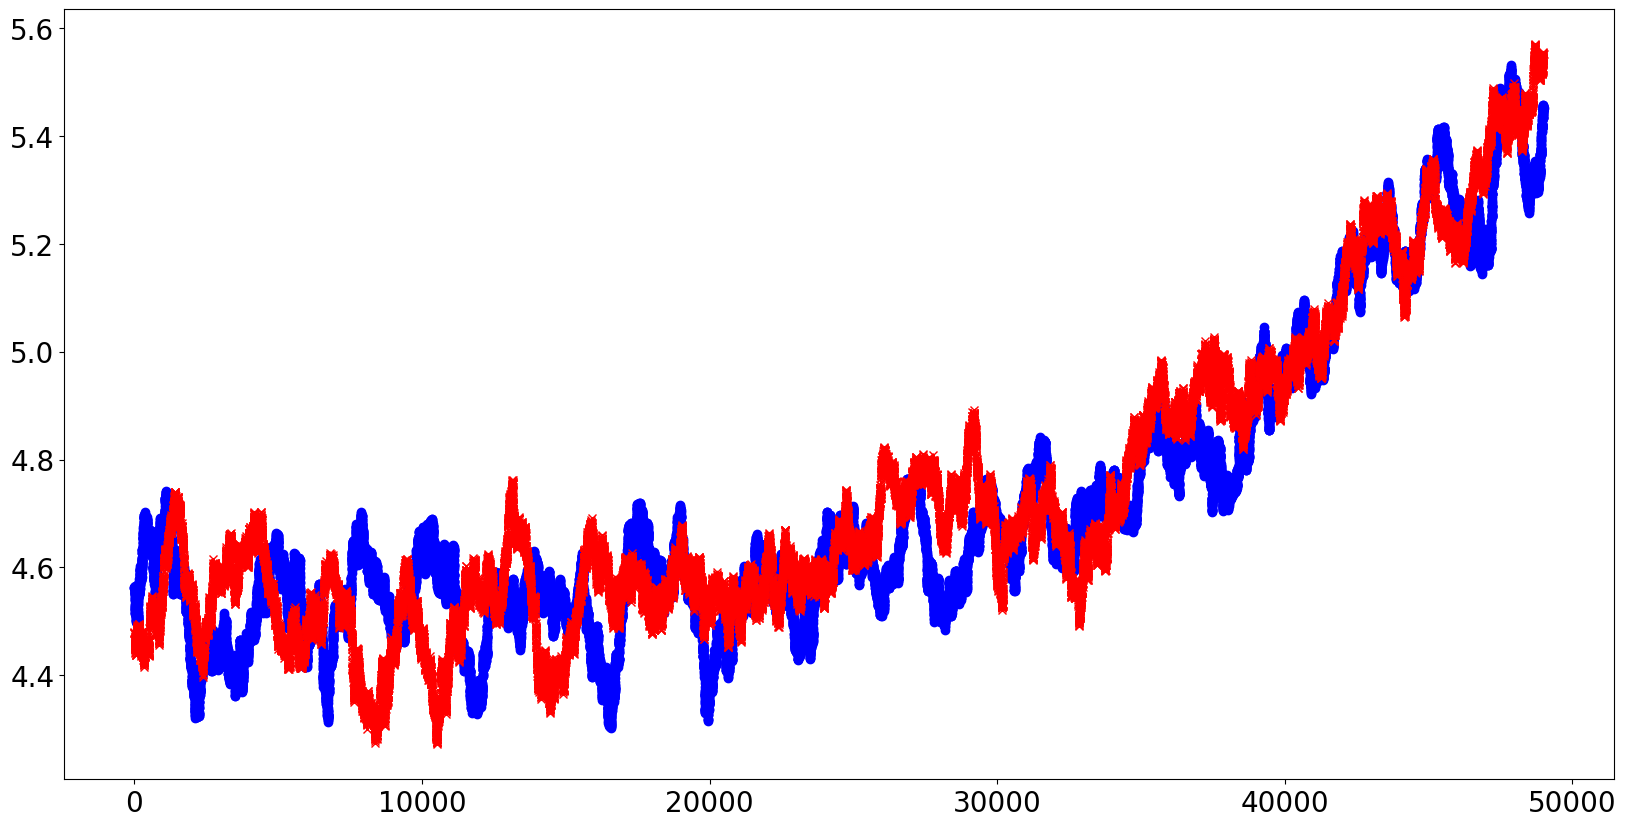

In [40]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams['font.size']=20
plt.plot(moving_average(np.array(agent1.action_history),1000), label = 'Agent 1 Actions', marker = 'o', c = 'b')
plt.plot(moving_average(np.array(agent2.action_history),1000), label = 'Agent 2 Actions', marker = 'x', c = 'r')
#plt.title('Fraction of Co-operations in 100 games') 
plt.show()